#**EDA and Feature Generation**
## shops, items, item_categories

Andreas Theodoulou and Michael Gaidis (June, 2020)

#**0. Mount Google Drive (Local File Storage/Repo For Colab)**

In [1]:
# click on the URL link presented to you by this command, get your authorization code from Google, then paste it into the input box and hit 'enter' to complete mounting of the drive
from google.colab import drive  
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


#**1. Configure Environment and Load Data Files**

In [70]:
# python libraries/modules used throughout this notebook (with some holdovers from other, similar notebooks)
'''
NOTE: selecting a group of code lines and pressing ctrl-/ will toggle commenting of the code lines, for fast and easy disabling/enabling of stuff
'''

# pandas data(database) storage, EDA, and manipulation
import pandas as pd
### pandas formatting
### Adjust as per your preferences.  Here's what I find works well when using a FHD monitor with a full-screen browser window containing my IPynb notebook:
# pd.set_option("display.max_rows",100)     # Override pandas choice of how many rows to show, so we can see the full 84-row item_category df instead of '...' in the middle
# pd.set_option("display.max_columns",30)   # Similar to row code above, we can show more columns than default
# pd.set_option("display.width", 250)       # Tune this to our monitor window size to avoid horiz scroll bars in output windows (but, the drawback is that we will get output text wrapping)
# pd.set_option("max_colwidth", None)       # This is done, for example, so we can see full item name and not '...' in the middle
### Here's what I find works well for this particular IPynb, when using a FHD laptop monitor with a full-screen browser window containing my IPynb notebook:
pd.set_option("display.max_rows",120)     # Override pandas choice of how many rows to show, so, for example, we can see the full 84-row item_category dataframe instead of the first few rows, then ...., then the last few rows
pd.set_option("display.max_columns",26)   # Similar to row code above, we can show more columns than default  
pd.set_option("display.width", 230)       # Tune this to our monitor window size to avoid horiz scroll bars in output windows (but, the drawback is that we will get output text wrapping)
pd.set_option("max_colwidth", None)       # This is done, for example, so we can see full item name and not '...' in the middle

# pd.set_option("display.precision", 3)  # Nah, this is helpful, but below is even better
# Try to convince pandas to print without decimal places if a number is actually an integer (helps keep column width down, and highlights data types), or with precision = 3 decimals if a float
pd.options.display.float_format = lambda x : '{:.0f}'.format(x) if round(x,0) == x else '{:,.3f}'.format(x)

# Pandas additional enhancements
pd.set_option('compute.use_bottleneck', False)  # speed up operation when using NaNs
pd.set_option('compute.use_numexpr', False)     # speed up boolean operations, large dataframes; DataFrame.query() and pandas.eval() will evaluate the subexpressions that can be evaluated by numexpr


# data visualization
import matplotlib.pyplot as plt
import seaborn as sns
# ipynb magic command to allow interactive matplotlib graphics in ipynb notebook
%matplotlib inline  
# a useful reference of contrasting color choices to use when plotting multiple things on a single axis
pltcolors = ['blue','red','green','black','darkorange','fuchsia','teal','gold','violet','olive','firebrick','gray','cyan','sienna','dodgerblue','lime','darkorchid','deeppink','turquoise','tan']
from matplotlib.ticker import MultipleLocator, FormatStrFormatter, AutoMinorLocator
from IPython.display import Javascript      # used to properly code the creation of sns heatmaps in IPynb with Google Colab
from IPython.display import display_html    # used to print out side-by-side dataframes, for example

# computations
import numpy as np
from scipy import sparse
from numba import jit, njit, prange  # speedup for appropriate functions and datatypes (no sets, lists, dictionaries, string functions; use np arrays rather than pandas series or dataframes)
#  If you want Numba to throw an error if it cannot compile a function in a way that speeds up your code, pass the argument nopython=True (e.g. @jit(nopython=True))
from numba import vectorize  # speed up row-wise operations like .apply() --> https://pandas.pydata.org/pandas-docs/stable/user_guide/enhancingperf.html
# can also do np.vectorize (see pandas 1.0.3 documentation section on enhancing speed of pandas operations)

# file operations
import os
import feather   # this is 3x to 8x faster than pd.read_csv and pd.to_hdf, but file size is 2x hdf and 10x csv.gz
import pickle
import json
from urllib.parse import urlunparse
from pathlib import Path

# misc. python enhancements
# note: for a quick look at what's available for magic commands in this ipynb, enter this into a code cell: '%quickref'
import re
import string
from itertools import product
from collections import OrderedDict
import time
import datetime
from time import sleep, localtime, strftime, tzset, strptime
os.environ['TZ'] = 'EST+05EDT,M4.1.0,M10.5.0'   # allows user to simply print a formatted version of the local date and time; helps keep track of what cells were run, and when
tzset()


# Specialized packages
# -- for network analysis / graphs / clustering (a reasonable alternative to pca, tSNE, or Knn clustering when number of dimensions is huge)
import networkx as nx
from networkx.algorithms import community, cluster
# -- NLP packages ... for now, as of 5/29/20, only using the lemmatizer, due to the 
import nltk
nltk.download('wordnet')
from nltk.stem import WordNetLemmatizer 
lemmatizer = WordNetLemmatizer() 

# ML packages
import sklearn
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
# from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
# !pip install catboost
# from catboost import CatBoostRegressor
# %tensorflow_version 2.x
# import tensorflow as tf
# import keras as K

# # List of the modules we need to version-track for reference
modules = ['pandas','matplotlib','numpy','scipy','numba','seaborn','sklearn','tensorflow','keras','catboost','pip','nltk','networkx']
print(f'done: {strftime("%a %X %x")}')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
done: Fri 18:31:18 06/12/20


In [3]:
#  Except for fast-loading (large filesize) feather format files, 
#   the data is coming from a public repo on GitHub at github.com/migai/Kag that has been synced to my local repo on Google Drive

'''
############################################################
############################################################
'''
# Replace this path with the path on *your* Google Drive where the repo master branch is stored
#   (on GitHub, the remote repo is located at github.com/migai/Kag --> below is my cloned repo location)
GDRIVE_REPO_PATH = "/content/drive/My Drive/Colab Notebooks/NRUHSE_2_Kaggle_Coursera/final/Kag"
OUT_OF_REPO_PATH = "/content/drive/My Drive/Colab Notebooks/NRUHSE_2_Kaggle_Coursera/final"   # place > 100MB files here, because they won't sync with GitHub

traintest_loaded = True   # set this to True if you plan to load the .ftr or the .csv.gz version of the traintest dataframe, and skip the calculations below that generated it
ftr_file_load_employed = True #False #True  # set to True if you wish to load the .ftr version or the .csv.gz version... it's faster, but its a 10x larger file, and won't work in the GitHub repo push


# if using large feather file for fast loading, use the routine here
#   note that this is too large to push to GitHub, so if you want to go this route, 
#   you'll first have to load (more slowly) the 'data_output/traintest.csv.gz' file 
#   with pandas read_csv, and then store the file as feather type (outside your local GitHub repo)
#   Or, you can just recreate the dataframe by running the first few code cells that do merging and data manipulation
# load feather files manually for now
if (traintest_loaded and ftr_file_load_employed):
    print('ftr files source directory: ', end='')
    %cd "{OUT_OF_REPO_PATH}"
    traintest = pd.read_feather('traintest.ftr', columns=None, use_threads=True)
    print("Loading ftr Files from Google Drive (outside repo) into Colab... \n\nData Frame: traintest (from ftr)")
    print(traintest.head(2))

'''
############################################################
############################################################
'''

data_files = []
# List of the data files (path relative to GitHub master), to be loaded into pandas DataFrames
if (traintest_loaded and not ftr_file_load_employed):
    data_files = [ "data_output/traintest.csv.gz" ]
                
data_files += [  #"readonly/final_project_data/shops.csv",
                #"data_output/shops_transl.csv",
                "data_output/shops_augmented.csv",
                "data_output/shops_new.csv",
               
                #"readonly/final_project_data/items.csv",
                #"data_output/items_transl.csv",
                "data_output/items_augmented.csv",
                #"data_output/items_new.csv",
                #"data_output/items_clustered_22170.csv.gz",
               
                #"readonly/final_project_data/item_categories.csv",
                #"data_output/item_categories_transl.csv",
                "data_output/item_categories_augmented.csv",
                #"readonly/en_50k.csv",
               
                "readonly/final_project_data/sales_train.csv.gz",
                #"data_output/sales_train_cleaned.csv.gz",
               
                #"readonly/final_project_data/sample_submission.csv.gz",
                "readonly/final_project_data/test.csv.gz"
                ]


# Dict of helper code files, to be loaded and imported {filepath : import_as}
code_files = {}  # not used at this time; example dict = {"helper_code/kaggle_utils_at_mg.py" : "kag_utils"}


# GitHub file location info
git_hub_url = "https://raw.githubusercontent.com/migai"
repo_name = 'Kag'
branch_name = 'master'
base_url = os.path.join(git_hub_url, repo_name, branch_name)

if data_files:
    print('\n\ncsv files source directory: ', end='')
    %cd "{GDRIVE_REPO_PATH}"

    print("\nLoading csv Files from Google Drive repo into Colab...\n")

    # Loop to load the data files into appropriately-named pandas DataFrames
    for path_name in data_files:
        filename = path_name.rsplit("/")[-1]
        data_frame_name = filename.split(".")[0]
        exec(data_frame_name + " = pd.read_csv(path_name)")
        # if data_frame_name == 'sales_train':
        #     sales_train['date'] = pd.to_datetime(sales_train['date'], format = '%d.%m.%Y')
        print(f'DataFrame {data_frame_name}, shape = {eval(data_frame_name).shape} :')
        print(eval(data_frame_name).head(2))
        print("\n")
else: 
    %cd "{GDRIVE_REPO_PATH}"
    
print(f'\nDataFrame Loading Complete: {strftime("%a %X %x")}\n')

ftr files source directory: /content/drive/My Drive/Colab Notebooks/NRUHSE_2_Kaggle_Coursera/final
Loading ftr Files from Google Drive (outside repo) into Colab... 

Data Frame: traintest (from ftr)
   day  DoW  DoM  week  qtr  season  month  price  sales  shop_id  item_id                                      item_name  it_test  item_category_id   item_category_name  it_cat_test item_cat3 item_cat4         shop_name sh_cat  \
0    0  Tue    1     0    0       2      0     99      1        2      991      3D Action Puzzle "Dinosaur" Tyrannosaurus    False                67  Gifts - Development         True     Gifts     Gifts  Adygea TC "Mega"   Mega   
1    0  Tue    1     0    0       2      0   2599      1        2     1472  Assassin's Creed 3 [Xbox 360 Russian version]    False                23     Games - XBOX 360         True     Games      Xbox  Adygea TC "Mega"   Mega   

   sh_test district    city  
0     True    South  Adygea  
1     True    South  Adygea  


csv files sourc

#**2. Merge data sets and create day, week, quarter, and season feature columns**

In [79]:
def clean_merge_augment(day0 = datetime.datetime(2013,1,1),
                        delete_rows = [2909818,2909401,2326930,2257299,1163158,484683],
                        merge_shops = {0: 57, 1: 58, 11: 10},
                        delete_shops = []):
    """
    Parameters:
    day0 = datetime.datetime object representing the day you wish to use as your reference when creating time-based features
    delete_rows = list of integer row numbers that you wish to delete from the sales_train data set
    merge_shops = dictionary of integer shop_id key:value pairs where shop(=key) is merged into shop(=value)
    delete_shops = list of integer shop_id numbers that you wish to fully delete from the sales_train data set
        # looks like it could be safe to delete these shops from sales_train: [8, 13, 23, 32, 33, 40]
        # should probably delete categories 8, 80 (= 'tickets') and probably 81,82 (= 'net carriers')

    Global Variables: this function assumes you have the following pandas dataframes available globally:
    1) unaltered sales_train
    2) unaltered test
    3) items_augmented (contains 'item_id', 'item_tested', 'item_category_id', and 'orig_eng_name_transl')
    4) item_categories_augmented ('item_category_id','en_cat_name','item_cat_tested','item_category3','item_category4')
    5) shops_augmented ('shop_id', 'en_shop_name', 'shop_city', 'shop_federal_district',  'shop_city_population',  'shop_tested')
    6) shops_new ('shop_id', 'shop_type', 'fd_popdens',  'fd_gdp')

    This function does the following:
    1) cleans (deletes) outlier rows from the training set that appear to be erroneous or irrelevant entries
    2) merge 3 shops into other shops where it appears that the sales_train set simply has different names for the 
        same shop at different time periods (shop 0 absorbed by 57; shop 1 absorbed by 58, shop 11 absorbed by 10)
    3) optionally delete shops entirely from the sales_train data set (e.g., for irrelevant shops)
    4) append the test set rows to the sales_train rows, using a date of November 1, 2015 for test
    5) adjust the 'date' column on the merged dataset to be in datetime format, so it looks like a string of format: 'YYYY-M-D'
    6) merge the aforementioned data sets into the merged sales_train + test DataFrame

    Then, creates and inserts new time-based feature columns as follows:
    Given a dataframe with a 'date' column containing strings like '2015-10-30', create new time-series columns:
    1. 'day'    = integer value of day number, starting at day = 0 for parameter day0, and incrementing by calendar day number (not by transaction day number)... 
                    Thus, 'day' may not include all possible integers from start to finish.  It only assigns integer values (based on the calendar) to days when 
                    there are transactions in the input dataframe --> if the input dataframe has no transactions on a particular day, that day's 'calendar' integer 
                    value will not be present in the column (will be = 0)
    2. 'DoW'    = day of week = 3-character text string of weekday by name (Sun, Mon, ...)
    3. 'DoM'    = day of month = 1-31
    4. 'week'   = integer value of week number, with week = 0 at time= parameter day0.  However, unlike 'day', the 'week' number is aligned not to start at day0, but rather
                    so that there is a full 'week' of 7 days that ends on Oct. 31, 2015 (the final day of training data).  This results in week = 0 having only 5 days in it.
                    n.b., the final week of October, 2015 is assigned 'week' number = 147.  Artifically assigning test to Nov. 1, 2015 results in test week = 148
    5. 'month'  = renamed from "date_block_num" of original data set (no changes).  Integer values from 0 to 33 represent the months starting at day0.  Test month=34 is Nov. 2015.
    6. 'qtr'    = quarter = integer number of 3-month chunks of time, aligned with the end of October, 2015.  day0 is included in 'qtr' = 0, but 'qtr'=0 only contains 1 month (Jan 2013) of data due to the alignment
                    The months of August, Sept, Oct 2015 form 'qtr' = 11.  "qtr" in this sense is just 3-month chunks... it is not the traditional Q1,Q2,Q3,Q4 beginning Jan 1, but instead is more like
                    date_block_num in that it is monotonically increasing integers, incremented every 3 months such that #11 ends at the end of our training data
    7. 'season' = integer number of 3-month chunks of time, reset each year (allowed values = 0,1,2,3)... not quite the same as spring-summer-winter-fall, or Q1,Q2,Q3,Q4, but instead shifted to 
                    better capture seasonal spending trends aligned in particular with high December spending
                    2 = Dec 1 to Feb 28 (biggest spending season), 3 = Mar 1 to May 31, 0 = June 1 to Aug 30 (lowest spending season), 1 = Sept 1 to Nov 30

    Finally, drop the date column from the dataframe, and sort the dataframe by ['day','shop_id','item_id']  (original dataframe seems to be sorted by month, but unsorted within each month)

    returns: the cleaned/dated/merged/feature-augmented DataFrame
    """

    print(f'Shape of original sales_train data set = {sales_train.shape}')

    # remove outlier rows from training set (first make a DataFrame copy so we can reuse sales_train later, if we need to)
    sales_train_cleaned = sales_train.copy(deep=True)
    print('Rows being deleted:')
    for i in sorted(delete_rows, reverse=True):   # delete the rows in reverse order to be sure we don't run into issues with indexing
        print(f'  {i}')
        sales_train_cleaned.drop(sales_train_cleaned.index[i],inplace=True)
    print(f'Shape of sales_train_cleaned after {len(delete_rows)} outlier rows were removed: {sales_train_cleaned.shape}')
    
    # Merge the 3 shops we are nearly certain must correctly fit into the other shops' dropout regions:
    sales_train_cleaned.shop_id = sales_train_cleaned.shop_id.replace(merge_shops)
    print(f'Shape of sales_train_cleaned after merging shops as in {merge_shops}: {sales_train_cleaned.shape}')

    # Remove irrelevant shops entirely from the sales_train_cleaned DataFrame:
    if delete_shops:
        sales_train_cleaned = sales_train_cleaned.query('shop_id != @delete_shops')
        print(f'Shape of sales_train_cleaned after deleting shops {delete_shops}: {sales_train_cleaned.shape}')

    # sales_train_cleaned = sales_train_cleaned[sales_train_cleaned.shop_id != 9]
    # sales_train_cleaned = sales_train_cleaned[sales_train_cleaned.shop_id != 13]
    # print(f'Shape of sales_train_cleaned after removal of shops: {sales_train_cleaned.shape})
    # print(f'{sales_train_cleaned.shop_id.nunique()} shops remaining in sales_train_cleaned DataFrame: {sorted(sales_train_cleaned.shop_id.unique())})

    sales_train_cleaned = sales_train_cleaned.astype({'date_block_num':np.int8,'shop_id':np.int8,'item_id':np.int16,
                                                    'item_price':np.float32,'item_cnt_day':np.int16}).reset_index(drop=True)

    # merge dataframes so we optionally include test elements in our EDA and feature generation
    test_prep = test.copy(deep=True)
    test_prep['date_block_num'] = 34
    test_prep['date'] = '1.11.2015' #pd.Timestamp(year=2015, month=11, day=1)
    sales_traintest_cleaned = sales_train_cleaned.append(test_prep).fillna(0)

    traintest = sales_traintest_cleaned.merge(items_augmented[['item_id','item_category_id','item_tested','item_name']],on='item_id',how='left').reset_index(drop=True)
    traintest = traintest.merge(item_categories_augmented[['item_category_id','en_cat_name','item_cat_tested','item_category3','item_category4']],on='item_category_id',how='left').reset_index(drop=True)
    traintest = traintest.merge(shops_augmented[['shop_id', 'en_shop_name', 'shop_city', 'shop_federal_district', 'shop_tested']], on='shop_id',how='left').reset_index(drop=True)  
    traintest = traintest.merge(shops_new[['shop_id', 'shop_type']], on='shop_id',how='left').reset_index(drop=True)
    traintest = traintest[['date', 'date_block_num', 'item_price', 'item_cnt_day', 'shop_id', 'item_id', 'item_name', 'item_tested', 'item_category_id', 'en_cat_name', 'item_cat_tested',
                                'item_category3', 'item_category4', 'en_shop_name', 'shop_type','shop_tested', 'shop_federal_district', 'shop_city']]
    traintest.columns = ['date', 'month', 'price', 'sales', 'shop_id', 'item_id', 'item_name', 'it_test', 'item_category_id', 'item_category_name', 'it_cat_test', 'item_cat3', 'item_cat4', 
                            'shop_name', 'sh_cat', 'sh_test', 'district', 'city']
    traintest.item_name.astype(str)
    print(f'Shape of traintest after merging: {traintest.shape}')
        
    # Add in the time-based feature columns
    traintest.date =  pd.to_datetime(traintest.date, dayfirst=True, infer_datetime_format=True)
    traintest.insert(1,'day', traintest.date.apply(lambda x: (x - day0).days))
    traintest.insert(2,'DoW', traintest.date.apply(lambda x: x.strftime('%a')))  # lambda x: (x.weekday()+1)%7 )  # 0=Sun, 1=Mon, ... 6= Sat   # use x.strftime('%A') to get full text string of day (Sunday, Monday, ...)
    traintest.insert(3,'DoM', traintest.date.apply(lambda x: x.day))
    traintest.insert(4,'week', (traintest.day+2) // 7 )             # add the 2 days so we have end of a week coinciding with end of training data Oct. 31, 2015
    traintest.insert(5,'qtr', (traintest.month + 2) // 3 )          # add the 2 months so we have end of a quarter aligning with end of training data Oct. 31, 2015
    traintest.insert(6,'season', (traintest.month + 2) % 4 ) 
    traintest.drop('date',axis=1,inplace=True)
    traintest = traintest.sort_values(['day','shop_id','item_id']).reset_index(drop=True)  # note that the train dataset is sorted by month, but nothing obvious within the month; we sort it here for consistent results in calculations below
    print(f'Shape of traintest after creating time-based feature columns: {traintest.shape}')
    print(f'traintest DataFrame creation done: {strftime("%a %X %x")}\n')
    return traintest

print(f'\nDone: {strftime("%a %X %x")}\n')


Done: Fri 18:38:26 06/12/20



In [80]:
if True: #not traintest_loaded:
    print(f'traintest dataframe creation started: {strftime("%a %X %x")}\n')
    traintest = clean_merge_augment()

    # optional save file as feather type (big file; don't store inside repo) and/or csv.gz type (inside repo)
    %cd "{OUT_OF_REPO_PATH}"
    traintest.to_feather('traintest.ftr')
    print("traintest.ftr feather file stored on google drive, outside repo")
    %cd "{GDRIVE_REPO_PATH}"
    # alternative, or, in addition, can save as csv.gz for < 100 MB storage and sync with GitHub
    compression_opts = dict(method='gzip',
                            archive_name='traintest.csv')  
    traintest.to_csv('data_output/traintest.csv.gz', index=False, compression=compression_opts)
    print("traintest.csv.gz file stored on google drive in data_output directory")
    print(f'traintest file save done: {strftime("%a %X %x")}')

display(traintest[traintest.week == 102].tail(2))

# Copy in case we screw up tt; don't want to recreate traintest
tt = traintest.copy(deep=True)

print(f'\ntraintest done: {strftime("%a %X %x")}')

traintest dataframe creation started: Fri 18:38:36 06/12/20

Shape of original sales_train data set = (2935849, 6)
Rows being deleted:
  2909818
  2909401
  2326930
  2257299
  1163158
  484683
Shape of sales_train_cleaned after 6 outlier rows were removed: (2935843, 6)
Shape of sales_train_cleaned after merging shops as in {0: 57, 1: 58, 11: 10}: (2935843, 6)
Shape of traintest after merging: (3150043, 18)
Shape of traintest after creating time-based feature columns: (3150043, 23)
traintest DataFrame creation done: Fri 18:40:09 06/12/20

/content/drive/My Drive/Colab Notebooks/NRUHSE_2_Kaggle_Coursera/final
traintest.ftr feather file stored on google drive, outside repo
/content/drive/My Drive/Colab Notebooks/NRUHSE_2_Kaggle_Coursera/final/Kag
traintest.csv.gz file stored on google drive in data_output directory
traintest file save done: Fri 18:41:02 06/12/20


day  DoW  DoM  week  qtr  season  month  price  sales  shop_id  item_id                   item_name  it_test  item_category_id item_category_name  it_cat_test item_cat3 item_cat4                           shop_name  \
2257039  718  Sat   20   102    8       1     23    399      1       59    21970  shar predictor soccer ball    False                69  Gifts - Souvenirs         True     Gifts     Gifts  Yaroslavl shopping center "Altair"   
2257040  718  Sat   20   102    8       1     23    499      1       59    22060             epic bluray dvd     True                37    Movie - Blu-Ray         True    Movies    Movies  Yaroslavl shopping center "Altair"   

        sh_cat  sh_test district       city  
2257039    SEC     True  Central  Yaroslavl  
2257040    SEC     True  Central  Yaroslavl


traintest done: Fri 18:41:02 06/12/20


#**3. What shops are critical for items or item_categories that are rarely sold?**
(i.e., can we delete any shops because they are irrelevant?)

In [33]:
print(f'Start: {strftime("%a %X %x")}')
test_items = test.sort_values(['item_id','shop_id']).item_id.unique()
test_item_df = pd.DataFrame({'item_id':test_items, 'n_shops':np.NaN, 'shops':np.NaN, 'item_cat':np.NaN, 'cat_name':np.NaN})

ttq = tt[tt.month < 34].copy(deep=True)
ttq = ttq[['day','shop_id','item_id','item_category_id','sales']]
ttq = ttq[ttq.item_id.isin(test_items)]

test_item_df.item_cat = test_item_df.item_id.apply(lambda x: items_augmented.at[x,'item_category_id'])
test_item_df.cat_name = test_item_df.item_cat.apply(lambda x: item_categories_augmented.at[x,'en_cat_name'])
cat_counts = test_item_df.item_cat.value_counts().to_frame().reset_index().rename(columns={'index':'item_cat_id', 'item_cat':'n_test_items_in_cat'})
test_item_df.shops = test_item_df.item_id.apply(lambda x: ttq.query('item_id == @x').shop_id.unique())
test_cats = test_item_df.sort_values('item_cat').item_cat.unique()
test_cats_df = pd.DataFrame({'item_cat_id':test_cats,'n_shops_selling_cat':np.NaN, 'item_cat_shops':np.NaN})
test_cats_df = test_cats_df.merge(cat_counts, on='item_cat_id', how='left')

ttcq = tt[tt.month < 34].copy(deep=True)
ttcq = ttcq.groupby(['shop_id','item_category_id']).agg({'sales':'sum'}).reset_index()
ttcq = ttcq[ttcq.item_category_id.isin(test_cats)]
print(f'\nttcq DataFrame, shape: {ttcq.shape}')
display(ttcq.head())

test_cats_df.item_cat_shops = test_cats_df.item_cat_id.apply(lambda x: ttcq.query('item_category_id == @x').shop_id.unique())
test_item_df.n_shops = test_item_df.shops.apply(lambda x: len(x))
test_cats_df.n_shops_selling_cat = test_cats_df.item_cat_shops.apply(lambda x: len(x))
test_cats_df['cat_name'] = test_cats_df.item_cat_id.apply(lambda x: item_categories_augmented.at[x,'en_cat_name'])

print(f'\ntest_item_df DataFrame, shape: {test_item_df.shape}    nunique item_ids: {test_item_df.item_id.nunique()}')
display(test_item_df.head())
print(f'\ntest_cats_df DataFrame, shape: {test_cats_df.shape}    nunique cat_ids: {test_cats_df.item_cat_id.nunique()}')
display(test_cats_df.head())
print(f'Done: {strftime("%a %X %x")}')

Start: Fri 16:35:53 06/12/20

ttcq DataFrame, shape: (2643, 3)


shop_id  item_category_id  sales
0        2                 2    355
1        2                 3    527
3        2                 5     50
4        2                 6    329
5        2                 7     76


test_item_df DataFrame, shape: (5100, 5)    nunique item_ids: 5100


item_id  n_shops                                                                                                                                                                                                      shops  \
0       30       48                  [6, 8, 13, 19, 21, 22, 23, 26, 27, 28, 29, 30, 31, 32, 35, 37, 41, 42, 43, 46, 50, 54, 7, 15, 16, 44, 56, 10, 12, 24, 25, 38, 45, 47, 51, 53, 59, 4, 14, 57, 5, 18, 52, 58, 3, 2, 17, 48]   
1       31       51      [6, 7, 14, 15, 16, 18, 19, 21, 22, 25, 26, 27, 28, 29, 30, 31, 32, 35, 37, 41, 42, 43, 44, 45, 51, 52, 54, 12, 24, 38, 46, 50, 4, 13, 23, 56, 59, 8, 10, 53, 57, 58, 2, 3, 5, 47, 17, 49, 39, 34, 48]   
2       32       51      [27, 28, 38, 42, 46, 54, 14, 25, 31, 44, 59, 6, 13, 16, 19, 21, 29, 35, 51, 52, 57, 4, 45, 3, 18, 23, 26, 37, 58, 56, 15, 30, 24, 53, 7, 32, 41, 43, 8, 5, 50, 10, 12, 22, 47, 17, 2, 49, 48, 33, 39]   
3       33       52  [27, 54, 7, 19, 44, 29, 50, 57, 6, 45, 2, 24, 28, 47, 51, 16, 25, 8, 56, 15, 31, 23, 41, 46, 38, 42, 26, 37, 18, 32, 53, 35, 21, 5, 30, 12, 43, 58, 13, 14, 52, 59, 10, 17, 4, 3, 22, 49, 39, 48, 34, 36]   
4       38       31                                                                                 [19, 54, 24, 13, 6, 25, 44, 59, 52, 15, 27, 30, 33, 58, 56, 31, 28, 12, 46, 57, 4, 26, 48, 39, 51, 47, 42, 10, 22, 16, 45]   

   item_cat            cat_name  
0        40         Movie - DVD  
1        37     Movie - Blu-Ray  
2        40         Movie - DVD  
3        37     Movie - Blu-Ray  
4        41  Cinema - Collector


test_cats_df DataFrame, shape: (62, 5)    nunique cat_ids: 62


item_cat_id  n_shops_selling_cat  \
0            0                    3   
1            2                   51   
2            3                   54   
3            5                   50   
4            6                   53   

                                                                                                                                                                                                      item_cat_shops  \
0                                                                                                                                                                                                       [25, 38, 57]   
1               [2, 3, 4, 5, 6, 7, 8, 9, 10, 12, 14, 15, 16, 17, 18, 19, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 35, 37, 38, 39, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 56, 57, 58, 59]   
2  [2, 3, 4, 5, 6, 7, 9, 10, 12, 13, 14, 15, 16, 17, 18, 19, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 56, 57, 58, 59]   
3                  [2, 3, 4, 5, 6, 7, 8, 10, 12, 14, 15, 16, 17, 18, 19, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 35, 37, 38, 39, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 56, 57, 58, 59]   
4       [2, 3, 4, 5, 6, 7, 8, 9, 10, 12, 14, 15, 16, 17, 18, 19, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 56, 57, 58, 59]   

   n_test_items_in_cat                    cat_name  
0                    1  PC - Headsets / Headphones  
1                   10           Accessories - PS3  
2                   28           Accessories - PS4  
3                    4        Accessories - PSVita  
4                    9      Accessories - XBOX 360

Done: Fri 16:36:46 06/12/20


Items item_id n_shops item_cat 
 
 count 
 5.1e+03 
 5.1e+03 
 5.1e+03 
 
 
 mean 
 1.1e+04 
 26 
 46 
 
 
 std 
 6.3e+03 
 18 
 17 
 
 
 min 
 30 
 0 
 0 
 
 
 25% 
 5.4e+03 
 8 
 37 
 
 
 50% 
 1.1e+04 
 28 
 43 
 
 
 75% 
 1.6e+04 
 44 
 58 
 
 
 max 
 2.2e+04 
 55 
 83 
 
        Item Categories item_cat_id n_shops_selling_cat n_test_items_in_cat 
 
 count 
 62 
 62 
 62 
 
 
 mean 
 42 
 43 
 82 
 
 
 std 
 24 
 21 
 1.4e+02 
 
 
 min 
 0 
 1 
 1 
 
 
 25% 
 23 
 48 
 8 
 
 
 50% 
 40 
 52 
 33 
 
 
 75% 
 63 
 55 
 1e+02 
 
 
 max 
 83 
 56 
 7.7e+02

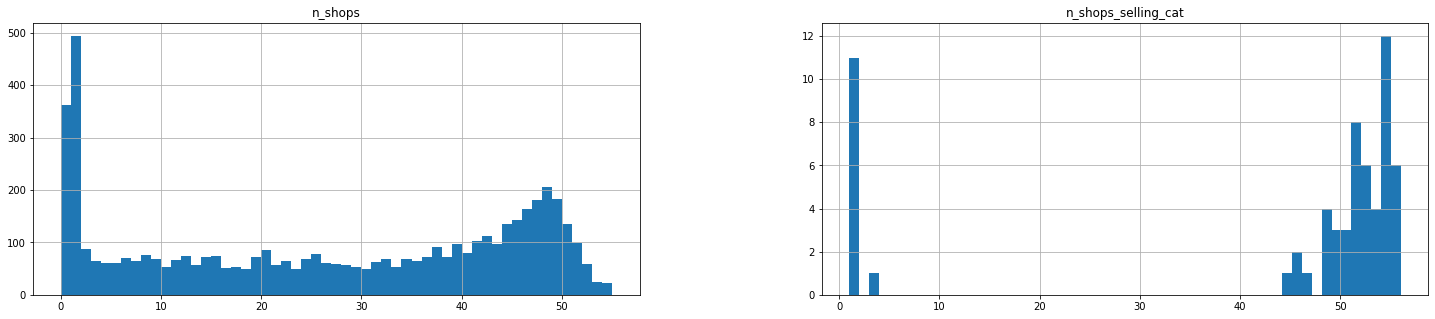

In [34]:
df1_styler = test_item_df.describe().style.set_table_attributes("style='display:inline'").set_caption('Items').format("{:.2g}")
df2_styler = test_cats_df.describe().style.set_table_attributes("style='display:inline'").set_caption('Item Categories').format("{:.2g}")

display_html(df1_styler._repr_html_() + "\xa0\xa0\xa0" + "\xa0\xa0\xa0" +
             df2_styler._repr_html_(), raw=True)


#display(test_item_df.describe())
fig = plt.figure(figsize=(25,5)) 
axItem = fig.add_subplot(1,2,1)
axCat = fig.add_subplot(1,2,2)
nit = test_item_df.hist('n_shops', bins=55, ax=axItem)
ncat = test_cats_df.hist('n_shops_selling_cat', bins=56, ax=axCat)

# many items in test set (> 350) have 0 shops selling them, and nearly 500 have only 1 shop selling them (out of 5100 possible)
# several categories (11) have only 1 shop selling them; one category has only 3 shops selling it

In [36]:
# How many times to the "partially open" (i.e., closed before month 34) and "untested" shops show up in the low count item and category shop sellers?

partial = [8, 9, 13, 17, 20, 23, 27, 29, 30, 32, 33, 40, 43, 51, 54]  # untested shops that don't show sales over the full range of days in months 0 to 33

def color_badlist_red(val):
    """
    Takes a scalar and returns a string with
    the css property `'color: red'` for shops in the 'partial' list
    and black otherwise
    """
    color = 'red' if val in partial else 'black'
    return 'color: %s' % color


part_cat_shop = test_cats_df[test_cats_df.n_shops_selling_cat < 4].copy(deep=True)
print(f'before explode: {part_cat_shop.shape}')
part_cat_shop = part_cat_shop.explode('item_cat_shops').reset_index(drop=True)
print(f'after explode: {part_cat_shop.shape}')
display(part_cat_shop.head(15))
pcs_vc = part_cat_shop.item_cat_shops.value_counts().to_frame().reset_index().rename(columns={'index':'shop_id', 'item_cat_shops':'n_appearances_in_low_n_shops_item_categories'})
s = pcs_vc.style.applymap(color_badlist_red)
display(s)

# 55 is a very important shop regarding sales of items in strange categories --> need to either combine these categories with other categories, or do something to help 55


before explode: (12, 5)
after explode: (14, 5)


item_cat_id  n_shops_selling_cat item_cat_shops  n_test_items_in_cat                           cat_name
0             0                    3             25                    1         PC - Headsets / Headphones
1             0                    3             38                    1         PC - Headsets / Headphones
2             0                    3             57                    1         PC - Headsets / Headphones
3             9                    1             12                    8                  Delivery of goods
4            26                    1             55                    2            Games Android - Digital
5            27                    1             55                    1                Games MAC - Digital
6            31                    1             55                  277                 Games PC - Digital
7            34                    1             55                    5    Payment cards - Live! (Numeral)
8            36                    1             55                    2    Payment card - Windows (figure)
9            44                    1             55                    7        Books - Audiobooks (figure)
10           54                    1             55                   38                    Books - Digital
11           74                    1             55                    1             Program - MAC (figure)
12           76                    1             55                   61  Program - Home & Office (Digital)
13           78                    1             55                   49    Programs - Educational (figure)

In [62]:
def highlight_partial(s, color='red'):
    """
    highlight the partially-open shops in a Series or DataFrame
    """
    attr = f'color: {color}'
    is_partial = s.isin(partial)
    return pd.Series([attr if v else '' for v in is_partial])

partial_shops_items = OrderedDict({2:{},3:{},6:{}})
for nmax in [2,3,6]:
    partial_shops_items[nmax]['df'] = test_item_df[test_item_df.n_shops < (nmax + 1)].copy(deep=True)
    partial_shops_items[nmax]['shape_before_explode'] = partial_shops_items[nmax]['df'].shape
    partial_shops_items[nmax]['df'] = partial_shops_items[nmax]['df'].explode('shops').sort_values(['n_shops','item_id'])
    partial_shops_items[nmax]['shape_after_explode'] = partial_shops_items[nmax]['df'].shape
    partial_shops_items[nmax]['df']['item_name'] = partial_shops_items[nmax]['df'].item_id.apply(lambda x: items_augmented.at[x, 'item_name']).reset_index(drop=True)
    partial_shops_items[nmax]['df_vc_s'] = partial_shops_items[nmax]['df'].shops.value_counts().to_frame().reset_index().rename(columns={'index':'shop_id', 'shops':f'n_appearances_in_nmax{nmax}_shops_items'})
    included_shops = partial_shops_items[nmax]['df_vc_s'].shop_id.unique()
    #partial_shops_items[nmax]['df_vc_s'] = partial_shops_items[nmax]['df_vc_s'].style.apply(highlight_partial, subset='shop_id')
    partial_shops_items[nmax]['included_partial_shops'] = [x for x in partial if x in included_shops]
    partial_shops_items[nmax]['not_included_partial_shops'] = [x for x in partial if x not in included_shops]

    print(f'For fewer than {nmax+1} shops selling a particular item:')
    print(f'    shape before explode: {partial_shops_items[nmax]["shape_before_explode"]}')
    print(f'    shape after explode:  {partial_shops_items[nmax]["shape_after_explode"]}')
    print(f'    partially-active shops involved in selling items that are sold from fewer than {nmax+1} shops: {partial_shops_items[nmax]["included_partial_shops"]}')
    print(f'    partially-active shops NOT involved in selling items that are sold from fewer than {nmax+1} shops: {partial_shops_items[nmax]["not_included_partial_shops"]}\n')

# nmax_styler = {}
# displ = ""
# for nmax in [2,3,6]:
#     nmax_styler[nmax] = partial_shops_items[nmax]['df'].describe().style.set_table_attributes("style='display:inline'").set_caption(f'n_shops < {nmax+1}').format("{:.2g}")
#     displ += nmax_styler[nmax]._repr_html_() + "\xa0\xa0\xa0" + "\xa0\xa0\xa0"
# display_html(displ, raw=True)

nmax_styler = {}
displ = ""
for nmax in [2,3,6]:
    nmax_styler[nmax] = partial_shops_items[nmax]['df_vc_s'].style.apply(highlight_partial, subset='shop_id').set_table_attributes("style='display:inline'").set_caption(f'n_shops < {nmax+1}')
    displ += nmax_styler[nmax]._repr_html_() + "\xa0\xa0\xa0" + "\xa0\xa0\xa0"
display_html(displ, raw=True)

# looks like it could be safe to delete these shops from sales_train: [8, 13, 23, 32, 33, 40]

For fewer than 3 shops selling a particular item:
    shape before explode: (944, 5)
    shape after explode:  (1031, 5)
    partially-active shops involved in selling items that are sold from fewer than 3 shops: [9, 20, 29, 43, 51, 54]
    partially-active shops NOT involved in selling items that are sold from fewer than 3 shops: [8, 13, 17, 23, 27, 30, 32, 33, 40]

For fewer than 4 shops selling a particular item:
    shape before explode: (1008, 5)
    shape after explode:  (1223, 5)
    partially-active shops involved in selling items that are sold from fewer than 4 shops: [9, 17, 20, 27, 29, 30, 43, 51, 54]
    partially-active shops NOT involved in selling items that are sold from fewer than 4 shops: [8, 13, 23, 32, 33, 40]

For fewer than 7 shops selling a particular item:
    shape before explode: (1199, 5)
    shape after explode:  (2187, 5)
    partially-active shops involved in selling items that are sold from fewer than 7 shops: [9, 17, 20, 27, 29, 30, 43, 51, 54]
    parti

n_shops < 3 shop_id n_appearances_in_nmax2_shops_items 
 
 0 
 55 
 399 
 
 
 1 
 25 
 51 
 
 
 2 
 31 
 35 
 
 
 3 
 9 
 21 
 
 
 4 
 6 
 21 
 
 
 5 
 20 
 19 
 
 
 6 
 12 
 17 
 
 
 7 
 42 
 13 
 
 
 8 
 19 
 9 
 
 
 9 
 46 
 7 
 
 
 10 
 22 
 6 
 
 
 11 
 57 
 6 
 
 
 12 
 21 
 6 
 
 
 13 
 4 
 6 
 
 
 14 
 28 
 5 
 
 
 15 
 15 
 5 
 
 
 16 
 56 
 5 
 
 
 17 
 5 
 4 
 
 
 18 
 24 
 4 
 
 
 19 
 44 
 3 
 
 
 20 
 37 
 3 
 
 
 21 
 18 
 2 
 
 
 22 
 35 
 2 
 
 
 23 
 26 
 2 
 
 
 24 
 47 
 2 
 
 
 25 
 54 
 2 
 
 
 26 
 10 
 2 
 
 
 27 
 7 
 1 
 
 
 28 
 3 
 1 
 
 
 29 
 59 
 1 
 
 
 30 
 14 
 1 
 
 
 31 
 16 
 1 
 
 
 32 
 29 
 1 
 
 
 33 
 43 
 1 
 
 
 34 
 48 
 1 
 
 
 35 
 50 
 1 
 
 
 36 
 51 
 1 
 
 
 37 
 2 
 1 
 
        n_shops < 4 shop_id n_appearances_in_nmax3_shops_items 
 
 0 
 55 
 399 
 
 
 1 
 25 
 77 
 
 
 2 
 31 
 61 
 
 
 3 
 20 
 37 
 
 
 4 
 9 
 32 
 
 
 5 
 6 
 29 
 
 
 6 
 12 
 28 
 
 
 7 
 42 
 20 
 
 
 8 
 46 
 15 
 
 
 9 
 28 
 15 
 
 
 10 
 22 
 14 
 
 
 11 
 57 
 13 
 
 
 12 
 19 
 12 
 
 
 13 
 21 
 11 
 
 
 14 
 56 
 10 
 
 
 15 
 4 
 9 
 
 
 16 
 24 
 8 
 
 
 17 
 15 
 6 
 
 
 18 
 54 
 5 
 
 
 19 
 37 
 5 
 
 
 20 
 10 
 4 
 
 
 21 
 5 
 4 
 
 
 22 
 18 
 4 
 
 
 23 
 59 
 3 
 
 
 24 
 44 
 3 
 
 
 25 
 35 
 3 
 
 
 26 
 38 
 3 
 
 
 27 
 47 
 3 
 
 
 28 
 27 
 2 
 
 
 29 
 53 
 2 
 
 
 30 
 51 
 2 
 
 
 31 
 7 
 2 
 
 
 32 
 48 
 2 
 
 
 33 
 14 
 2 
 
 
 34 
 26 
 2 
 
 
 35 
 16 
 2 
 
 
 36 
 30 
 2 
 
 
 37 
 2 
 2 
 
 
 38 
 45 
 1 
 
 
 39 
 17 
 1 
 
 
 40 
 43 
 1 
 
 
 41 
 41 
 1 
 
 
 42 
 50 
 1 
 
 
 43 
 29 
 1 
 
 
 44 
 3 
 1 
 
        n_shops < 7 shop_id n_appearances_in_nmax6_shops_items 
 
 0 
 55 
 399 
 
 
 1 
 25 
 202 
 
 
 2 
 31 
 179 
 
 
 3 
 42 
 89 
 
 
 4 
 20 
 83 
 
 
 5 
 6 
 78 
 
 
 6 
 9 
 67 
 
 
 7 
 12 
 67 
 
 
 8 
 28 
 65 
 
 
 9 
 57 
 43 
 
 
 10 
 21 
 41 
 
 
 11 
 22 
 39 
 
 
 12 
 46 
 35 
 
 
 13 
 56 
 33 
 
 
 14 
 19 
 31 
 
 
 15 
 54 
 28 
 
 
 16 
 18 
 24 
 
 
 17 
 47 
 23 
 
 
 18 
 24 
 20 
 
 
 19 
 27 
 19 
 
 
 20 
 35 
 18 
 
 
 21 
 26 
 16 
 
 
 22 
 15 
 15 
 
 
 23 
 44 
 14 
 
 
 24 
 37 
 14 
 
 
 25 
 48 
 13 
 
 
 26 
 52 
 13 
 
 
 27 
 16 
 12 
 
 
 28 
 38 
 11 
 
 
 29 
 4 
 11 
 
 
 30 
 45 
 11 
 
 
 31 
 50 
 11 
 
 
 32 
 39 
 10 
 
 
 33 
 10 
 10 
 
 
 34 
 14 
 9 
 
 
 35 
 5 
 9 
 
 
 36 
 2 
 8 
 
 
 37 
 53 
 7 
 
 
 38 
 7 
 6 
 
 
 39 
 58 
 5 
 
 
 40 
 51 
 5 
 
 
 41 
 41 
 4 
 
 
 42 
 29 
 3 
 
 
 43 
 17 
 3 
 
 
 44 
 30 
 3 
 
 
 45 
 34 
 3 
 
 
 46 
 36 
 3 
 
 
 47 
 43 
 3 
 
 
 48 
 49 
 3 
 
 
 49 
 3 
 3 
 
 
 50 
 59 
 3

#**4. Zero-Sales Days**
(when is the shop active vs. closed (shuttered) or not yet open for business?)

In [65]:
# Establish which shops have consecutive zero-sales days, and how long zero-sales periods extend

day_shop = tt.query('month < 34').groupby(['day','shop_id','item_id']).agg({'sh_test':'mean','it_test':'mean',
                'item_category_id':'mean','it_cat_test':'mean','month':'mean', 'DoM':'mean','price':'count','sales':'sum'}).reset_index()
day_shop.rename(columns={'price':'n_transactions_per_day'}, inplace=True)
print(f'Number of days in training period: {(datetime.datetime(2015,11,1) - datetime.datetime(2013,1,1)).days}')
print(f'Shape of day_shop DataFrame: {day_shop.shape}')
display(day_shop.describe())
print('\n')
display(day_shop.head())

Number of days in training period: 1034
Shape of day_shop DataFrame: (2935815, 11)


day  shop_id    item_id  item_category_id   month     DoM  n_transactions_per_day   sales
count 2935815  2935815    2935815           2935815 2935815 2935815                 2935815 2935815
mean  457.239   33.303 10,197.194            40.001  14.570  15.853                   1.000   1.241
std   286.899   16.147  6,324.292            17.101   9.423   8.923                   0.003   2.179
min         0        2          0                 0       0       1                       1     -22
25%       212       22       4476                28       7       8                       1       1
50%       427       31       9343                40      14      16                       1       1
75%       703       48      15684                55      23      24                       1       1
max      1033       59      22169                83      33      31                       2     669

day  shop_id  item_id  sh_test  it_test  item_category_id  it_cat_test  month  DoM  n_transactions_per_day  sales
0    0        2      991     True    False                67         True      0    1                       1      1
1    0        2     1472     True    False                23         True      0    1                       1      1
2    0        2     1905     True     True                30         True      0    1                       1      1
3    0        2     2920     True    False                21         True      0    1                       1      2
4    0        2     3320     True    False                19         True      0    1                       1      1

In [67]:
zero_sale = pd.DataFrame({'shop_id':day_shop.sort_values('shop_id').shop_id.unique(), 'n_active':np.NaN, 'n_inactive':np.NaN, 'active_days':np.NaN, 'inactive_days':np.NaN})
zero_sale.active_days = zero_sale.shop_id.apply(lambda x: day_shop[day_shop.shop_id == x].day.unique())
zero_sale.n_active = zero_sale.active_days.apply(lambda x: len(x))
zero_sale.n_inactive = 1034 - zero_sale.n_active
zero_sale.inactive_days = zero_sale.active_days.apply(lambda x: [i for i in range(1034) if i not in x])
display(zero_sale.head())
ivc = zero_sale.n_inactive.value_counts().to_frame().reset_index().rename(columns={'index':'num_days_inactive', 'n_inactive':'num_shops_inactive_this_many_days'})
print(f'\n{ivc.num_shops_inactive_this_many_days.sum()} shops in list\n')
ivc

shop_id  n_active  n_inactive  \
0        2      1018          16   
1        3      1028           6   
2        4      1010          24   
3        5       996          38   
4        6      1031           3   

                                                                                                                                                                                                                                                                                                                                                                                                                                                   active_days  \
0                                    [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, ...]   
1                                                [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, ...]   
2                                              [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 119, 120, 121, ...]   
3  [38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, ...]   
4                                                [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, ...]   

                                                                                                                                    inactive_days  
0                                                                              [25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 539, 724]  
1                                                                                                                    [0, 365, 537, 593, 730, 735]  
2                            [0, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 365, 730]  
3  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37]  
4                                                                                                                                   [0, 365, 730]


57 shops in list



num_days_inactive  num_shops_inactive_this_many_days
0                   3                                 10
1                   1                                  3
2                   2                                  3
3                   4                                  3
4                   5                                  3
5                   0                                  2
6                   6                                  2
7                   8                                  2
8                1020                                  2
9                 208                                  2
10                 22                                  1
11                577                                  1
12                449                                  1
13                 16                                  1
14                444                                  1
15                 20                                  1
16                917                                  1
17                135                                  1
18                702                                  1
19                 24                                  1
20               1025                                  1
21                285                                  1
22                159                                  1
23                256                                  1
24                833                                  1
25                483                                  1
26                 36                                  1
27                 38                                  1
28                361                                  1
29                426                                  1
30                 21                                  1
31                950                                  1
32                120                                  1
33                851                                  1
34                 10                                  1

In [68]:
def get_continuous(arry, allowed_split=1):
    sequences = np.split(arry, np.array(np.where(np.diff(arry) > allowed_split)[0]) + 1)
    l = []
    for s in sequences:
        if len(s) > 1:
            l.append((np.min(s), np.max(s))) #, np.max(s)-np.min(s)+1))
        else:
            l.append((s[0]))
    return(l)


# sh48np = zero_sale[zero_sale.shop_id == 48].inactive_days.sort_values().to_numpy()[0]
# print(get_continuous(sh48np,1))

def closed(inactive_ranges,tup_idx,daynum):
    r = 0
    if len(inactive_ranges) > 0:
        if type(inactive_ranges[-tup_idx]) == tuple:
            if inactive_ranges[-tup_idx][tup_idx] == daynum:
                r = inactive_ranges[-tup_idx][1] - inactive_ranges[-tup_idx][0] + 1
    return r

def dropout(inactive_ranges):
    r = []
    if len(inactive_ranges) > 0:
        for i in inactive_ranges:
            if type(i) == tuple:
                if ((i[0] != 0 ) & (i[1] != 1033)):
                    r.append(i)
    return r


zero_sale['inactive_ranges'] = zero_sale.inactive_days.apply(lambda x: [] if len(x)==0 else get_continuous(np.sort(x),1))
zero_sale['early_close'] = zero_sale.inactive_ranges.apply(lambda x: closed(x,1,1033))
zero_sale['late_open'] = zero_sale.inactive_ranges.apply(lambda x: closed(x,0,0))
zero_sale['dropouts'] = zero_sale.inactive_ranges.apply(lambda x: dropout(x))

display(zero_sale.head())

shop_id  n_active  n_inactive  \
0        2      1018          16   
1        3      1028           6   
2        4      1010          24   
3        5       996          38   
4        6      1031           3   

                                                                                                                                                                                                                                                                                                                                                                                                                                                   active_days  \
0                                    [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, ...]   
1                                                [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, ...]   
2                                              [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 119, 120, 121, ...]   
3  [38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, ...]   
4                                                [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, ...]   

                                                                                                                                    inactive_days               inactive_ranges  early_close  late_open     dropouts  
0                                                                              [25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 539, 724]          [(25, 38), 539, 724]            0          0   [(25, 38)]  
1                                                                                                                    [0, 365, 537, 593, 730, 735]  [0, 365, 537, 593, 730, 735]            0          0           []  
2                            [0, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 365, 730]      [0, (98, 118), 365, 730]            0          0  [(98, 118)]  
3  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37]                     [(0, 37)]            0         38           []  
4         

In [16]:
# look at crossover from closing of store 23 to opening of 55, around days 117-120
tt2355 = tt.query('(shop_id == 23) | (shop_id == 55)')
tt2355 = tt2355.query('(day > 114) & (day < 123)')
print(tt2355.shape)
display(tt2355.head())
it23 = sorted(tt2355.query('shop_id==23').item_id.unique())
cat23 = sorted(tt2355.query('shop_id==23').item_category_id.unique())
it55 = sorted(tt2355.query('shop_id==55').item_id.unique())
cat55 = sorted(tt2355.query('shop_id==55').item_category_id.unique())

# looks like shops 23 and 55 aren't closely related in the items they sell, 
#   even though they close/open within a day or two of each other

(246, 23)


day  DoW  DoM  week  qtr  season  month  price  sales  shop_id  item_id                                                                                      item_name  it_test  item_category_id  \
423015  115  Fri   26    16    1       1      3    199      1       23      700  1C: Cognitive collection. Interactive driving simulator for gorodu.S SDA rules 2013 (DVD-box)    False                77   
423016  115  Fri   26    16    1       1      3    299      1       23      971                                                             30 SECONDS TO MARS A Beautiful Lie     True                55   
423017  115  Fri   26    16    1       1      3    699      1       23     1470                                                Assassin's Creed 3 [PC, Jewel, Russian version]    False                30   
423018  115  Fri   26    16    1       1      3    999      1       23     1939                                                      BioShock Infinite [PC, Russian subtitles]    False                28   
423019  115  Fri   26    16    1       1      3   5590      1       23     2219                                COREL Pinnacle Systems STUDIO Ultimate Collection V.16 Software    False                75   

                        item_category_name  it_cat_test item_cat3 item_cat4                        shop_name sh_cat  sh_test district    city  
423015               Program - Educational         True  Software        PC  Moscow TK "Budenovsky" (pav.A2)   Mall    False  Central  Moscow  
423016      Music - CD of local production         True     Music     Music  Moscow TK "Budenovsky" (pav.A2)   Mall    False  Central  Moscow  
423017         Games PC - Standard Edition         True     Games        PC  Moscow TK "Budenovsky" (pav.A2)   Mall    False  Central  Moscow  
423018  Games PC - Additional publications         True     Games        PC  Moscow TK "Budenovsky" (pav.A2)   Mall    False  Central  Moscow  
423019       Program - For home and office         True  Software        PC  Moscow TK "Budenovsky" (pav.A2)   Mall    False  Central  Moscow

#**5. EDA related to spiky sales from online stores**

In [83]:
# spikes in online stores:  9, 12, 20, 55 (and 40?)
# what items are being sold, and on what days, when spikes go > 400?, and is it the first time that item is sold?
# should probably delete categories 8, 80 (= 'tickets') and probably 81,82 (= 'net carriers')

@njit
def get_first_index_nb(A, k):
    for i in range(len(A)):
        if A[i] == k:
            return i
    return -1

# '''
# Create tt_online DataFrame to hold training info from online shops 9, 12, 20, 55
# But only keeping the "spiky" sales of over 200 units per transaction
# '''

keepcols= ['day', 'DoW','DoM','month', 'price', 'sales', 'shop_id', 'item_id', 'item_name', 'it_test', 'item_category_id','item_category_name', 'it_cat_test','shop_name','sh_test']
tt_online = tt[keepcols].copy(deep=True)
tt_online.shop_name = tt_online.shop_name.apply(lambda x: x[:10])
tt_online.item_name = tt_online.item_name.astype(str).apply(lambda x: x[:30])
#tt_online = tt_online[tt_online.item_category_id == 83]
tt_online = tt_online[(tt_online.shop_id == 9) | (tt_online.shop_id == 12) | (tt_online.shop_id == 20) | (tt_online.shop_id ==55)]
tt_online = tt_online[tt_online.sales > 200]
spiky_sales_items = tt_online.item_id.unique()
print(f"Item IDs present in the online shops' spikes: {spiky_sales_items}")

# first occurence of spiky items in the sales_train data ... turns out not to be terribly well correlated with the spikes in the online shops
print(f'\nFirst occurences of spiky items in sales_train data set (item_id  row_num)')
for osid in spiky_sales_items:
    print(osid, get_first_index_nb(tt.item_id.to_numpy(), int(osid)))

# all items sold by online shops with sales > 200 per transaction
print(f'\nAll items sold by online shops with more than 200 units sold per transaction:')
tt_online

Item IDs present in the online shops' spikes: [11373  9242 19437 19445  5917  3731  3730 10209 11369 11370  9248  9249]

First occurences of spiky items in sales_train data set (item_id  row_num)
11373 35793
9242 1826712
19437 2028640
19445 2051781
5917 1119173
3731 2578530
3730 2579938
10209 2638414
11369 40032
11370 42876
9248 2605561
9249 2606453

All items sold by online shops with more than 200 units sold per transaction:


day  DoW  DoM  month     price  sales  shop_id  item_id                       item_name  it_test  item_category_id                  item_category_name  it_cat_test   shop_name  sh_test
1095404   325  Fri   22     10   102.467    242       12    11373  delivery to delivery point box     True                 9                   Delivery of goods         True  Shop Onlin     True
2029350   639  Thu    2     21      1500    512       12     9242  ticket igromir 2014 one day se    False                 8                    Tickets (digits)        False  Shop Onlin     True
2039420   641  Sat    4     21       899    401       55    19437  middle earth shadow of mordor     False                31                  Games PC - Digital         True  Digital st     True
2051780   646  Thu    9     21       899    508       55    19437  middle earth shadow of mordor     False                31                  Games PC - Digital         True  Digital st     True
2051781   646  Thu    9     21      1249    412       55    19445  middle earth shadow of mordor     False                31                  Games PC - Digital         True  Digital st     True
2369465   742  Tue   13     24        45    313       55     5917  prototype 2 pc digital version    False                31                  Games PC - Digital         True  Digital st     True
2371432   743  Wed   14     24        45    325       55     5917  prototype 2 pc digital version    False                31                  Games PC - Digital         True  Digital st     True
2578689   833  Tue   14     27 1,904.548    624       12     3731  grand theft auto v pc russian      True                30         Games PC - Standard Edition         True  Shop Onlin     True
2593919   840  Tue   21     27      1999    231       55     3730  grand theft auto v pc digital     False                31                  Games PC - Digital         True  Digital st     True
2640148   868  Tue   19     28      1499    480       12    10209  witcher 3 wild hunt pc russian     True                28  Games PC - Additional publications         True  Shop Onlin     True
2640156   868  Tue   19     28   383.415    205       12    11369                   delivery mail     True                 9                   Delivery of goods         True  Shop Onlin     True
2640157   868  Tue   19     28   171.662    343       12    11370                 delivery moscow     True                 9                   Delivery of goods         True  Shop Onlin     True
2640159   868  Tue   19     28   155.193    539       12    11373  delivery to delivery point box     True                 9                   Delivery of goods         True  Shop Onlin     True
2879871  1001  Tue   29     32      1500    504       12     9248  ticket igromir 2015 october 3     False                80                 Utilities - Tickets        False  Shop Onlin     True
2880953  1001  Tue   29     32      1500    533       55     9249  ticket igromir 2015 october 3     False                 8                    Tickets (digits)        False  Digital st     True
2881269  1002  Wed   30     32 1,692.526    669       12     9248  ticket igromir 2015 october 3     False                80                 Utilities - Tickets        False  Shop Onlin     True
2882179  1002  Wed   30     32 1,702.826    637       55     9249  ticket igromir 2015 october 3     False                 8                    Tickets (digits)        False  Digital st     True

In [84]:
# Group by day and shop_id to get each shop's sales by day
print(f'tt DataFrame: shape = {tt.shape}')
display(tt.head(3))
day_shop = tt.groupby(['day','shop_id']).agg({'month':'mean', 'week':'mean','DoM':'mean','sales':'sum'}).reset_index()
print(f'\nday_shop DataFrame: shape = {day_shop.shape}')
display(day_shop.head())

tt DataFrame: shape = (3150043, 23)


day  DoW  DoM  week  qtr  season  month  price  sales  shop_id  item_id                                         item_name  it_test  item_category_id           item_category_name  it_cat_test item_cat3 item_cat4  \
0    0  Tue    1     0    0       2      0     99      1        2      991           3d action puzzle dinosaur tyrannosaurus    False                67          Gifts - Development         True     Gifts     Gifts   
1    0  Tue    1     0    0       2      0   2599      1        2     1472         assassin creed 3 xbox 360 russian version    False                23             Games - XBOX 360         True     Games      Xbox   
2    0  Tue    1     0    0       2      0    249      1        2     1905  bestseller grand theft auto san andreas pc jewel     True                30  Games PC - Standard Edition         True     Games        PC   

          shop_name sh_cat  sh_test district    city  
0  Adygea TC "Mega"   Mega     True    South  Adygea  
1  Adygea TC "Mega"   Mega     True    South  Adygea  
2  Adygea TC "Mega"   Mega     True    South  Adygea


day_shop DataFrame: shape = (47270, 6)


day  shop_id  month  week  DoM  sales
0    0        2      0     0    1     24
1    0        7      0     0    1     89
2    0        8      0     0    1     50
3    0       13      0     0    1     31
4    0       14      0     0    1     66

In [30]:
# Pivot the data to get plottable columns
shop_ids = day_shop.shop_id.unique()

day_shop_piv = day_shop.pivot(index='day',columns='shop_id',values='sales').reset_index().rename_axis("",axis=1).fillna(0)
print(f'day_shop_piv Shape: {day_shop_piv.shape}')
display(day_shop_piv.head())
print('\n')
display(day_shop_piv.describe())
print('\n\n')

# also create a version of the table, using scaled versions of all districts, for easier comparison
qt = day_shop_piv.quantile(0.999)
sc = MinMaxScaler((0,100))
day_shop_piv_sc = day_shop_piv.copy(deep=True)
for sh in shop_ids:
    day_shop_piv_sc[sh] = day_shop_piv_sc[sh].clip(0,qt[sh])
    day_shop_piv_sc[sh] = sc.fit_transform(day_shop_piv_sc[sh].to_numpy().reshape(-1,1))
display(day_shop_piv_sc.head())
print('\n')
display(day_shop_piv_sc.describe())

day_shop_piv Shape: (1035, 58)


day  2  3   4  5   6   7   8  9  10  12  13  14  ...  47  48  49  50  51  52  53  54  55  56  57  58  59
0    0 24  0   0  0   0  89  50  0   0   0  31  66  ...   0   0   0   0 136   0   0 415   0   0   0   0   0
1    1 76 64 166  0 173 208 138  0  31   0  34 105  ... 153   0   0 231 147 119 149 709   0 375   0   0 155
2    2 96 43 142  0 187 158 121  0  30   1  61 123  ... 115   0   0 236 146 100 116 586   0 244 203 204 158
3    3 80 44 132  0 187 117 106  0  31   0  63 106  ... 139   0   0 206 121 115 104 495   0 171 352  39  92
4    4 72 29 116  0 144 125  99  0  34   0  41  80  ... 117   0   0 155  88  62 141 495   0 191 292 200 101

[5 rows x 58 columns]

day      2      3      4      5      6      7      8       9     10      12     13     14  ...     47     48     49     50     51     52     53      54     55     56      57     58     59
count    1035   1035   1035   1035   1035   1035   1035   1035    1035   1035    1035   1035   1035  ...   1035   1035   1035   1035   1035   1035   1035    1035   1035   1035    1035   1035   1035
mean  517.028 29.585 27.396 42.456 41.316 97.091 64.790  3.473  15.329 24.246  66.964 19.095 44.807  ... 65.350 24.067 16.512 73.660 47.118 48.062 59.572 179.507 61.244 75.439 147.644 85.068 47.336
std   298.973 19.923 16.273 25.698 24.828 49.380 36.557 14.988 158.881 13.862 116.793 21.970 27.373  ... 42.654 30.240 17.843 49.824 29.188 24.395 30.429 147.558 85.333 45.340  80.295 49.035 27.105
min         0      0      0      0      0      0      0     -1      -1      0      -2      0      0  ...      0      0      0      0      0      0      0      -1      0      0       0      0      0
25%   258.500     19     16     26 25.500     63     42      0       0     15       3      0     26  ...     35      0      0     36     26     32     39      80     26     44  95.500     57     28
50%       517     25     24     38     37     89     56      0       0     21      48     15     39  ...     52     16     14     60     42     43     53     158     45     64     134     77     41
75%   775.500     35     35     53     53    121     78      0       0     31      85     32     57  ...     86     41     26    100     63     59     73     253     74     96     182    103     58
max      1063    245    126    204    229    448    308    153    2279    116    2228    131    200  ...    347    218    149    397    169    229    263     818   1298    375     730    495    199

[8 rows x 58 columns]

day      2      3      4  5      6      7      8  9     10    12     13     14  ...     47  48  49     50     51     52     53     54  55     56     57     58     59
0    0 12.167      0      0  0      0 29.309 36.384  0      0     0 29.273 34.768  ...      0   0   0      0 81.587      0      0 54.193   0      0      0      0      0
1    1 38.529 53.333 83.954  0 46.182 68.498    100  0 31.074     0 32.106 55.313  ... 46.062   0   0 64.722 88.186 59.764 62.339 92.586   0    100      0      0 85.229
2    2 48.669 35.833 71.816  0 49.919 52.032 88.050  0 30.072 0.089 57.603 64.795  ... 34.621   0   0 66.123 87.586 50.222 48.533 76.524   0 79.783 28.761 44.782 86.878
3    3 40.557 36.667 66.758  0 49.919 38.530 77.135  0 31.074     0 59.491 55.839  ... 41.847   0   0 57.717 72.588 57.755 43.512 64.640   0 55.913 49.872  8.561 50.587
4    4 36.502 24.167 58.666  0 38.440 41.164 72.041  0 34.081     0 38.717 42.143  ... 35.224   0   0 43.428 52.791 31.138 58.992 64.640   0 62.453 41.371 43.904 55.536

[5 rows x 58 columns]

day       2      3       4      5      6      7      8     9      10    12     13      14  ...     47     48     49     50      51     52     53      54    55     56     57     58     59
count    1035    1035   1035    1035   1035   1035   1035   1035  1035    1035  1035   1035    1035  ...   1035   1035   1035   1035    1035   1035   1035    1035  1035   1035   1035   1035   1035
mean  517.028  14.975 22.825  21.469 20.885 25.899 21.335  2.517 0.713  24.288 5.843 18.008  23.598  ... 19.669 11.605 14.751 20.627  28.265 24.123 24.914  23.435 5.349 24.645 20.915 18.665 26.019
std   298.973   9.869 13.532  12.977 12.449 13.059 12.029 10.799 7.367  13.799 8.957 20.642  14.391  ... 12.810 14.555 15.766 13.892  17.504 12.150 12.667  19.241 7.289 14.696 11.352 10.695 14.856
min         0       0      0       0      0      0      0      0     0       0     0      0       0  ...      0      0      0      0       0      0      0       0     0      0      0      0      0
25%   258.500   9.632 13.333  13.149 12.900 16.818 13.831      0     0  15.036 0.266      0  13.696  ... 10.537      0      0 10.087  15.597 16.071 16.317  10.447 2.276 14.387 13.531 12.513 15.396
50%       517  12.674     20  19.218 18.718 23.758 18.442      0     0  21.050 4.256 14.165  20.545  ... 15.655  7.719 12.534 16.811  25.196 21.595 22.174  20.633 3.940 20.927 18.985 16.903 22.544
75%   775.500  17.744 29.167  26.804 26.812 32.301 25.687      0     0  31.074 7.536 30.218  30.027  ... 25.891 19.779 23.278 28.018  37.794 29.631 30.542  33.038 6.479 31.390 25.786 22.611 31.892
max      1063 100.000    100 100.000    100    100    100    100   100 100.000   100    100 100.000  ...    100    100    100    100 100.000    100    100 100.000   100    100    100    100    100

[8 rows x 58 columns]

In [25]:
# Compare shop sales for the shops that were deleted/merged in sales_train_cln_mrg EDA
#   I had removed shop 9
#   I had removed shop 13
#   I had merged 0 into 57,  1 into 58,  and 11 into 10
cleaned_shops = [9,13,0,57,1,58,11,10]
print(shops_augmented.iloc[cleaned_shops,:])
print(shops_augmented[shops_augmented.shop_federal_district=='None'])

                        shop_name  shop_id                       en_shop_name  shop_city shop_category shop_federal_district  shop_city_population  shop_tested
9               Выездная Торговля        9                    Itinerant trade       None     Itinerant                  None                100000        False
13            Казань ТЦ "Бехетле"       13    Kazan shopping center "Bahetle"      Kazan          Mall                 Volga               1104738        False
0   !Якутск Орджоникидзе, 56 фран        0  ! Yakutsk Ordzhonikidze, 56 Franc    Yakutsk          Shop               Eastern                235600        False
57        Якутск Орджоникидзе, 56       57          Yakutsk Ordzhonikidze, 56    Yakutsk          Shop               Eastern                235600         True
1   !Якутск ТЦ "Центральный" фран        1       ! Yakutsk TC "Central" Franc    Yakutsk          Mall               Eastern                235600        False
58        Якутск ТЦ "Центральный"       

Plotted at: Thu 18:02:09 06/11/20



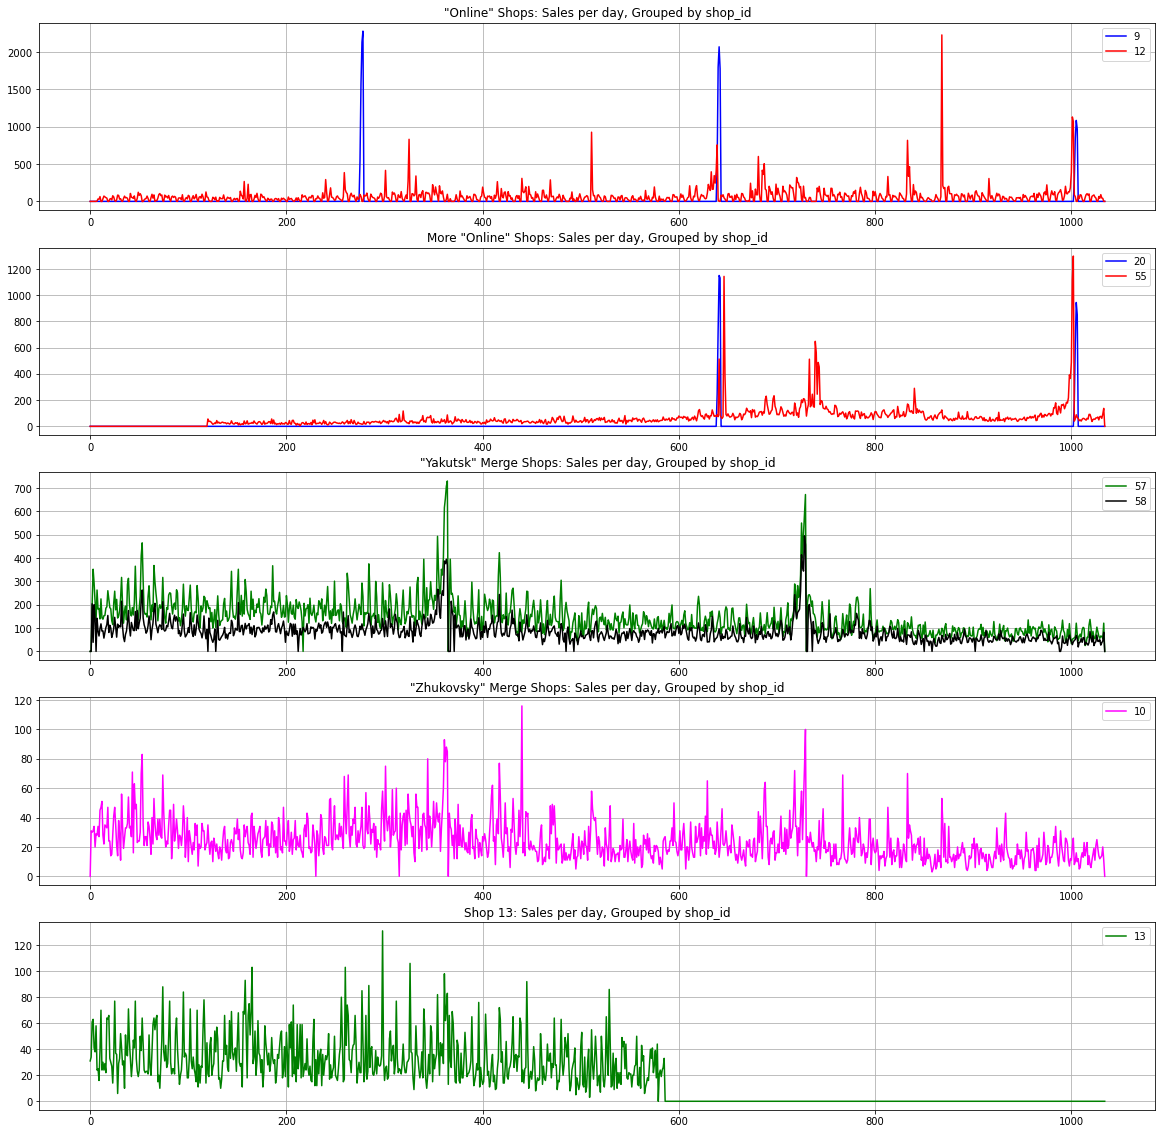

In [27]:
'''
Line Plot Inputs & Parameters
'''
categories_online = [9,12] #[9,12,20,40,55]  # x-axis is index (time period)
categories_online2 = [20,55]
categories_yak = [57,58] #,58] #[0,57,1,58]
categories_z = [10] #10,11]
categories_13 = [13]
colors_online = pltcolors[:2]
colors_online2 = pltcolors[:2]
colors_yak = pltcolors[2:4]
colors_z = pltcolors[5]
colors_13 = pltcolors[2]
# if desired, set axis limits using bool or tuple:
line_plot_x = False  # False uses auto-scale
line_plot_y = False #(-10,1000)

print(f'Plotted at: {strftime("%a %X %x")}\n')

'''
Generate the Plots
'''
fig = plt.figure(figsize=(20,20)) 
axOnline = fig.add_subplot(5,1,1)
axOnline.set_title(f'"Online" Shops: Sales per day, Grouped by shop_id')
axOnline2 = fig.add_subplot(5,1,2)
axOnline2.set_title(f'More "Online" Shops: Sales per day, Grouped by shop_id')
axYak = fig.add_subplot(5,1,3)
axYak.set_title(f'"Yakutsk" Merge Shops: Sales per day, Grouped by shop_id')
axZ = fig.add_subplot(5,1,4)
axZ.set_title(f'"Zhukovsky" Merge Shops: Sales per day, Grouped by shop_id')
ax13 = fig.add_subplot(5,1,5)
ax13.set_title(f'Shop 13: Sales per day, Grouped by shop_id')

day_shop_piv.plot(y=categories_online, kind='line',color=colors_online,grid=True, ax=axOnline)
day_shop_piv.plot(y=categories_online2, kind='line',color=colors_online2,grid=True, ax=axOnline2)
day_shop_piv.plot(y=categories_yak, kind='line',color=colors_yak,grid=True, ax=axYak)
day_shop_piv.plot(y=categories_z, kind='line',color=colors_z,grid=True, ax=axZ)
day_shop_piv.plot(y=categories_13, kind='line',color=colors_13,grid=True, ax=ax13)

plt.show()

##Some EDA related to sales by day for all stores

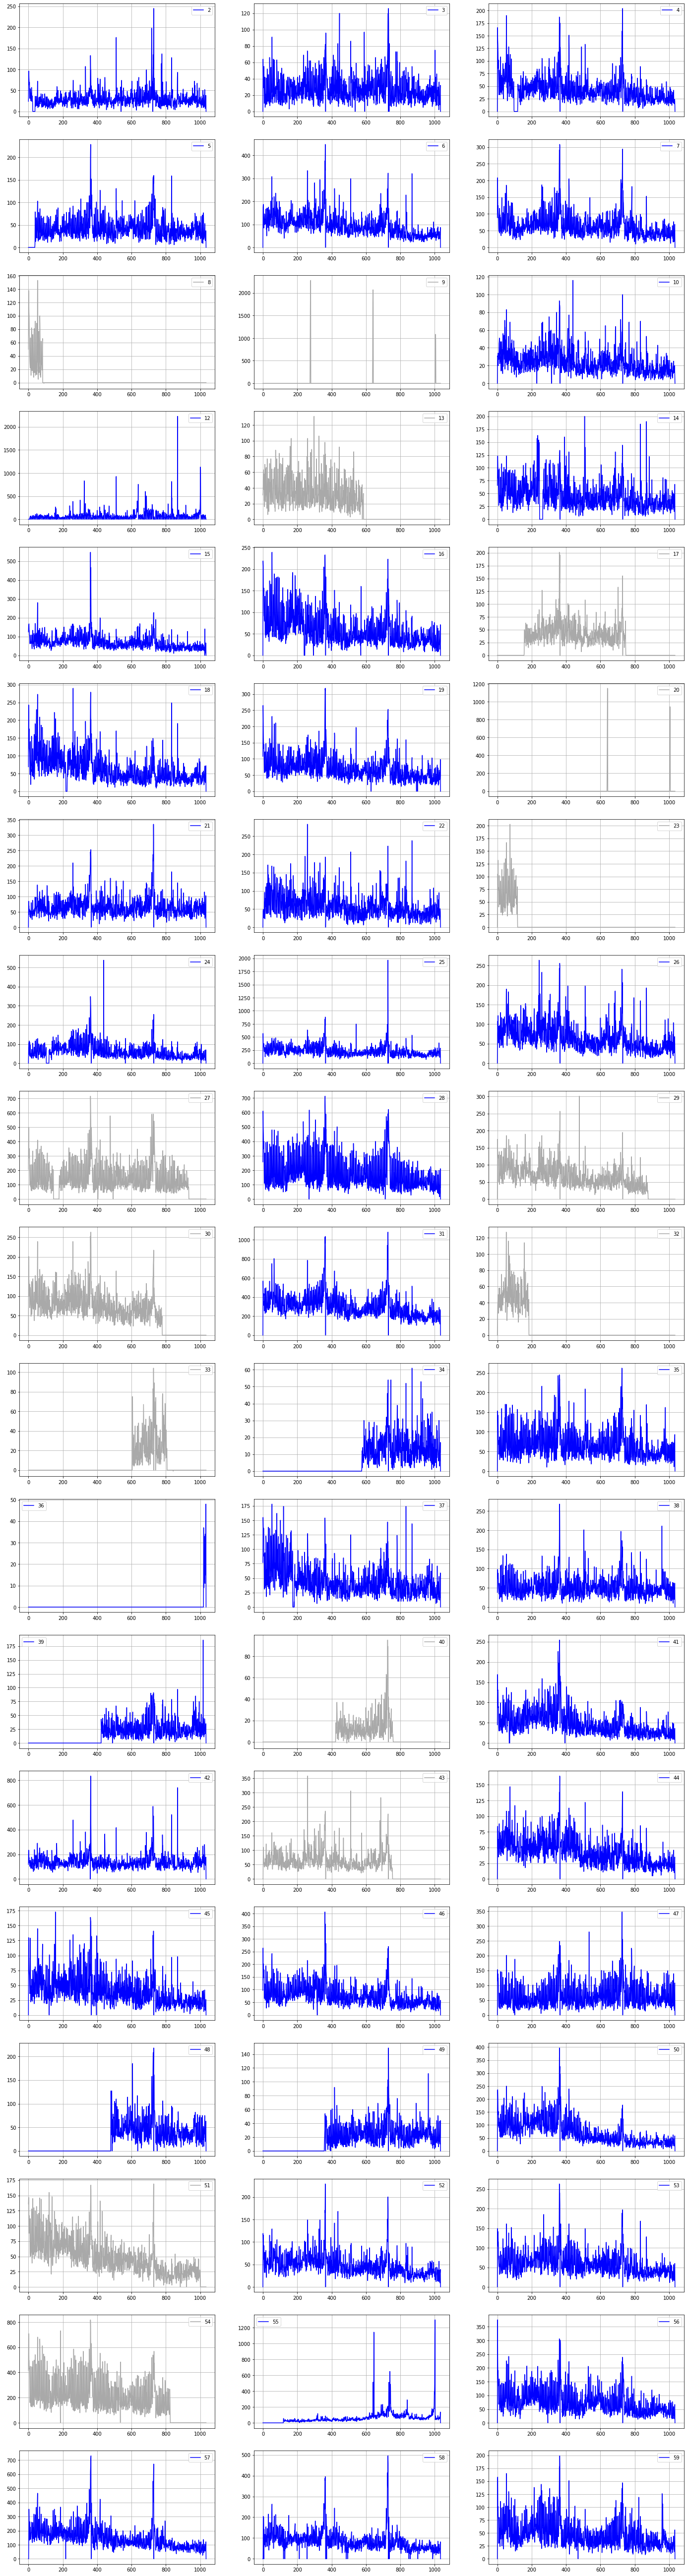

In [28]:
# plot every one of the shops' sales by day, and see if there are any other interesting things ...
'''
Line Plot Inputs & Parameters
'''
n_shops = 60
shops_list = list(range(n_shops))
# remove the shops that were merged
shops_list.remove(0)
shops_list.remove(1)
shops_list.remove(11)

ax = []
n_plot_cols = 3
n_plot_rows = 19

fig = plt.figure(figsize=(8*n_plot_cols, 5*n_plot_rows))
plotcount = 1
for s in shops_list:
    pltcolor='blue'
    if not shops_augmented.at[s,'shop_tested']:
        pltcolor = 'darkgray'
    ax.append(fig.add_subplot(n_plot_rows,n_plot_cols,plotcount))
    day_shop_piv.plot(y=[s],kind='line',color=pltcolor,grid=True,ax=ax[-1])
    plotcount += 1

#8, 23 into 55, 32, 33

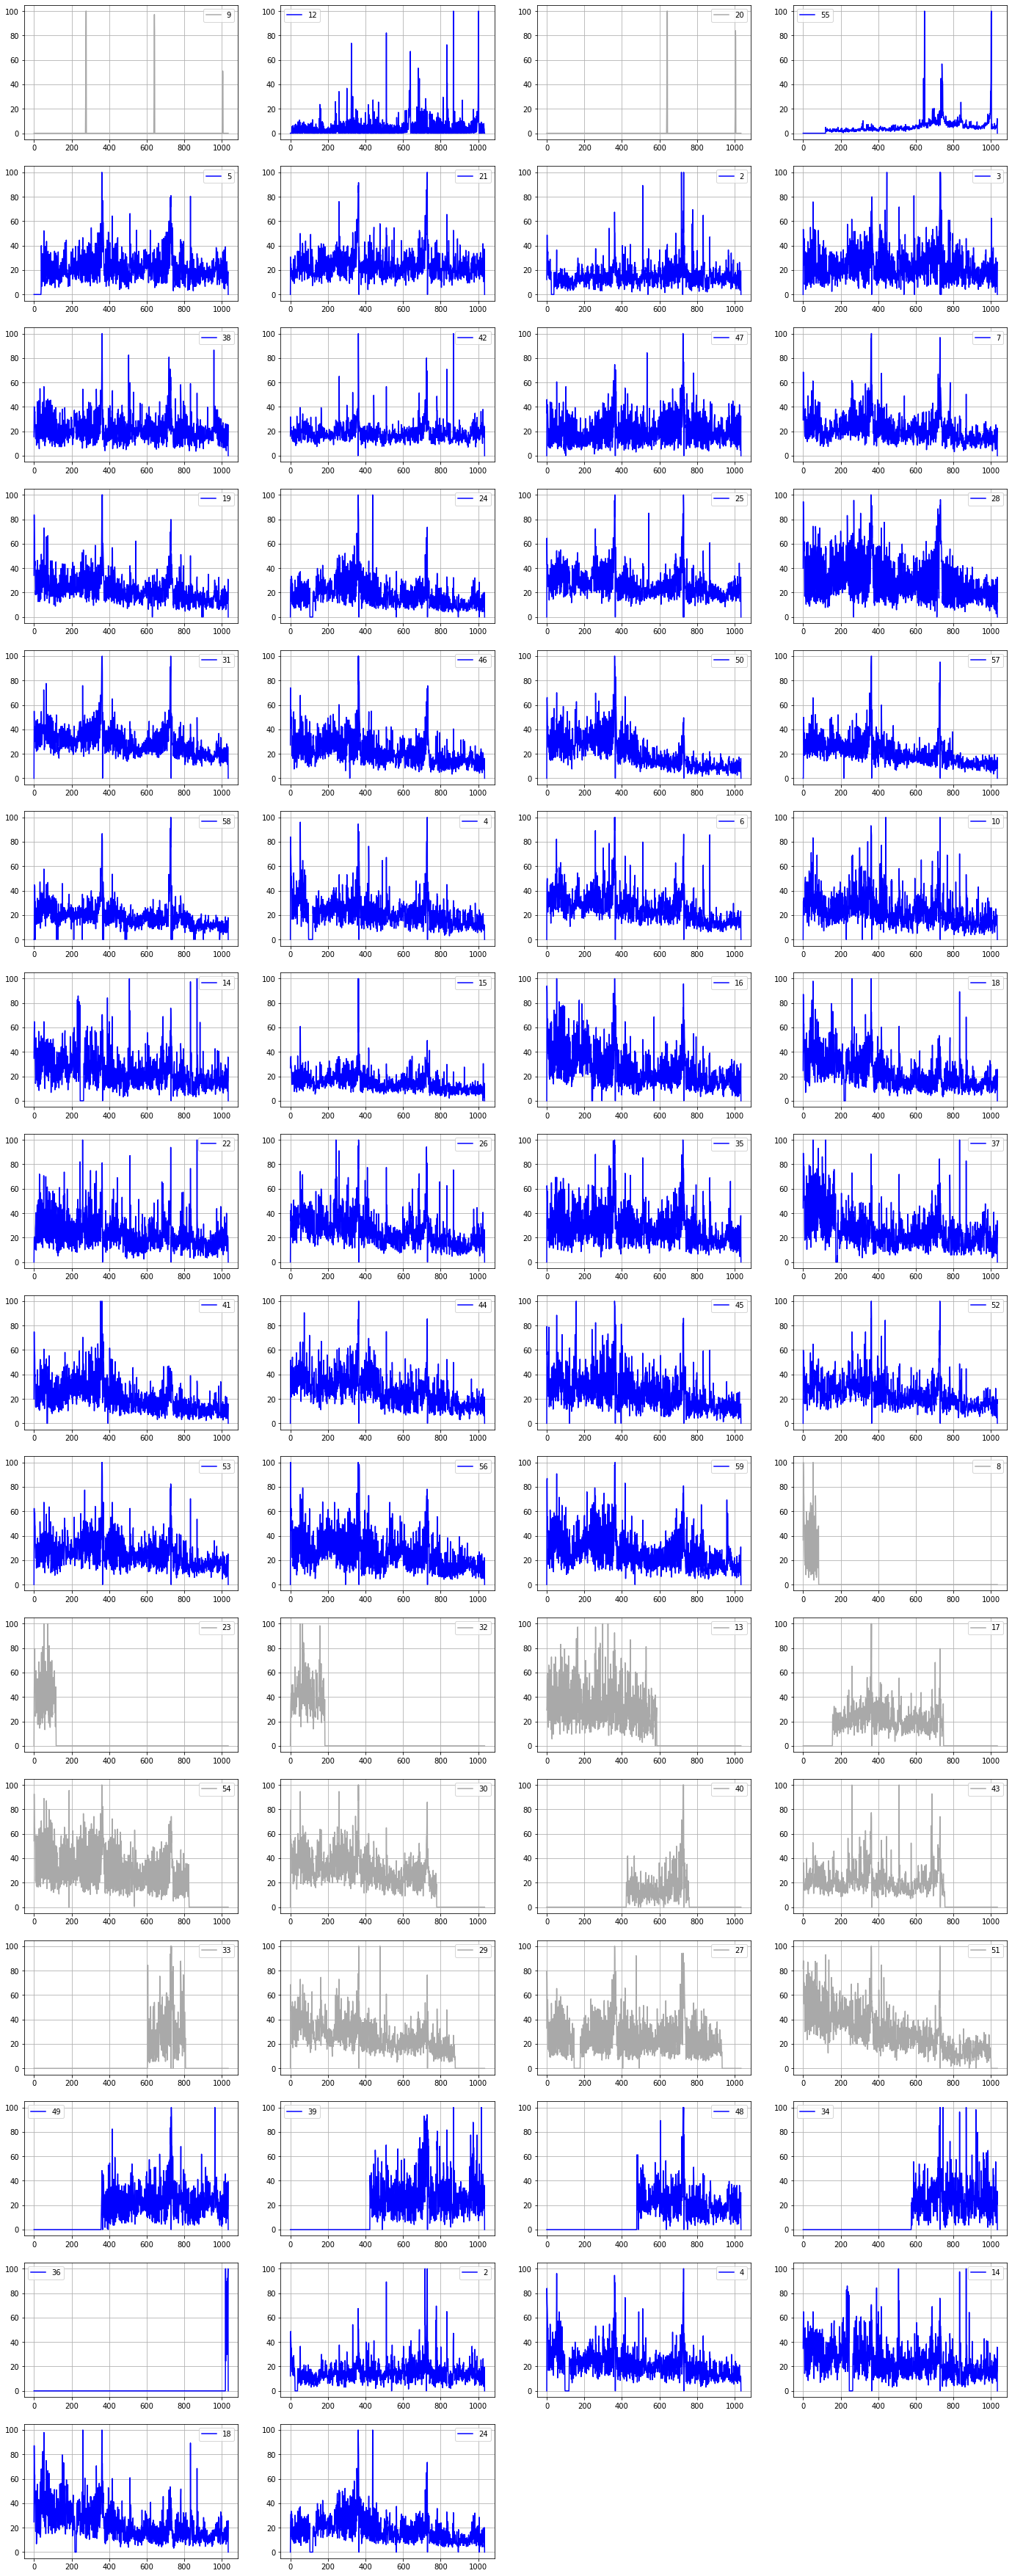

In [31]:
# plot every one of the shops' sales by day, and see if there are any other interesting things ...
#     but, this time, try applying a min-max scaler, after clipping values to 99th ptile (to reduce the impact of anomalous spikes on scaling)
#     also, group some of the plots together by their characteristic spikiness, negative slope, etc.

# shop groups
extreme_spikes = [9, 12, 20, 55]       # so spiky that you can't tell if there is any slope
flat_spiky = [2, 3, 38, 42, 47]     # flat slope, spiky/noisy behavior
flat_ny = [5, 21]                   # flat slope, with dominant surges at New Year
neg_spiky = [4, 6, 10, 14, 15, 16, 18, 22, 26, 35, 37, 41, 44, 45, 52, 53, 56, 59]
neg_ny = [7, 19, 24, 25, 28, 31, 46, 50, 57, 58]
partial = [8, 23, 32, 13, 17, 54, 30, 40, 43, 33, 29, 27, 51, 49, 39, 48, 34, 36]  # shops that don't show sales over the full range of days in months 0 to 33
dropouts = [2, 4, 14, 18, 24]       # shops that have small but significant no-sales regions in the middle of their sales windows

shops_list = extreme_spikes + flat_ny + flat_spiky + neg_ny + neg_spiky + partial + dropouts
# = 62 shops in this list (dropouts are repeat plots)

'''
Line Plot Inputs & Parameters
'''
ax = []
n_plot_cols = 4
n_plot_rows = 16

fig = plt.figure(figsize=(6*n_plot_cols, 4*n_plot_rows))
plotcount = 1
for s in shops_list:
    pltcolor='blue'
    if not shops_augmented.at[s,'shop_tested']:
        pltcolor = 'darkgray'
    ax.append(fig.add_subplot(n_plot_rows,n_plot_cols,plotcount))
    day_shop_piv_sc.plot(y=[s],kind='line',color=pltcolor,grid=True,ax=ax[-1])
    plotcount += 1


In [32]:
# Can we just dump #9, #20?
spiky9_20 = tt[['day','DoM','month','price','sales','shop_id','item_id','item_name','it_test','item_category_id','item_category_name','it_cat_test']].query('(shop_id == 9)|(shop_id == 20)').copy(deep=True)
spiky9_20.price = spiky9_20.price.apply(lambda x: round(x) if (x > 10) else x)
spiky9_20.item_name = spiky9_20.item_name.apply(lambda x: x[:30])
spiky9_20.item_category_name = spiky9_20.item_category_name.apply(lambda x: x[:25])
spiky9_20 = spiky9_20.rename(columns={'DoM':'DoM','item_category_id':'icatID','it_cat_test':'ic_test'})
print(spiky9_20, '\n')
#print(spiky9_20.value_counts())
# for c in spiky9_20.columns: display(spiky9_20[c].value_counts().to_frame())
# print('\n')
# print(spiky9_20.apply(lambda x: x.value_counts()).T.stack())
# almost every sale is in October 2013, 2014, 2015, and sales reported only on days of month = 1,2,3,4,5,6  (with 1 sale each on day of month 14 and 22)
# 1664 different item IDs, although item_name[:30] only has 1394 unique values;  of the reported individual sales, 2511 have items that are not tested, and 3032 have items that are tested
# sales are primarily in the gifts-souvenirs categories, then pc/console games  .... 13 of the sales involved categories are not in the test set, whereas 5530 of the sales involved categories in the test set

# As essentially all sales from 9 and 20 are in October, and these 2 shops are not in the test set, the sales_train rows for these two shops are irrelevant on their own
#   We should keep them only if they form a significant fraction of the sales_train rows for a certain item or category that is in the test set --> look at Oct 2015, maybe also Oct 2014
#   or, if we can determine that lag=1 month for these shops 9,20 is very helpful in predicting sales of other shops (in November) --> look at Oct/Nov 2014

# from IPython.core.display import display, HTML

# def display_side_by_side(dfs:list, captions:list):
#     """Display tables side by side to save vertical space
#     Input:
#         dfs: list of pandas.DataFrame
#         captions: list of table captions
#     """
#     output = ""
#     combined = dict(zip(captions, dfs))
#     for caption, df in combined.items():
#         output += df.style.set_table_attributes("style='display:inline'").set_caption(caption)._repr_html_()
#         output += "\xa0\xa0\xa0"
#     display(HTML(output))
# display_side_by_side([df1, df2, df3], ['caption1', 'caption2', 'caption3'])

from IPython.display import display_html 

df1_styler = spiky9_20['DoM'].value_counts().to_frame().style.set_table_attributes("style='display:inline'").set_caption('Day of Month')
df2_styler = spiky9_20['month'].value_counts().to_frame().style.set_table_attributes("style='display:inline'").set_caption('Month Block')
df3_styler = spiky9_20['it_test'].value_counts().to_frame().style.set_table_attributes("style='display:inline'").set_caption('Item Tested')
df4_styler = spiky9_20['item_id'].value_counts().to_frame().iloc[:15,:].style.set_table_attributes("style='display:inline'").set_caption('Item ID')
df5_styler = spiky9_20['item_category_name'].value_counts().to_frame().iloc[:15,:].style.set_table_attributes("style='display:inline'").set_caption('Item Category Name')
df6_styler = spiky9_20['icatID'].value_counts().to_frame().iloc[:15,:].style.set_table_attributes("style='display:inline'").set_caption('Item Cat ID')
df7_styler = spiky9_20['ic_test'].value_counts().to_frame().style.set_table_attributes("style='display:inline'").set_caption('Item Cat Tested')

display_html(df1_styler._repr_html_() + "\xa0\xa0\xa0" +
             df2_styler._repr_html_() + "\xa0\xa0\xa0" +
             df3_styler._repr_html_() + "\xa0\xa0\xa0" +
             df4_styler._repr_html_() + "\xa0\xa0\xa0" +
             df5_styler._repr_html_() + "\xa0\xa0\xa0" +
             df6_styler._repr_html_() + "\xa0\xa0\xa0" +
             df7_styler._repr_html_(), raw=True)

          day  DoM  month  price  sales  shop_id  item_id                       item_name  it_test  icatID         item_category_name  ic_test
938244    275    3      9    599      7        9     1448  Arma lll [PC, Russian subtitle    False      28  Games PC - Additional pub     True
938245    275    3      9    299      6        9     1516  Assassin's Creed IV. Black fla    False      30  Games PC - Standard Editi     True
938246    275    3      9    249      1        9     1915  Bestseller. S.T.A.L.K.E.R. [PC    False      30  Games PC - Standard Editi     True
938247    275    3      9    249      2        9     1916  Bestseller. Sid Meier's Civili     True      30  Games PC - Standard Editi     True
938248    275    3      9    599      1        9     1937  BioShock Infinite [PC, Jewel,     False      30  Games PC - Standard Editi     True
...       ...  ...    ...    ...    ...      ...      ...                             ...      ...     ...                        ...      ...

Day of Month DoM 
 
 4 
 1630 
 
 
 3 
 1362 
 
 
 5 
 1097 
 
 
 2 
 776 
 
 
 6 
 426 
 
 
 1 
 250 
 
 
 22 
 1 
 
 
 14 
 1 
 
     Month Block month 
 
 21 
 2362 
 
 
 33 
 1692 
 
 
 9 
 1488 
 
 
 27 
 1 
 
     Item Tested it_test 
 
 True 
 3032 
 
 
 False 
 2511 
 
     Item ID item_id 
 
 15213 
 16 
 
 
 15304 
 16 
 
 
 15261 
 15 
 
 
 11526 
 13 
 
 
 15279 
 13 
 
 
 9355 
 13 
 
 
 15262 
 13 
 
 
 15284 
 13 
 
 
 21119 
 12 
 
 
 15052 
 12 
 
 
 20735 
 12 
 
 
 20739 
 12 
 
 
 20350 
 12 
 
 
 20608 
 12 
 
 
 16264 
 11 
 
     Item Category Name item_category_name 
 
 Gifts - Attributes 
 1461 
 
 
 Gifts - Figures 
 878 
 
 
 Gifts - Soft Toys 
 589 
 
 
 Gifts - Souvenirs (weighe 
 452 
 
 
 Games PC - Standard Editi 
 379 
 
 
 Gifts - Souvenirs 
 346 
 
 
 Games - PS3 
 257 
 
 
 Books - Comics, Manga 
 198 
 
 
 Games - XBOX 360 
 195 
 
 
 Games PC - Additional pub 
 102 
 
 
 Gifts - Games (compact) 
 83 
 
 
 Games - PS4 
 70 
 
 
 Gifts - Board Games 
 56 
 
 
 Books - artbook, encyclop 
 55 
 
 
 Gifts - gadgets, robots, 
 45 
 
     Item Cat ID icatID 
 
 61 
 1461 
 
 
 72 
 878 
 
 
 63 
 589 
 
 
 70 
 452 
 
 
 30 
 379 
 
 
 69 
 346 
 
 
 19 
 257 
 
 
 47 
 198 
 
 
 23 
 195 
 
 
 28 
 102 
 
 
 65 
 83 
 
 
 20 
 70 
 
 
 64 
 56 
 
 
 42 
 55 
 
 
 62 
 45 
 
     Item Cat Tested ic_test 
 
 True 
 5530 
 
 
 False 
 13

In [34]:
# separate out the sales of items found in shops 9, 20 sales, and see how the sales look for other shops
spiky9_20_items = spiky9_20.item_id.unique()
tt_spiky_items = tt[tt.item_id.isin(spiky9_20_items)].copy(deep=True)
display(tt_spiky_items.describe())
print(tt_spiky_items.item_id.nunique())

spiky_items = tt_spiky_items.groupby(['day','shop_id']).agg({'month':'mean', 'week':'mean','DoM':'mean','sales':'sum'}).reset_index()
spiky_items = spiky_items.pivot(index='day',columns='shop_id',values='sales').reset_index().rename_axis("",axis=1).fillna(0)
print('\n',spiky_items.shape)
display(spiky_items.head())
display(spiky_items.describe())

day  day_of_month   week  quarter  season  month     price  sales  shop_id   item_id  item_category_id    population
count  808376        808376 808376   808376  808376 808376    808376 808376   808376    808376            808376        808376
mean  516.151        16.489 73.586    5.834   1.479 16.484 1,223.185  1.238   32.339 8,416.683            34.605 3,983,407.795
std   284.317         9.247 40.642    3.137   1.117  9.308 2,076.566  1.763   16.311 5,838.988            19.743 4,882,251.591
min         0             1      0        0       0      0         0     -6        2      1407                 2         61000
25%       289             8     41        3       0      9       399      1       20      3732                22        314900
50%       509            17     73        6       1     16       799      1       31      6466                30       1033338
75%       727            25    104        8       2     23      1499      1       47     13675                41      10381222
max      1063            31    152       12       3     34     35990    288       59     22102                83      20000000

1664

 (1035, 58)


day  2  3  4  5  6  7  8  9  10  12  13  14  ...  47  48  49  50  51  52  53  54  55  56  57  58  59
0    0  4  0  0  0  0 16  3  0   0   0   0  20  ...   0   0   0   0  23   0   0  67   0   0   0   0   0
1    1 19 14 30  0 36 45 24  0   4   0   4  29  ...  24   0   0  53  22  18  40 108   0  48   0   0  35
2    2 25  7 24  0 49 26 26  0  10   0   4  32  ...  23   0   0  47   9  21  27  81   0  48  29  30  37
3    3 13  9 31  0 39 24 18  0   5   0   2  30  ...  26   0   0  50   9  17  28  69   0  21  54  12  24
4    4 10  7 27  0 39 30 19  0   4   0   0  19  ...  31   0   0  33   9   8  31  82   0  18  34  30  22

[5 rows x 58 columns]

day      2     3      4      5      6      7     8       9    10     12    13     14  ...     47     48    49     50    51     52     53     54   55     56     57     58     59
count    1035   1035  1035   1035   1035   1035   1035  1035    1035  1035   1035  1035   1035  ...   1035   1035  1035   1035  1035   1035   1035   1035 1035   1035   1035   1035   1035
mean  517.028 12.155 9.860 14.328 13.145 26.542 21.214 0.630  15.329 7.070 13.016 1.921 14.805  ... 23.338  8.927 6.263 22.575 8.847 15.174 20.040 39.900    0 16.964 30.561 22.450 15.306
std   298.973  9.985 7.571 10.369  9.865 19.908 15.510 2.803 158.881 5.382 20.505 3.032 12.781  ... 17.195 12.518 7.629 18.512 6.933 10.756 13.382 35.865    0 12.678 24.264 18.278 10.826
min         0      0     0      0      0      0      0    -1      -1     0     -2     0      0  ...      0      0     0      0     0      0      0      0    0      0      0      0      0
25%   258.500      6     5      8      7     15     12     0       0     3      0     0      7  ...     11      0     0     10     5      8     11     17    0      9     17     13      8
50%       517     10     8     12     11     22     17     0       0     6      7     0     12  ...     19      4     4     18     7     13     16     32    0     14     26     19     12
75%   775.500     15    13     19     17     32     26     0       0     9     17     3     19  ...     30 14.500    10     29    11     19     26     59    0     22     36     27     19
max      1063    114    67     91     73    248    134    28    2279    44    234    44    117  ...    135    101    63    160    60    106    104    261    0    107    286    205     87

[8 rows x 58 columns]

Shop sales for only those items sold by shops 9 and 20:



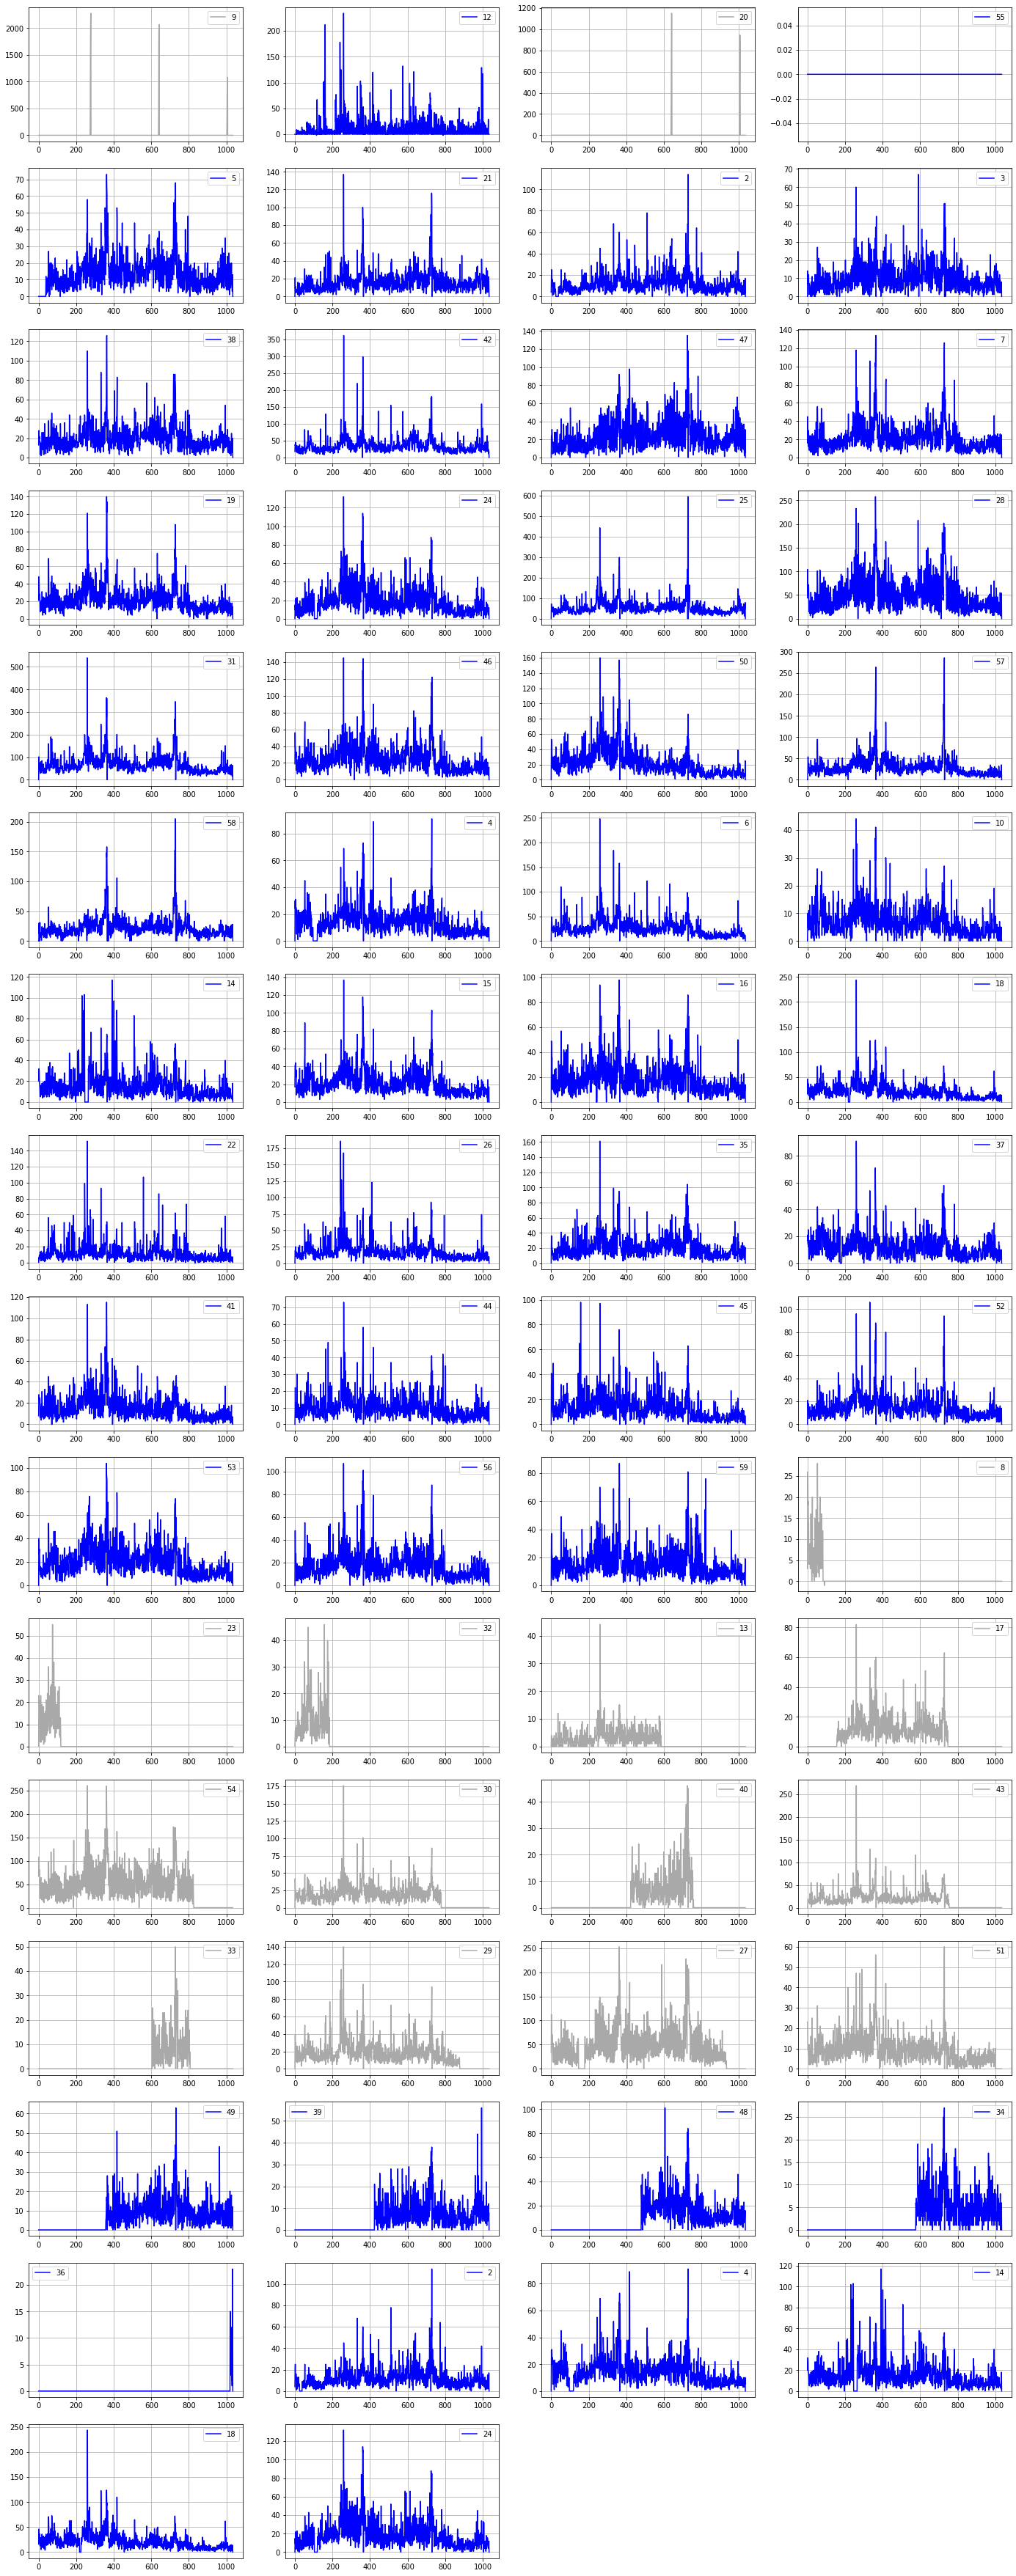

In [35]:
# plot every one of the shops' sales by day, and see if there are any other interesting things ...
print("Shop sales for only those items sold by shops 9 and 20:\n")
# Group some of the plots together by their characteristic spikiness, negative slope, etc.

# shop groups
extreme_spikes = [9, 12, 20, 55]       # so spiky that you can't tell if there is any slope
flat_spiky = [2, 3, 38, 42, 47]     # flat slope, spiky/noisy behavior
flat_ny = [5, 21]                   # flat slope, with dominant surges at New Year
neg_spiky = [4, 6, 10, 14, 15, 16, 18, 22, 26, 35, 37, 41, 44, 45, 52, 53, 56, 59]
neg_ny = [7, 19, 24, 25, 28, 31, 46, 50, 57, 58]
partial = [8, 23, 32, 13, 17, 54, 30, 40, 43, 33, 29, 27, 51, 49, 39, 48, 34, 36]  # shops that don't show sales over the full range of days in months 0 to 33
dropouts = [2, 4, 14, 18, 24]       # shops that have small but significant no-sales regions in the middle of their sales windows

shops_list = extreme_spikes + flat_ny + flat_spiky + neg_ny + neg_spiky + partial + dropouts
# = 62 shops in this list (dropouts are repeat plots)

'''
Line Plot Inputs & Parameters
'''
ax = []
n_plot_cols = 4
n_plot_rows = 16

fig = plt.figure(figsize=(6*n_plot_cols, 4*n_plot_rows))
plotcount = 1
for s in shops_list:
    pltcolor='blue'
    if not shops_augmented.at[s,'shop_tested']:
        pltcolor = 'darkgray'
    ax.append(fig.add_subplot(n_plot_rows,n_plot_cols,plotcount))
    spiky_items.plot(y=[s],kind='line',color=pltcolor,grid=True,ax=ax[-1])
    plotcount += 1


# There seems to be some correlation with sales at the other shops, primarily around day 275, but no obvious predictive power
#   It's probably safe to delete shops 9 and 20;  55 looks like it should be alone in its own category

In [36]:
# Can we assist training of shop 36, as it only has sales at the very end of the time period?
#  Let's consider 36 vs. 37 (both are shops from Novosibirsk) and other shops
siberian = [36,37,48] #[17, 18, 36, 37, 38, 48]
novo = tt[['day','DoM','month','price','sales','shop_id','item_id','item_name','it_test','item_category_id','item_category_name','it_cat_test']].copy(deep=True)
novo = novo[novo.shop_id.isin(siberian)]
novo.price = novo.price.apply(lambda x: round(x) if (x > 10) else x)
novo.item_name = novo.item_name.apply(lambda x: x[:30])
novo.item_category_name = novo.item_category_name.apply(lambda x: x[:25])
novo = novo.rename(columns={'DoM':'DoM','item_category_id':'icatID','it_cat_test':'ic_test'})
display(novo.head())
print('\n')

from IPython.display import display_html 

df1_styler = novo['DoM'].value_counts().to_frame().style.set_table_attributes("style='display:inline'").set_caption('Day of Month')
df2_styler = novo['month'].value_counts().to_frame().style.set_table_attributes("style='display:inline'").set_caption('Month Block')
df3_styler = novo['it_test'].value_counts().to_frame().style.set_table_attributes("style='display:inline'").set_caption('Item Tested')
df4_styler = novo['item_id'].value_counts().to_frame().iloc[:15,:].style.set_table_attributes("style='display:inline'").set_caption('Item ID')
df5_styler = novo['item_category_name'].value_counts().to_frame().iloc[:15,:].style.set_table_attributes("style='display:inline'").set_caption('Item Category Name')
df6_styler = novo['icatID'].value_counts().to_frame().iloc[:15,:].style.set_table_attributes("style='display:inline'").set_caption('Item Cat ID')
df7_styler = novo['ic_test'].value_counts().to_frame().style.set_table_attributes("style='display:inline'").set_caption('Item Cat Tested')

display_html(df1_styler._repr_html_() + "\xa0\xa0\xa0" +
             df2_styler._repr_html_() + "\xa0\xa0\xa0" +
             df3_styler._repr_html_() + "\xa0\xa0\xa0" +
             df4_styler._repr_html_() + "\xa0\xa0\xa0" +
             df5_styler._repr_html_() + "\xa0\xa0\xa0" +
             df6_styler._repr_html_() + "\xa0\xa0\xa0" +
             df7_styler._repr_html_(), raw=True)

day  DoM  month  price  sales  shop_id  item_id                       item_name  it_test  icatID         item_category_name  ic_test
900    0    1      0    399      1       37       98            1812: Lancers BALLAD    False      40                Movie - DVD     True
901    0    1      0    199      1       37      560  1C: Education collection. Engl     True      77      Program - Educational     True
902    0    1      0    149      2       37      657  1C: Education collection. The     False      77      Program - Educational     True
903    0    1      0    599      1       37     1470  Assassin's Creed 3 [PC, Jewel,    False      30  Games PC - Standard Editi     True
904    0    1      0   1249      1       37     1713  BLACKMORE`S NIGHT A Knight In     False      58              Music - Vinyl     True

Day of Month DoM 
 
 30 
 17249 
 
 
 27 
 2249 
 
 
 2 
 2218 
 
 
 23 
 2201 
 
 
 28 
 2175 
 
 
 1 
 2111 
 
 
 21 
 2106 
 
 
 26 
 2099 
 
 
 17 
 2061 
 
 
 6 
 2041 
 
 
 3 
 2031 
 
 
 22 
 2024 
 
 
 9 
 2002 
 
 
 19 
 1999 
 
 
 4 
 1983 
 
 
 20 
 1982 
 
 
 5 
 1981 
 
 
 10 
 1980 
 
 
 24 
 1972 
 
 
 7 
 1963 
 
 
 13 
 1958 
 
 
 18 
 1933 
 
 
 8 
 1922 
 
 
 12 
 1903 
 
 
 14 
 1892 
 
 
 25 
 1890 
 
 
 11 
 1885 
 
 
 16 
 1844 
 
 
 29 
 1819 
 
 
 15 
 1785 
 
 
 31 
 1598 
 
     Month Block month 
 
 34 
 15300 
 
 
 23 
 3617 
 
 
 19 
 2537 
 
 
 22 
 2336 
 
 
 2 
 2330 
 
 
 31 
 2319 
 
 
 16 
 2313 
 
 
 24 
 2311 
 
 
 0 
 2241 
 
 
 18 
 2194 
 
 
 17 
 2178 
 
 
 21 
 2073 
 
 
 30 
 2017 
 
 
 1 
 1989 
 
 
 26 
 1989 
 
 
 20 
 1983 
 
 
 33 
 1949 
 
 
 25 
 1910 
 
 
 4 
 1884 
 
 
 32 
 1836 
 
 
 3 
 1818 
 
 
 29 
 1694 
 
 
 27 
 1685 
 
 
 28 
 1660 
 
 
 5 
 1507 
 
 
 11 
 1450 
 
 
 7 
 1279 
 
 
 8 
 1224 
 
 
 6 
 1182 
 
 
 15 
 1065 
 
 
 14 
 1036 
 
 
 12 
 1022 
 
 
 10 
 991 
 
 
 13 
 971 
 
 
 9 
 966 
 
     Item Tested it_test 
 
 True 
 52868 
 
 
 False 
 23988 
 
     Item ID item_id 
 
 20949 
 1170 
 
 
 17717 
 328 
 
 
 2808 
 248 
 
 
 6497 
 208 
 
 
 2308 
 191 
 
 
 6503 
 185 
 
 
 4351 
 168 
 
 
 4870 
 167 
 
 
 3734 
 161 
 
 
 4244 
 152 
 
 
 4181 
 146 
 
 
 6675 
 145 
 
 
 1855 
 131 
 
 
 3077 
 129 
 
 
 4248 
 127 
 
     Item Category Name item_category_name 
 
 Music - CD of local produ 
 12766 
 
 
 Games PC - Standard Editi 
 8984 
 
 
 Movie - DVD 
 8388 
 
 
 Movie - Blu-Ray 
 5212 
 
 
 Games - PS3 
 4919 
 
 
 Games - XBOX 360 
 4827 
 
 
 Games PC - Additional pub 
 3192 
 
 
 Games - PS4 
 2691 
 
 
 Gifts - Figures 
 2032 
 
 
 Gifts - Soft Toys 
 1397 
 
 
 Gifts - Games (compact) 
 1333 
 
 
 Movie - Blu-Ray 3D 
 1333 
 
 
 Gifts - Board Games 
 1185 
 
 
 Gifts - Bags, Albums, Mat 
 1170 
 
 
 Gifts - Souvenirs (weighe 
 1087 
 
     Item Cat ID icatID 
 
 55 
 12766 
 
 
 30 
 8984 
 
 
 40 
 8388 
 
 
 37 
 5212 
 
 
 19 
 4919 
 
 
 23 
 4827 
 
 
 28 
 3192 
 
 
 20 
 2691 
 
 
 72 
 2032 
 
 
 63 
 1397 
 
 
 38 
 1333 
 
 
 65 
 1333 
 
 
 64 
 1185 
 
 
 71 
 1170 
 
 
 70 
 1087 
 
     Item Cat Tested ic_test 
 
 True 
 76393 
 
 
 False 
 463

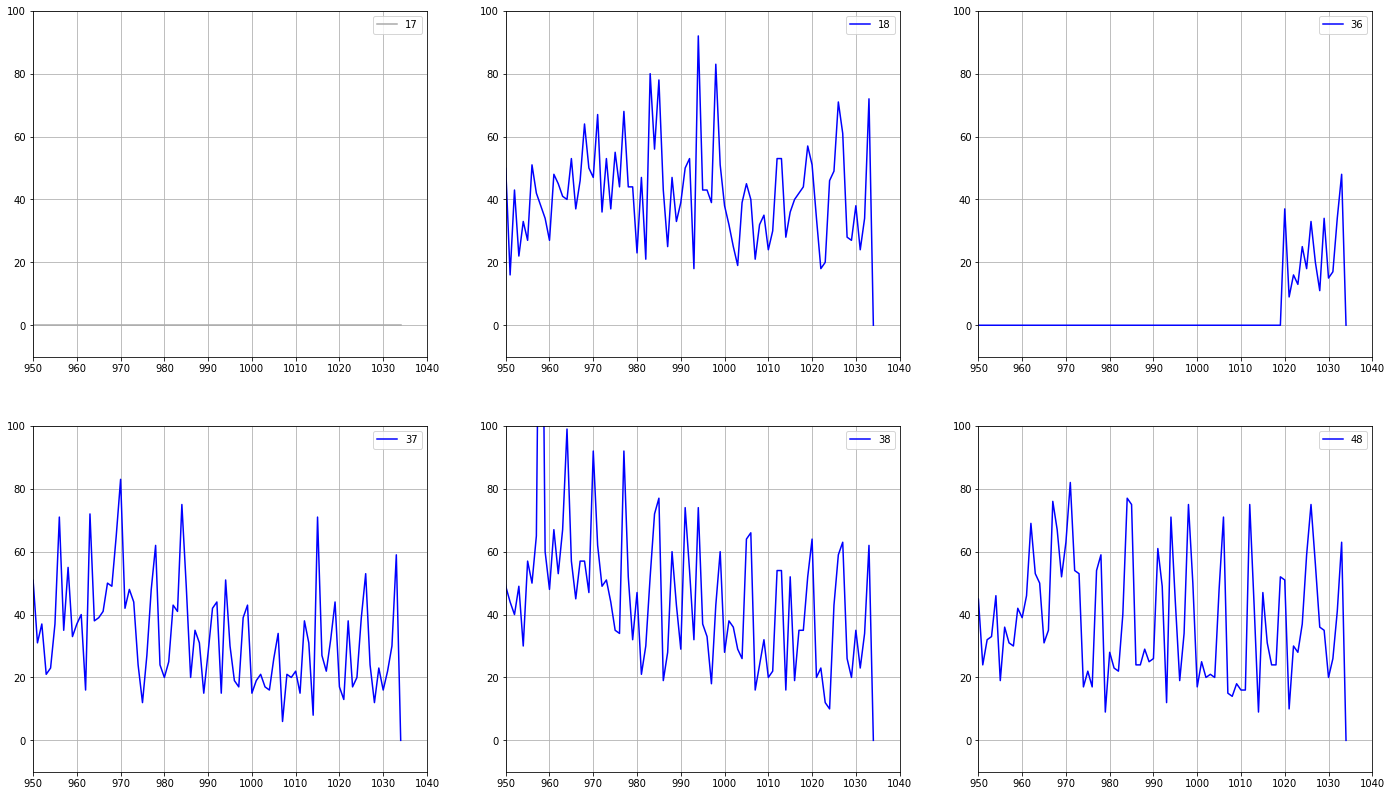

In [41]:
# plot every one of the Siberian shops' sales by day, and see if there are any other interesting things that can help us augment shop 36 (active only last 2 weeks or so) ...

# Group some of the plots together by their characteristic spikiness, negative slope, etc.

# shop groups
siberian = [17, 18, 36, 37, 38, 48]
shops_list = siberian #extreme_spikes + flat_ny + flat_spiky + neg_ny + neg_spiky + partial + dropouts
# = 6 shops in this list

'''
Line Plot Inputs & Parameters
'''
ax = []
n_plot_cols = 3
n_plot_rows = 2

fig = plt.figure(figsize=(8*n_plot_cols, 7*n_plot_rows))
plotcount = 1
for s in shops_list:
    pltcolor='blue'
    if not shops_augmented.at[s,'shop_tested']:
        pltcolor = 'darkgray'
    ax.append(fig.add_subplot(n_plot_rows,n_plot_cols,plotcount))
    day_shop_piv.plot(y=[s],kind='line',color=pltcolor,grid=True,ax=ax[-1])
    ax[-1].set_xlim(950,1040)
    ax[-1].set_ylim(-10,100)
    plotcount += 1


##Correlation shop-shop by item_id sales in full time period


In [42]:
# Start by setting desired parameters:

# before grouping:
daily_sales_max_clip = 20
daily_sales_min_clip = 0
drop_test_month = True

fillna0 = True                      # perform fillna(0) on dataframe before computing correlations between feature categories
correlation_threshold = 880         # 1000x the computed correlation coefficient; only pairs with correlation coefficients greater than this get included in cluster determination
corr_method = 'pearson'             # 'kendall' or 'pearson' or 'spearman'
min_samples_corr = 8
n_ids = len(shops_augmented)

group_time_period = 'item_id'
group_category = 'shop_id'
agg_column = 'sales'                # sum of this when grouping by the above
category_names = {'print':True, 'df':shops_augmented, 'column':'en_shop_name'}   # when printing out the final clusters, if print=True, use this dataframe and column to return the names (assuming row# = category id)

print(f'done: {strftime("%a %X %x")}\n')

done: Thu 18:39:13 06/11/20



In [44]:
# look at correlation between shops by # sales of each item (summed over full time period, scaled with min/max minus 99th ptile clip)
dfshop_item = tt.groupby(['shop_id','item_id']).agg({'month':'mean', 'week':'mean','DoM':'mean','sales':'sum'}).reset_index()
dfshop_item = dfshop_item.pivot(index='item_id',columns='shop_id',values='sales').reset_index().rename_axis("",axis=1).fillna(0)
# create a version of the table, using scaled versions of all categories, for easier comparison and normalized correlation
qt = dfshop_item.quantile(0.999)
sc = MinMaxScaler((0,100))
dfshop_item_sc = dfshop_item.copy(deep=True)
for sh in tt.shop_id.unique():
    dfshop_item_sc[sh] = dfshop_item_sc[sh].clip(0,qt[sh])
    dfshop_item_sc[sh] = sc.fit_transform(dfshop_item_sc[sh].to_numpy().reshape(-1,1))
dfshop_item_sc.index = dfshop_item_sc.item_id
dfshop_item_sc.drop('item_id',axis=1,inplace=True)
dfshop_item_sc.insert(0,0,0)
dfshop_item_sc.insert(1,1,0)
dfshop_item_sc.insert(11,11,0)
display(dfshop_item_sc.describe())
print('\n')
display(dfshop_item_sc.head())

0     1     2     3     4     5     6     7     8     9     10    11    12  ...    47    48      49    50    51    52    53    54    55    56    57    58    59
count 22169 22169 22169 22169 22169 22169 22169 22169 22169 22169 22169 22169 22169  ... 22169 22169   22169 22169 22169 22169 22169 22169 22169 22169 22169 22169 22169
mean      0     0 1.324 1.561 1.449 1.787 1.824 1.825 1.561 0.708 1.560     0 0.880  ... 1.774 1.488   1.645 2.160 2.406 1.563 1.664 3.021 0.650 2.437 2.613 2.094 1.522
std       0     0 6.083 6.314 5.809 6.304 5.791 6.543 7.153 5.166 5.984     0 4.777  ... 6.508 6.428   6.728 6.983 6.934 5.870 6.367 7.779 5.034 6.710 7.134 6.920 5.886
min       0     0     0     0     0     0     0     0     0     0     0     0     0  ...     0     0       0     0     0     0     0     0     0     0     0     0     0
25%       0     0     0     0     0     0     0     0     0     0     0     0     0  ...     0     0       0     0     0     0     0     0     0     0     0     0     0
50%       0     0     0     0     0     0 0.428     0     0     0     0     0     0  ...     0     0       0     0     0     0     0 0.782     0     0 0.400     0     0
75%       0     0     0     0 0.802 0.995 1.712 1.302     0     0 1.523     0 0.401  ... 1.274     0       0 1.335 2.321 0.736 0.651 2.738     0 2.206 2.400 1.112 0.740
max       0     0   100   100   100   100   100   100   100   100   100     0   100  ...   100   100 100.000   100   100   100   100   100   100   100   100   100   100

[8 rows x 60 columns]

0   1   2   3   4   5   6   7   8   9   10  11  12  ...  47  48  49  50  51  52  53    54    55  56  57  58  59
item_id                                                      ...                                                        
0         0   0   0   0   0   0   0   0   0   0   0   0   0  ...   0   0   0   0   0   0   0 0.391     0   0   0   0   0
1         0   0   0   0   0   0   0   0   0   0   0   0   0  ...   0   0   0   0   0   0   0     0 1.867   0   0   0   0
2         0   0   0   0   0   0   0   0   0   0   0   0   0  ...   0   0   0   0   0   0   0 0.782     0   0   0   0   0
3         0   0   0   0   0   0   0   0   0   0   0   0   0  ...   0   0   0   0   0   0   0 0.782     0   0   0   0   0
4         0   0   0   0   0   0   0   0   0   0   0   0   0  ...   0   0   0   0   0   0   0 0.391     0   0   0   0   0

[5 rows x 60 columns]

In [45]:
corr_method = 'pearson'
min_samples_corr = 4
si_corr_matrix = dfshop_item_sc.corr(method=corr_method, min_periods=min_samples_corr)

si_corr_matrix = round(si_corr_matrix * 1000)
si_corr_matrix = si_corr_matrix.apply(pd.to_numeric,  downcast='integer')

for i in range(si_corr_matrix.shape[0]):  #set diag to zeros
    si_corr_matrix.at[i,i] = 0
    
print(f'done: {strftime("%a %X %x")}\n')
print(dfshop_item_sc.shape)
print(si_corr_matrix.shape)
display(si_corr_matrix.head())

done: Thu 18:40:58 06/11/20

(22169, 60)
(60, 60)


0   1   2   3   4   5   6   7   8   9   10  11  12  ...  47  48  49  50  51  52  53  54  55  56  57  58  59
                                                       ...                                                    
0   0 nan nan nan nan nan nan nan nan nan nan nan nan  ... nan nan nan nan nan nan nan nan nan nan nan nan nan
1 nan   0 nan nan nan nan nan nan nan nan nan nan nan  ... nan nan nan nan nan nan nan nan nan nan nan nan nan
2 nan nan   0 840 810 812 783 853 270 385 785 nan 466  ... 865 770 769 806 617 760 805 659 -28 737 697 708 793
3 nan nan 840   0 846 871 814 873 335 392 813 nan 387  ... 882 753 751 851 674 793 867 775 -32 828 734 741 852
4 nan nan 810 846   0 866 834 910 401 380 861 nan 324  ... 835 692 673 854 751 860 894 728 -32 845 766 786 897

[5 rows x 60 columns]

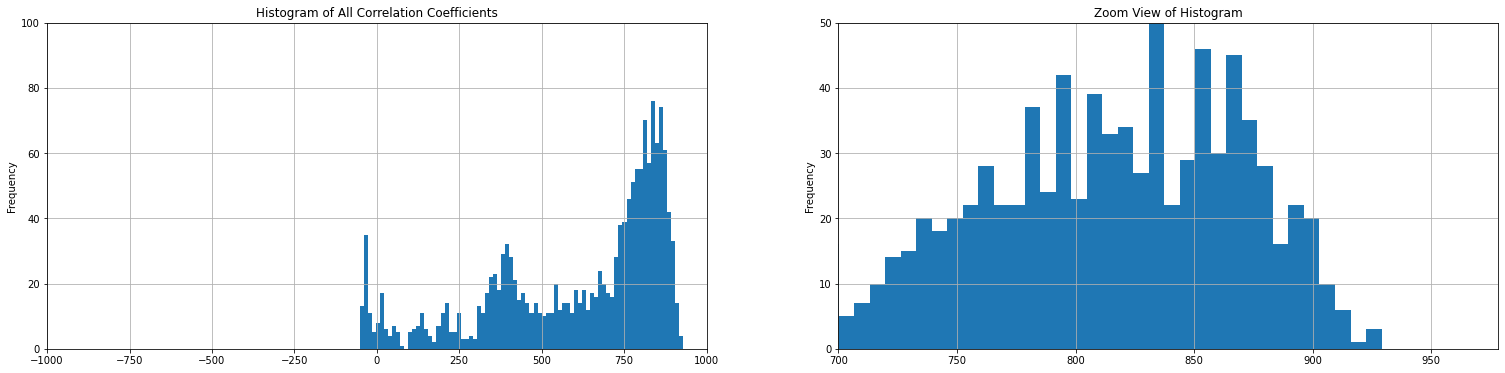

In [46]:
# plot histogram to see distribution of correlation coefficients
# first, remove duplicates (upper right correlation coeffs = lower left, mirrored on diagonal) and diagonal; replace with NaN so won't be counted in histogram
cm = si_corr_matrix.copy(deep=True)
for rnum in range(si_corr_matrix.shape[0]):
    cm.iloc[rnum,0:rnum+1] = np.NaN
# now, stack the columns so we have a single column for easy feed into histogram plot method:
cm = cm.stack().reset_index(drop=True)

fig = plt.figure(figsize=(26,6)) 
axTotal = fig.add_subplot(1,2,1)
axTotal.set_title(f'Histogram of All Correlation Coefficients')
axZoom = fig.add_subplot(1,2,2)
axZoom.set_title(f'Zoom View of Histogram')

cm.plot(kind='hist', grid=True, bins=80, ax=axTotal)
cm.plot(kind='hist', grid=True, bins=150,  ax=axZoom)

axTotal.set_xlim(-1000,1000)
axTotal.set_ylim(0,100)
axZoom.set_xlim(700,)
axZoom.set_ylim(0,50)
done=True

<IPython.core.display.Javascript object>

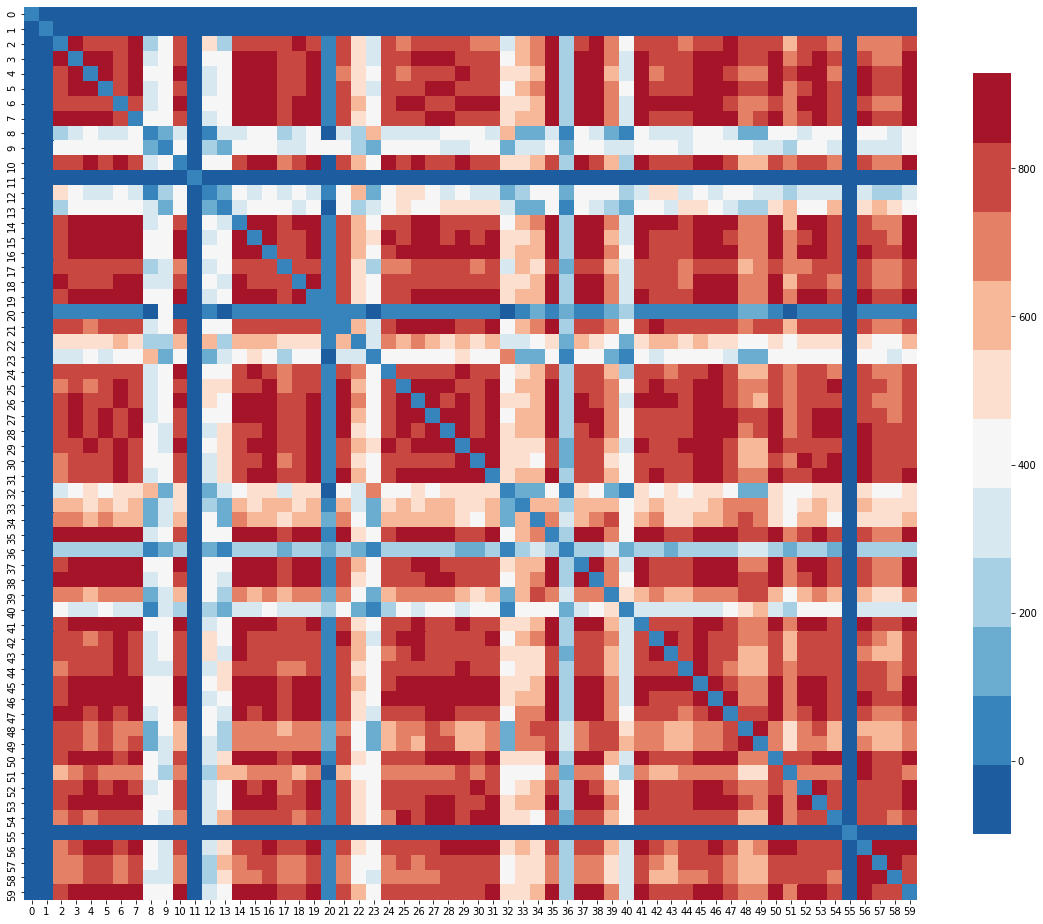

In [49]:
# heatmap of the correlation coefficients with row and column axes = category ids, in numerical order
plt.rcParams["figure.figsize"] = [20,20]
display(Javascript('''google.colab.output.setIframeHeight(0, true, {maxHeight: 5000})'''))
si_corr_matrix_fill = si_corr_matrix.fillna(-99)
h = sns.heatmap(si_corr_matrix_fill,
                cmap= sns.color_palette("RdBu_r", 11), #sns.diverging_palette( 30, 50, s=90, l=60, n=11, center="dark"), #'coolwarm',
                annot=False, #True,
                fmt= '.0g', #".1g", #".1f",
                annot_kws={'size':8},
                cbar=True,
                cbar_kws={"shrink": 0.7},
                square=True)
plt.show()

<IPython.core.display.Javascript object>

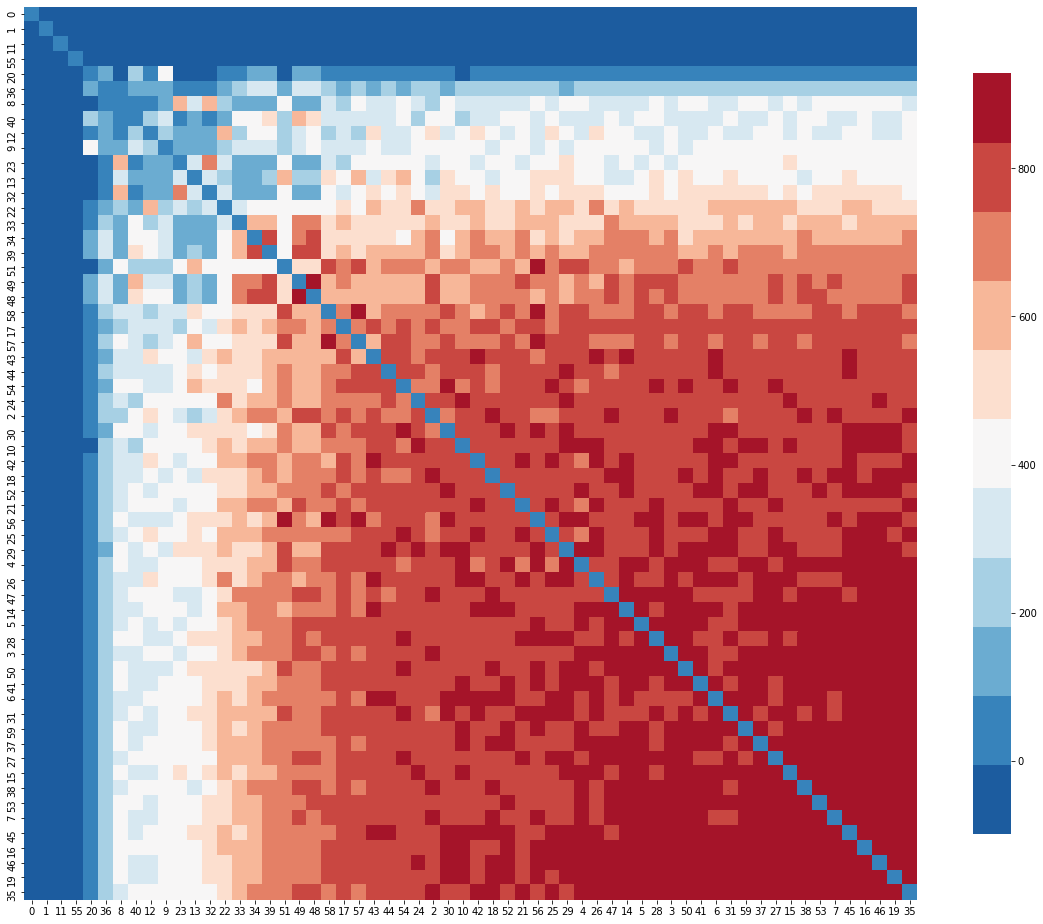

In [50]:
# look at a sorted version of the correlation matrix to see which items are most heavily correlated with others
#    sort by: sum of all correlation numbers in a column
df = si_corr_matrix_fill.copy(deep=True)#.reset_index(drop=True)
sortedidx = df.sum(axis=1).sort_values().index 
df = df.reindex(index=sortedidx, columns=sortedidx)
plt.rcParams["figure.figsize"] = [20,20]
display(Javascript('''google.colab.output.setIframeHeight(0, true, {maxHeight: 5000})'''))
h = sns.heatmap(df,
                cmap= sns.color_palette("RdBu_r", 11), #sns.diverging_palette( 30, 50, s=90, l=60, n=11, center="dark"), #'coolwarm',
                annot=False, #True,
                fmt= '.0g', #".1g", #".1f",
                annot_kws={'size':8},
                cbar=True,
                cbar_kws={"shrink": 0.7},
                square=True)
plt.show()

In [0]:
# i think it might be best to somehow use 34 or 48 to generate missing values of 36

In [51]:
corr_matrix_ids_masked = si_corr_matrix > correlation_threshold # gives a boolean matrix mask that is next used to populate df with the item_category_ids meeting the criteria
corr_matrix_ids_masked = corr_matrix_ids_masked.apply(lambda x: x * (x.index + 1))  # add 1 to be sure we get catcode=0; will subtract afterwards
    
friendliest = corr_matrix_ids_masked.nunique() - 1  #(-1 to remove irrelevant "unique" cat code = 0)
if friendliest.values.sum() > 0:
    friendliest = friendliest.sort_values(ascending=False).reset_index(name='n_close_corr_cats')
    print(f'Top 10 categories having most number of correlated categories meeting the threshold criterion:\n{friendliest[:10]}\n')
else:
    print('\n***********************************************')
    print('**  NO CATEGORIES MEET THE THRESHOLD LIMIT  ***')
    print('***********************************************\n')
#corr_matrix_ids_masked.head()

print(f'done: {strftime("%a %X %x")}\n')
corr_matrix_ids_masked.iloc[57:62,59:84]

Top 10 categories having most number of correlated categories meeting the threshold criterion:
       n_close_corr_cats
0  53                 15
1  46                 13
2  35                 13
3  19                 12
4   7                 12
5  15                 10
6  38                 10
7  45                  9
8  41                  8
9  59                  8

done: Thu 18:46:29 06/11/20



59
      
57   0
58   0
59   0

In [52]:
# create dataframe to make networkX graph (columns = node1, node2, edge_weight between node1 and node2)
if friendliest.values.sum() == 0:
    print('\n***********************************************')
    print('**  NO CATEGORIES MEET THE THRESHOLD LIMIT  ***')
    print('***********************************************\n')
else:
    cat_friends = pd.DataFrame({'category1':[x for x in range(n_ids) if corr_matrix_ids_masked[x].sum()>0]})
    cat_friends['category2'] = cat_friends.category1.apply(lambda x: [i-1 for i in corr_matrix_ids_masked[x].unique() if i != 0])  # subtract 1 to account for the addition of 1 above (so we wouldn't lose catid=0)
    cat_friends = cat_friends.explode('category2').reset_index(drop=True)
    cat_friends['weight'] = cat_friends.apply(lambda x: si_corr_matrix.at[x.category1,x.category2], axis=1)
    cat_friends = cat_friends[cat_friends.weight > 0].reset_index(drop=True)
    print(f'done: {strftime("%a %X %x")}\n')
    print(f'Number of pairs meeting the threshold limit: {len(cat_friends)}')
    unique_nodes = list(cat_friends.category1.unique()) + list(cat_friends.category2.unique())
    set_unique_nodes = set(unique_nodes)
    print(f'Number of unique category ids in the pairs meeting the threshold limit: {len(set_unique_nodes)}\n')
    print(cat_friends.head(10))

    # edge_threshold = correlation_threshold  # correlation*1000 (edge weight) must be greater than this for two item_ids to be connected in the graph
    # cat_friends = cat_friends[cat_friends.weight > edge_threshold]

    # import pandas df into weighted-edge graph:
    G = nx.from_pandas_edgelist(cat_friends, 'category1', 'category2', ['weight'])
    print(f'\nWeighted-edge graph G formation done: {strftime("%a %X %x")}\n')

done: Thu 18:47:26 06/11/20

Number of pairs meeting the threshold limit: 180
Number of unique category ids in the pairs meeting the threshold limit: 34

   category1 category2  weight
0          2        38     887
1          3        35     898
2          3        38     882
3          3        46     890
4          3        47     882
5          4         7     910
6          4        15     898
7          4        19     895
8          4        41     901
9          4        46     882

Weighted-edge graph G formation done: Thu 18:47:26 06/11/20



In [53]:
if friendliest.values.sum() == 0:
    print('\n***********************************************')
    print('**  NO CATEGORIES MEET THE THRESHOLD LIMIT  ***')
    print('***********************************************\n')
else:
    # employ a clustering method that utilizes the edge weights
    communities = community.asyn_lpa_communities(G, weight='weight', seed=44)  # note that the values in this variable assignment are deleted after being read (??!)
print(f'done: {strftime("%a %X %x")}\n')

done: Thu 18:47:31 06/11/20



In [0]:
# extract information from the clustering algorithm's community grouping, and insert into df
if friendliest.values.sum() == 0:
    print('\n***********************************************')
    print('**  NO CATEGORIES MEET THE THRESHOLD LIMIT  ***')
    print('***********************************************\n')
else:
    num_communities = 0; community_items = set()
    comm_info = OrderedDict({'n_nodes':[],'w_avg':[],'w_sum':[],'w_max':[],'w_min':[],'w_std':[],'cluster_members':[]})
    for i,c in enumerate(communities):
        edgeweights = []; num_communities += 1
        community_items = community_items | set(c)
        nodelist = list(c); nnodes = len(nodelist)
        for m in range(nnodes-1):
            for n in range(m+1,nnodes):
                try:
                    edgeweights.append(G.edges[nodelist[m], nodelist[n]]['weight'])
                except:
                    pass   
        comm_info['n_nodes'].append(nnodes)
        comm_info['cluster_members'].append(sorted(nodelist))
        comm_info['w_avg'].append(round(np.mean(edgeweights)))
        comm_info['w_sum'].append(np.sum(edgeweights)); comm_info['w_max'].append(np.max(edgeweights))
        comm_info['w_min'].append(np.min(edgeweights)); comm_info['w_std'].append(np.std(edgeweights))

    community_df = pd.DataFrame(comm_info) # create dataframe with cluster info
    if category_names['print']:
        community_df['category_names'] = community_df.cluster_members.apply(lambda x: [category_names['df'].at[catid,category_names['column']] for catid in x])  # add column containing textual names of things in each cluster
    community_df = community_df.sort_values(['w_avg','n_nodes'],ascending=False).reset_index(drop=True)  # sort dataframe so highest average correlation clusters are first (larger num_nodes clusters are prioritized if tie in corr)
    all_cluster_item_ids = community_df.cluster_members.sum()
    unique_cluster_item_ids = set(all_cluster_item_ids)

In [55]:
# Display the results
if friendliest.values.sum() == 0:
    print('\n***********************************************')
    print('**  NO CATEGORIES MEET THE THRESHOLD LIMIT  ***')
    print('***********************************************\n')
else:
    print(community_df.describe())
    print("\n")

    print(f'done: {strftime("%a %X %x")}')
    print(f'\nCorrelation Threshold (1000x): {correlation_threshold:d}')
    print(f'Correlation Method: {corr_method}')
    print(f'Minimum number of periods for correlation calc: {min_samples_corr}')
    #print(f'Daily sales clip limits before grouping: {daily_sales_min_clip:d}, {daily_sales_max_clip:d}')
    #print(f'Drop test month (= 34) before grouping?: {drop_test_month}')
    print(f'Fill fillna(0) before computing correlations?: {fillna0}')
    print(f'Grouping time period: by {group_time_period}')
    print(f'Grouping category: by {group_category}')
    print(f'Aggregation column: sum of {agg_column} within a {group_time_period} for each {group_category}')
    print(f'Number of community clusters identified in the graph: {num_communities}')
    print(f'Total number of ids in all suggested clusters): {len(all_cluster_item_ids)}')
    print(f'Number of *unique* ids contained in all clusters: {len(unique_cluster_item_ids)}\n')
    print('In the following table, "w" refers to the weights between graph nodes = 1000x correlation coefficient:')
    print(community_df.head(10))

       n_nodes   w_avg      w_sum   w_max   w_min  w_std
count        4       4          4       4       4      4
mean     8.500 903.250 19,037.750 915.250     894  6.752
std     11.676  11.325 33,875.865  11.325  17.607  4.609
min          2     895        920     905     881      0
25%      2.750     898  2,252.750 906.500 885.500  6.010
50%          3     899  2,697.500 913.500 887.500  8.327
75%      8.750 904.250 19,482.500 922.250     896  9.069
max         26     920      69836     929     920 10.354


done: Thu 18:47:36 06/11/20

Correlation Threshold (1000x): 880
Correlation Method: pearson
Minimum number of periods for correlation calc: 4
Fill fillna(0) before computing correlations?: True
Grouping time period: by item_id
Grouping category: by shop_id
Aggregation column: sum of sales within a item_id for each shop_id
Number of community clusters identified in the graph: 4
Total number of ids in all suggested clusters): 34
Number of *unique* ids contained in all clusters: 34



##Correlation shop-shop by item_id sales for each month


In [60]:
# Start by setting desired parameters:

# before grouping:
daily_sales_max_clip = 200
daily_sales_min_clip = 0
drop_test_month = True

fillna0 = True                      # perform fillna(0) on dataframe before computing correlations between feature categories
correlation_threshold = 500         # 1000x the computed correlation coefficient; only pairs with correlation coefficients greater than this get included in cluster determination
corr_method = 'pearson'             # 'kendall' or 'pearson' or 'spearman'
min_samples_corr = 8
n_ids = len(shops_augmented)

group_time_period = 'month'
group_category = 'shop_id'
group_target = 'item_id'
agg_column = 'sales'                # sum of this when grouping by the above
category_names = {'print':True, 'df':shops_augmented, 'column':'en_shop_name'}   # when printing out the final clusters, if print=True, use this dataframe and column to return the names (assuming row# = category id)

print(f'done: {strftime("%a %X %x")}\n')

done: Thu 19:05:01 06/11/20



In [61]:
# look at correlation between shops by # sales of each item (summed over full time period, scaled with min/max minus 999th ptile clip)
dfc = tt.groupby([group_category,group_target,group_time_period]).agg({agg_column:'sum'}).reset_index() #drop=True)
print(dfc.shape)
display(dfc.head())
#dfshop_item['target_time_tuple'] = dfshop_item.apply(lambda row: tuple((row.item_id,row.month)), axis=1) #str(row.item_id)+"_"+str(row.month), axis=1)
dfc['target_time_tuple'] = dfc.apply(lambda row: tuple((row[group_target],row[group_time_period])), axis=1)
print(dfc.shape)
display(dfc.head())
dfcp = dfc.pivot(index='target_time_tuple',columns=group_category,values=agg_column).reset_index().rename_axis("",axis=1).fillna(0)
print(dfcp.shape)
display(dfcp.head())
print('\n')
# create a version of the table, using scaled versions of all districts, for easier comparison and normalized correlation
qt = dfcp.quantile(0.999)
sc = MinMaxScaler((0,100))
dfcp_sc = dfcp.copy(deep=True)
for sh in tt.shop_id.unique():
    dfcp_sc[sh] = dfshop_item_sc[sh].clip(0,qt[sh])
    dfcp_sc[sh] = sc.fit_transform(dfcp_sc[sh].to_numpy().reshape(-1,1))
#dfcp_sc.index = dfcp_sc.item_id
dfcp_sc.drop('target_time_tuple',axis=1,inplace=True)
dfcp_sc.insert(0,0,0)
dfcp_sc.insert(1,1,0)
dfcp_sc.insert(11,11,0)
display(dfcp_sc.describe())
print('\n')
display(dfcp_sc.head())

(1823320, 4)


shop_id  item_id  month  sales
0        2       27      0      1
1        2       27     17      1
2        2       30      2      1
3        2       30      5      1
4        2       30     15      1

(1823320, 5)


shop_id  item_id  month  sales target_time_tuple
0        2       27      0      1       (27.0, 0.0)
1        2       27     17      1      (27.0, 17.0)
2        2       30      2      1       (30.0, 2.0)
3        2       30      5      1       (30.0, 5.0)
4        2       30     15      1      (30.0, 15.0)

(239011, 58)


target_time_tuple  2  3  4  5  6  7  8  9  10  12  13  14  ...  47  48  49  50  51  52  53  54  55  56  57  58  59
0       (0.0, 20.0)  0  0  0  0  0  0  0  0   0   0   0   0  ...   0   0   0   0   0   0   0   1   0   0   0   0   0
1       (1.0, 15.0)  0  0  0  0  0  0  0  0   0   0   0   0  ...   0   0   0   0   0   0   0   0   2   0   0   0   0
2       (1.0, 18.0)  0  0  0  0  0  0  0  0   0   0   0   0  ...   0   0   0   0   0   0   0   0   1   0   0   0   0
3       (1.0, 19.0)  0  0  0  0  0  0  0  0   0   0   0   0  ...   0   0   0   0   0   0   0   0   1   0   0   0   0
4       (1.0, 20.0)  0  0  0  0  0  0  0  0   0   0   0   0  ...   0   0   0   0   0   0   0   0   1   0   0   0   0

[5 rows x 58 columns]

0      1      2      3      4      5      6      7      8      9      10     11     12  ...     47     48     49     50     51     52     53      54     55     56     57     58     59
count 239011 239011 239011 239011 239011 239011 239011 239011 239011 239011 239011 239011 239011  ... 239011 239011 239011 239011 239011 239011 239011  239011 239011 239011 239011 239011 239011
mean       0      0  6.492  7.015  7.704 10.068  5.742  9.252  1.029  0.581  6.396      0  1.487  ...  7.515  5.662  4.641  7.175 12.506  9.013  8.466   4.305  1.607 10.656  6.374  9.182  7.512
std        0      0 24.639 25.540 23.627 30.091 15.181 24.788 10.093  7.325 24.469      0  7.464  ... 21.152 23.112 21.037 19.663 33.078 25.281 23.757  11.571  9.273 24.451 15.485 22.873 22.800
min        0      0      0      0      0      0      0      0      0      0      0      0      0  ...      0      0      0      0      0      0      0       0      0      0      0      0      0
25%        0      0      0      0      0      0      0      0      0      0      0      0      0  ...      0      0      0      0      0      0      0       0      0      0      0      0      0
50%        0      0      0      0      0      0      0      0      0      0      0      0      0  ...      0      0      0      0      0      0      0       0      0      0      0      0      0
75%        0      0      0      0      0      0      0      0      0      0      0      0      0  ...      0      0      0      0      0      0      0   6.575      0      0 11.891      0      0
max        0      0    100    100    100    100    100    100    100    100    100      0    100  ...    100    100    100    100    100    100    100 100.000    100    100    100    100    100

[8 rows x 60 columns]

0   1   2   3   4   5   6   7   8   9   10  11  12  ...  47  48  49  50  51  52  53    54     55  56  57  58  59
0   0   0   0   0   0   0   0   0   0   0   0   0   0  ...   0   0   0   0   0   0   0 6.575      0   0   0   0   0
1   0   0   0   0   0   0   0   0   0   0   0   0   0  ...   0   0   0   0   0   0   0     0 23.781   0   0   0   0
2   0   0   0   0   0   0   0   0   0   0   0   0   0  ...   0   0   0   0   0   0   0     0 11.891   0   0   0   0
3   0   0   0   0   0   0   0   0   0   0   0   0   0  ...   0   0   0   0   0   0   0     0 11.891   0   0   0   0
4   0   0   0   0   0   0   0   0   0   0   0   0   0  ...   0   0   0   0   0   0   0     0 11.891   0   0   0   0

[5 rows x 60 columns]

In [62]:
# Make the correlation matrix, out of 239,011 rows of month,item pairs and 60 columns of shops
si_corr_matrix = dfcp_sc.corr(method=corr_method, min_periods=min_samples_corr)

si_corr_matrix = round(si_corr_matrix * 1000)
si_corr_matrix = si_corr_matrix.apply(pd.to_numeric,  downcast='integer')

for i in range(si_corr_matrix.shape[0]):  #set diag to zeros
    si_corr_matrix.at[i,i] = 0
    
print(f'done: {strftime("%a %X %x")}\n')
print(dfcp_sc.shape)
print(si_corr_matrix.shape)
display(si_corr_matrix.head())

done: Thu 19:07:38 06/11/20

(239011, 60)
(60, 60)


0   1   2   3   4   5   6   7   8   9   10  11  12  ...  47  48  49  50  51  52  53  54  55  56  57  58  59
                                                       ...                                                    
0   0 nan nan nan nan nan nan nan nan nan nan nan nan  ... nan nan nan nan nan nan nan nan nan nan nan nan nan
1 nan   0 nan nan nan nan nan nan nan nan nan nan nan  ... nan nan nan nan nan nan nan nan nan nan nan nan nan
2 nan nan   0 325 347 299 370 384  72  59 266 nan 237  ... 422 243 253 395 226 316 372 335 -46 313 381 364 356
3 nan nan 325   0 342 310 379 380  77  45 273 nan 189  ... 405 229 237 396 241 319 387 375 -48 335 380 358 365
4 nan nan 347 342   0 331 415 420 108  46 292 nan 181  ... 423 226 239 429 277 355 424 388 -57 363 424 405 402

[5 rows x 60 columns]

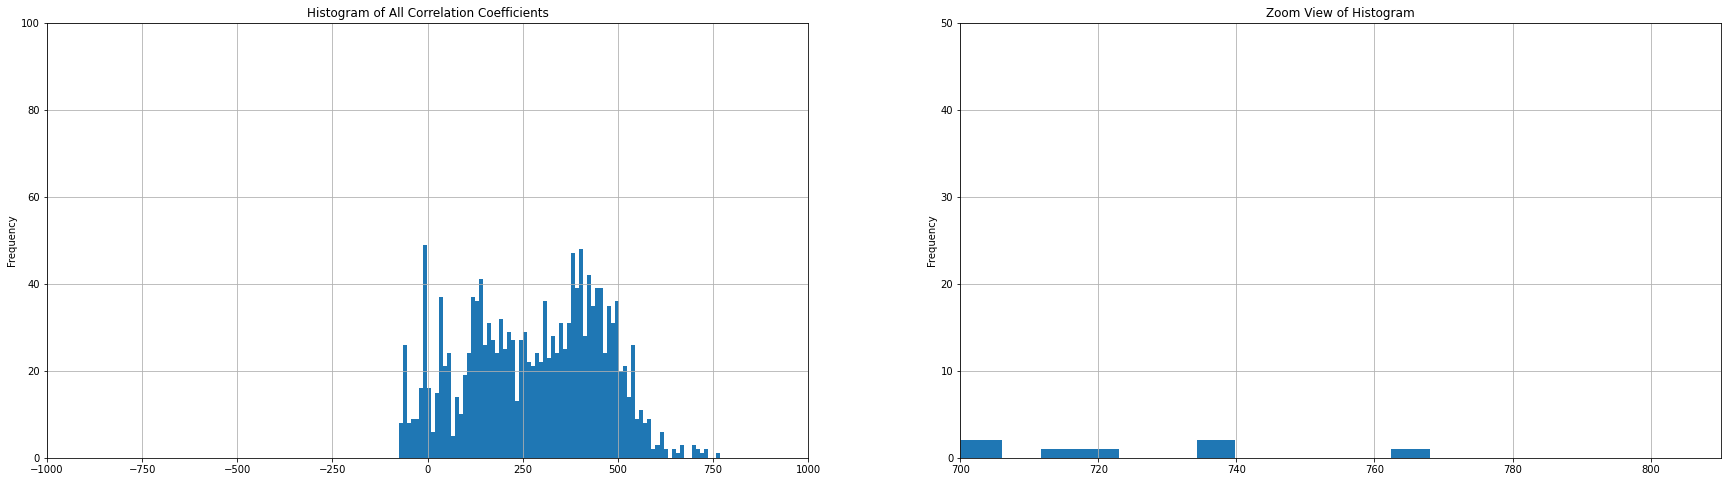

In [63]:
# plot histogram to see distribution of correlation coefficients
# first, remove duplicates (upper right correlation coeffs = lower left, mirrored on diagonal) and diagonal; replace with NaN so won't be counted in histogram
cm = si_corr_matrix.copy(deep=True)
for rnum in range(si_corr_matrix.shape[0]):
    cm.iloc[rnum,0:rnum+1] = np.NaN
# now, stack the columns so we have a single column for easy feed into histogram plot method:
cm = cm.stack().reset_index(drop=True)

fig = plt.figure(figsize=(30,8)) 
axTotal = fig.add_subplot(1,2,1)
axTotal.set_title(f'Histogram of All Correlation Coefficients')
axZoom = fig.add_subplot(1,2,2)
axZoom.set_title(f'Zoom View of Histogram')

cm.plot(kind='hist', grid=True, bins=80, ax=axTotal)
cm.plot(kind='hist', grid=True, bins=150,  ax=axZoom)

axTotal.set_xlim(-1000,1000)
axTotal.set_ylim(0,100)
axZoom.set_xlim(700,)
axZoom.set_ylim(0,50)
done=True

<IPython.core.display.Javascript object>

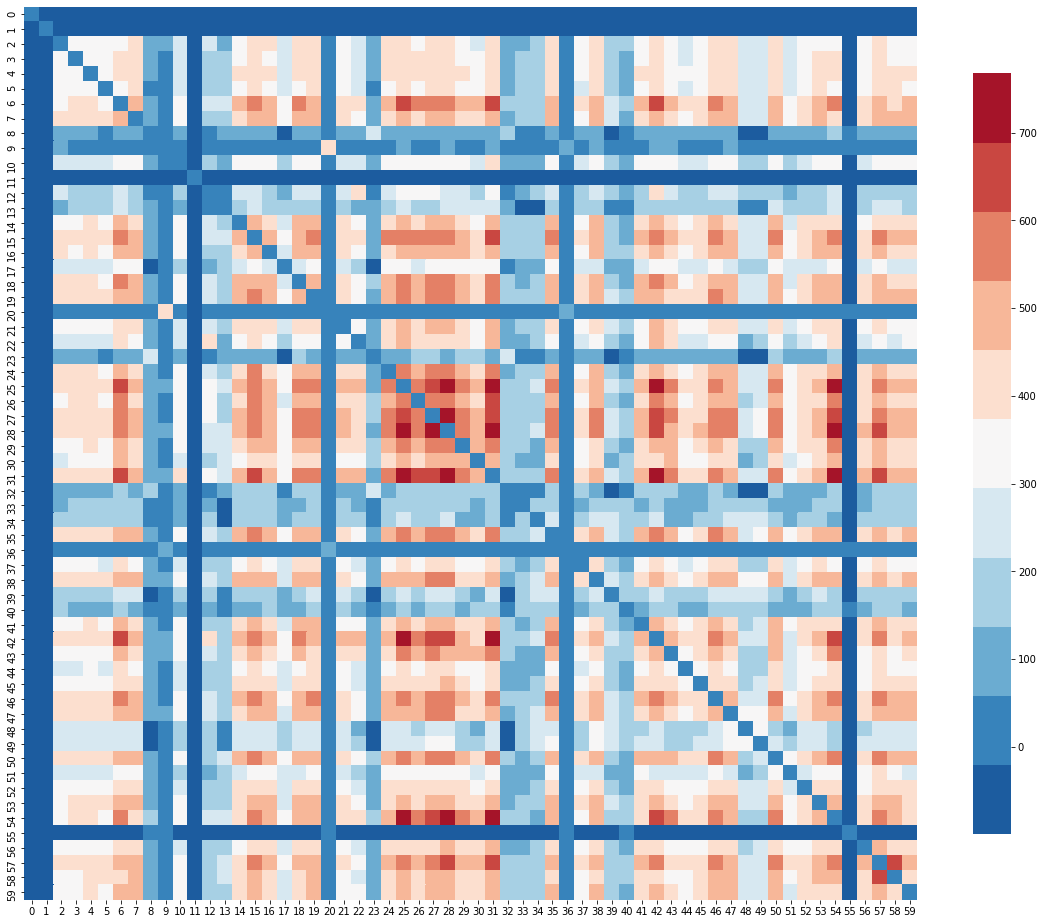

In [67]:
# heatmap of the correlation coefficients with row and column axes = category ids, in numerical order
plt.rcParams["figure.figsize"] = [20,20]
display(Javascript('''google.colab.output.setIframeHeight(0, true, {maxHeight: 5000})'''))
si_corr_matrix_fill = si_corr_matrix.fillna(-99)
h = sns.heatmap(si_corr_matrix_fill,
                cmap= sns.color_palette("RdBu_r", 11), #sns.diverging_palette( 30, 50, s=90, l=60, n=11, center="dark"), #'coolwarm',
                annot=False, #True,
                fmt= '.0g', #".1g", #".1f",
                annot_kws={'size':8},
                cbar=True,
                cbar_kws={"shrink": 0.7},
                square=True)
plt.show()

<IPython.core.display.Javascript object>

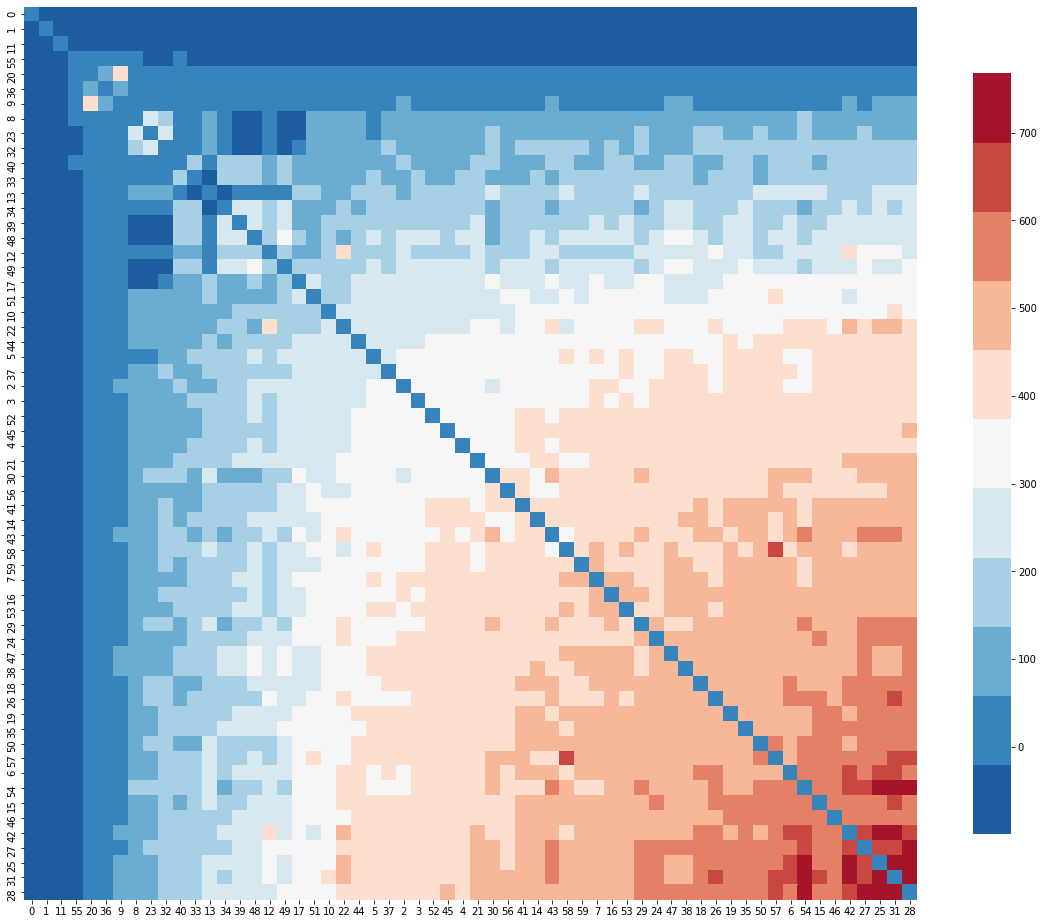

In [68]:
# look at a sorted version of the correlation matrix to see which items are most heavily correlated with others
#    sort by: sum of all correlation numbers in a column
df = si_corr_matrix_fill.copy(deep=True)#.reset_index(drop=True)
sortedidx = df.sum(axis=1).sort_values().index 
df = df.reindex(index=sortedidx, columns=sortedidx)
plt.rcParams["figure.figsize"] = [20,20]
display(Javascript('''google.colab.output.setIframeHeight(0, true, {maxHeight: 5000})'''))
h = sns.heatmap(df,
                cmap= sns.color_palette("RdBu_r", 11), #sns.diverging_palette( 30, 50, s=90, l=60, n=11, center="dark"), #'coolwarm',
                annot=False, #True,
                fmt= '.0g', #".1g", #".1f",
                annot_kws={'size':8},
                cbar=True,
                cbar_kws={"shrink": 0.7},
                square=True)
plt.show()

In [69]:
corr_matrix_ids_masked = si_corr_matrix > 730 #correlation_threshold # gives a boolean matrix mask that is next used to populate df with the item_category_ids meeting the criteria
corr_matrix_ids_masked = corr_matrix_ids_masked.apply(lambda x: x * (x.index + 1))  # add 1 to be sure we get catcode=0; will subtract afterwards
    
friendliest = corr_matrix_ids_masked.nunique() - 1  #(-1 to remove irrelevant "unique" cat code = 0)
if friendliest.values.sum() > 0:
    friendliest = friendliest.sort_values(ascending=False).reset_index(name='n_close_corr_cats')
    print(f'Top 10 categories having most number of correlated categories meeting the threshold criterion:\n{friendliest[:10]}\n')
else:
    print('\n***********************************************')
    print('**  NO CATEGORIES MEET THE THRESHOLD LIMIT  ***')
    print('***********************************************\n')
#corr_matrix_ids_masked.head()

print(f'done: {strftime("%a %X %x")}\n')
#corr_matrix_ids_masked.iloc[57:62,59:84]

Top 10 categories having most number of correlated categories meeting the threshold criterion:
       n_close_corr_cats
0  31                  2
1  25                  2
2  42                  1
3  28                  1
4  59                  0
5  15                  0
6  26                  0
7  24                  0
8  23                  0
9  22                  0

done: Thu 19:12:29 06/11/20



In [70]:
# create dataframe to make networkX graph (columns = node1, node2, edge_weight between node1 and node2)
if friendliest.values.sum() == 0:
    print('\n***********************************************')
    print('**  NO CATEGORIES MEET THE THRESHOLD LIMIT  ***')
    print('***********************************************\n')
else:
    cat_friends = pd.DataFrame({'category1':[x for x in range(n_ids) if corr_matrix_ids_masked[x].sum()>0]})
    cat_friends['category2'] = cat_friends.category1.apply(lambda x: [i-1 for i in corr_matrix_ids_masked[x].unique() if i != 0])  # subtract 1 to account for the addition of 1 above (so we wouldn't lose catid=0)
    cat_friends = cat_friends.explode('category2').reset_index(drop=True)
    cat_friends['weight'] = cat_friends.apply(lambda x: si_corr_matrix.at[x.category1,x.category2], axis=1)
    cat_friends = cat_friends[cat_friends.weight > 0].reset_index(drop=True)
    print(f'done: {strftime("%a %X %x")}\n')
    print(f'Number of pairs meeting the threshold limit: {len(cat_friends)}')
    unique_nodes = list(cat_friends.category1.unique()) + list(cat_friends.category2.unique())
    set_unique_nodes = set(unique_nodes)
    print(f'Number of unique category ids in the pairs meeting the threshold limit: {len(set_unique_nodes)}\n')
    print(cat_friends.head(10))

    # edge_threshold = correlation_threshold  # correlation*1000 (edge weight) must be greater than this for two item_ids to be connected in the graph
    # cat_friends = cat_friends[cat_friends.weight > edge_threshold]

    # import pandas df into weighted-edge graph:
    G = nx.from_pandas_edgelist(cat_friends, 'category1', 'category2', ['weight'])
    print(f'\nWeighted-edge graph G formation done: {strftime("%a %X %x")}\n')

done: Thu 19:12:33 06/11/20

Number of pairs meeting the threshold limit: 6
Number of unique category ids in the pairs meeting the threshold limit: 4

   category1 category2  weight
0         25        31     768
1         25        42     735
2         28        31     736
3         31        25     768
4         31        28     736
5         42        25     735

Weighted-edge graph G formation done: Thu 19:12:33 06/11/20



In [71]:
if friendliest.values.sum() == 0:
    print('\n***********************************************')
    print('**  NO CATEGORIES MEET THE THRESHOLD LIMIT  ***')
    print('***********************************************\n')
else:
    # employ a clustering method that utilizes the edge weights
    communities = community.asyn_lpa_communities(G, weight='weight', seed=44)  # note that the values in this variable assignment are deleted after being read (??!)
print(f'done: {strftime("%a %X %x")}\n')

done: Thu 19:12:35 06/11/20



In [0]:
# extract information from the clustering algorithm's community grouping, and insert into df
if friendliest.values.sum() == 0:
    print('\n***********************************************')
    print('**  NO CATEGORIES MEET THE THRESHOLD LIMIT  ***')
    print('***********************************************\n')
else:
    num_communities = 0; community_items = set()
    comm_info = OrderedDict({'n_nodes':[],'w_avg':[],'w_sum':[],'w_max':[],'w_min':[],'w_std':[],'cluster_members':[]})
    for i,c in enumerate(communities):
        edgeweights = []; num_communities += 1
        community_items = community_items | set(c)
        nodelist = list(c); nnodes = len(nodelist)
        for m in range(nnodes-1):
            for n in range(m+1,nnodes):
                try:
                    edgeweights.append(G.edges[nodelist[m], nodelist[n]]['weight'])
                except:
                    pass   
        comm_info['n_nodes'].append(nnodes)
        comm_info['cluster_members'].append(sorted(nodelist))
        comm_info['w_avg'].append(round(np.mean(edgeweights)))
        comm_info['w_sum'].append(np.sum(edgeweights)); comm_info['w_max'].append(np.max(edgeweights))
        comm_info['w_min'].append(np.min(edgeweights)); comm_info['w_std'].append(np.std(edgeweights))

    community_df = pd.DataFrame(comm_info) # create dataframe with cluster info
    if category_names['print']:
        community_df['category_names'] = community_df.cluster_members.apply(lambda x: [category_names['df'].at[catid,category_names['column']] for catid in x])  # add column containing textual names of things in each cluster
    community_df = community_df.sort_values(['w_avg','n_nodes'],ascending=False).reset_index(drop=True)  # sort dataframe so highest average correlation clusters are first (larger num_nodes clusters are prioritized if tie in corr)
    all_cluster_item_ids = community_df.cluster_members.sum()
    unique_cluster_item_ids = set(all_cluster_item_ids)

In [73]:
# Display the results
if friendliest.values.sum() == 0:
    print('\n***********************************************')
    print('**  NO CATEGORIES MEET THE THRESHOLD LIMIT  ***')
    print('***********************************************\n')
else:
    print(community_df.describe())
    print("\n")

    print(f'done: {strftime("%a %X %x")}')
    print(f'\nCorrelation Threshold (1000x): {correlation_threshold:d}')
    print(f'Correlation Method: {corr_method}')
    print(f'Minimum number of periods for correlation calc: {min_samples_corr}')
    #print(f'Daily sales clip limits before grouping: {daily_sales_min_clip:d}, {daily_sales_max_clip:d}')
    #print(f'Drop test month (= 34) before grouping?: {drop_test_month}')
    print(f'Fill fillna(0) before computing correlations?: {fillna0}')
    print(f'Grouping time period: by {group_time_period}')
    print(f'Grouping category: by {group_category}')
    print(f'Aggregation column: sum of {agg_column} within a {group_time_period} for each {group_category}')
    print(f'Number of community clusters identified in the graph: {num_communities}')
    print(f'Total number of ids in all suggested clusters): {len(all_cluster_item_ids)}')
    print(f'Number of *unique* ids contained in all clusters: {len(unique_cluster_item_ids)}\n')
    print('In the following table, "w" refers to the weights between graph nodes = 1000x correlation coefficient:')
    print(community_df.head(10))

       n_nodes  w_avg  w_sum  w_max  w_min  w_std
count        1      1      1      1      1      1
mean         4    746   2239    768    735 15.326
std        nan    nan    nan    nan    nan    nan
min          4    746   2239    768    735 15.326
25%          4    746   2239    768    735 15.326
50%          4    746   2239    768    735 15.326
75%          4    746   2239    768    735 15.326
max          4    746   2239    768    735 15.326


done: Thu 19:12:41 06/11/20

Correlation Threshold (1000x): 500
Correlation Method: pearson
Minimum number of periods for correlation calc: 8
Fill fillna(0) before computing correlations?: True
Grouping time period: by month
Grouping category: by shop_id
Aggregation column: sum of sales within a month for each shop_id
Number of community clusters identified in the graph: 1
Total number of ids in all suggested clusters): 4
Number of *unique* ids contained in all clusters: 4

In the following table, "w" refers to the weights between graph nodes

##Explore correlations related to sales amounts, for 
* individual categories (e.g. item_category_id #n vs. item_category_id #n+1)
* category pairs (e.g., sales in item_category_id #n vs. shop_id #m)
* lagged values (e.g., item_category_id #n vs. item_category_id #n lagged by x amount)
* * lagged values can be shifted by days, weeks, months, quarters

In [0]:
# To Do:
'''
#####################
# START: correlations without NLP:  look at item_cnt_day numbers, and find which things to group to make decision tree algorithms more effective and predictive
#####################

How to best check sales correlations between elements/groups?
- clip daily sales at [0,20] before grouping
- use self-correlation with time lag to see what are the best lag features to use (maybe grouped by month first, with lags =1 to 15 and 
      grouped by shop_id(fastest) or item_cat_id or item or shop_item or shop-item_cat / pivot so shop or item number = column number)
- look at correlation between shops and between items and between shop-item and item_category_ids for different lags and for different items; see if we can reduce number of category_ids, or if we should increase

#####################
# END: correlations without NLP
#####################



#####################
# START: thoughts on adjustments to make to the NLP section of this ipynb, if we should wish to continue on this route...
#####################

re.findall isn't consistent... sometimes gives a list of an array of tuples (many of which are empty string, but a matching string will be in any one of the tuple positions... and, possibly more than one??), so x=[("",""," dvd","")] and x[0] gives the tuple, and x[0][0]=''
sometimes gives a list of a single string, so x[0] = 'abbyy' and x[0][0]='a'
--> maybe add an extra df column for ngrams to append, and merge it with the delim_item_strings after all 'cleaning' is done

explicitly concatenate the item category name as a n-gram string, with n the same for all categories (pad as needed); don't add it to string before separating

focus on any of the 84 categories that have the most items or the most spread in behavior... split apart the ones with odd behavior, or the ones that are sold by  a subset of shops consistently
(original train set: item_cat_id.counts()
(original train set: item_cat_id - item_cnt_day.value_counts()
(group by item_cat_id (agg: counts); then do shop_id.counts()
(group by month and item_cat_id; look at sum of sales by item_cat_id for last xx months, and characterize the various groups with min/max/std over past n months, for several n)
--> look after stripping the version numbers, etc. off the games and software, and create new groups based on only that??
--> can also try combining similar of the 84 categories (e.g., all playstations, or all xboxes, or all tickets/cards/...) and see if we have more consistent performance within a category
--> can also look at top 50 clusters created by NLP, and see how correlated their sales are, within a cluster, vs. uncorrelated outside a cluster

###
maybe create a combination category column like grouping certain shop-item pairs, or shop-item_category pairs, or shop_cat-item_cat pairing

####
look at most common n-grams for the cleaned/non-delimited item name
(start with n=15 and work backwards to n=1)
clean/replace as much as possible without overly distorting the item name
then:
for each n:
--> split clean string into consecutive n-grams and put them in df columns, where the # columns in df = largest number of n-grams for any of the item names (search to find longest name, and calculate how many columns are needed/used)
--> in each column, do count_values... perhaps do a combined unique() to get all the n-grams, then put into an array or series containing the n-gram string and the sum of value_counts over each column
--> sort by frequency, and choose the ? top 100 and ? bottom 100 (for sum>1)
--> convert some of the desired n-grams into n+x grams to reflect the relative importance?

#####################
# END: adjustments to make to the NLP section of this ipynb...
#####################
'''

print(f'done: {strftime("%a %X %x")}')

##2.x.1.x) Explore Correlation Type:
* **item_category_id** - **item_category_id** correlation 
* sales grouped by **week** (and **item_category_id**)
</br>

* Pearson correlation between sales of item categories for each week; threshold at a certain value (e.g., above 0.92) to indicate sufficient correlation to include.  Then, use neworkX and graph clustering to extract groups of tightly-clustered item_category_ids


In [0]:
# Start by setting desired parameters:

# before grouping:
daily_sales_max_clip = 20
daily_sales_min_clip = 0
drop_test_month = True

fillna0 = True                      # perform fillna(0) on dataframe before computing correlations between feature categories
correlation_threshold = 700         # 1000x the computed correlation coefficient; only pairs with correlation coefficients greater than this get included in cluster determination
corr_method = 'pearson'             # 'kendall' or 'pearson' or 'spearman'
min_samples_corr = 4
n_ids = len(item_categories_augmented)

group_time_period = 'day'
group_category = 'item_category_id'
agg_column = 'sales'                # sum of this when grouping by the above
category_names = {'print':True, 'df':item_categories_augmented, 'column':'en_cat_name'}   # when printing out the final clusters, if print=True, use this dataframe and column to return the names (assuming row# = category id)

print(f'done: {strftime("%a %X %x")}\n')

###create category vs. sales (by time_period) dataframe, on which to do correlation examination

In [0]:
df_keep = [group_time_period,agg_column,group_category]
df_groupby = [group_time_period,group_category]
pivot_idx = group_time_period
pivot_cols = group_category
pivot_values = agg_column

# clipping daily shop-item pair sales as desired, then drop test month if desired, then group by time=group_time_period and by cat=group_category (dropping unnecessary columns)
# finally, pivot the dataframe so columns correspond to different categories, and rows correspond to different time periods
time_cat = tt.copy(deep=True)
time_cat.sales.clip(daily_sales_min_clip, daily_sales_max_clip, inplace=True)
if drop_test_month:
    time_cat = time_cat[time_cat.month < 34]
time_cat = time_cat[df_keep].groupby(df_groupby).sum().reset_index()
time_cat = time_cat.pivot(index = pivot_idx, columns = pivot_cols, values = pivot_values).reset_index(drop=True)

print(f'done: {strftime("%a %X %x")}\n')
print(f'Pivoted dataframe shape for sales per {group_category}, summed within each {group_time_period}: {time_cat.shape}\n')
print(time_cat.describe(),'\n')
time_cat.head()

In [0]:
#sns.pairplot(cat_cat.iloc[:][:4])  # can't seem to get this multiple-plot grid to work in a reasonable amount of time (even with GPU, stopped this 2x2 grid afer 20min of incompletion)
# pltcolors = ['blue','red','green','black','darkorange','darkorchid','teal', 'gold','olive','firebrick','gray','sienna','fuchsia','dodgerblue','cyan','lime','deeppink','violet','turquoise','tan']

# sanity check, just do a simple line plot and a simple scatter plot between a couple of items (they can be different pairs for each plot)

'''
Line Plot Inputs & Parameters
'''
categories_for_line_plot = [6,15,82]  # x-axis is index (time period)
line_colors = pltcolors[:len(categories_for_line_plot)]
# if desired, set axis limits using bool or tuple:
line_plot_x = False  # False uses auto-scale
line_plot_y = False

'''
Scatter Plot Inputs & Parameters
'''
x_scatter_plot_category = [6]
y_scatter_plot_categories = [12,15] #,70]
scatter_alphas = [1.0, 0.25] #, 0.25]          # set transparency to see dots behind other dots
scatter_plot_x = False #(20,40) #False  # False uses auto-scale
scatter_plot_y = (-10,200)


print(f'Plotted at: {strftime("%a %X %x")}\n')

'''
Generate the Plots
'''
fig = plt.figure(figsize=(20,8)) 
axLine = fig.add_subplot(1,2,1)
axLine.set_title(f'Sales per {group_time_period}, Grouped by {group_category}')
axScatter = fig.add_subplot(1,2,2)
axScatter.set_title(f'Sales of Select {group_category}s vs. Category {x_scatter_plot_category[0]} (sales per category summed over each {group_time_period})')

time_cat.plot(y=categories_for_line_plot, kind='line',color=line_colors,grid=True, ax=axLine)

for sidx, s in enumerate(y_scatter_plot_categories):
    time_cat.plot.scatter(x=x_scatter_plot_category,y=s,color=scatter_colors[sidx], grid=True, ax=axScatter, label=str(s), alpha=scatter_alphas[sidx])

axLine.legend(title='Category')
axLine.set_ylabel(f'Sales per {group_time_period} (number of units) for Each Category')
axLine.set_xlabel(f'{group_time_period} Number')
axScatter.legend(title=f'Category\n(vs. {x_scatter_plot_category[0]} on x-Axis)')
axScatter.set_ylabel(f'Sales per {group_time_period} (number of units) for Comparison Categories')
axScatter.set_xlabel(f'Sales per {group_time_period} (number of units) for Category {x_scatter_plot_category[0]}')
if line_plot_x:
    axLine.set_xlim(line_plot_x)
if line_plot_y:
    axLine.set_ylim(line_plot_y)
if scatter_plot_x:
    axScatter.set_xlim(scatter_plot_x)
if scatter_plot_y:
    axScatter.set_ylim(scatter_plot_y)

codeDone = True   # suppresses the printing of matplotlib object above

###category vs. category  correlation matrix

In [0]:
if fillna0:
    corr_matrix = time_cat.fillna(0).corr(method=corr_method, min_periods=min_samples_corr)
else:
    corr_matrix = time_cat.corr(method=corr_method, min_periods=min_samples_corr)

corr_matrix = round(corr_matrix * 1000)
corr_matrix = corr_matrix.apply(pd.to_numeric,  downcast='integer')
for i in range(corr_matrix.shape[0]):  #set diag to zeros
    corr_matrix.at[i,i] = 0
    
print(f'done: {strftime("%a %X %x")}\n')
corr_matrix.head()

In [0]:
# plot histogram to see distribution of correlation coefficients; can help with setting threshold
# first, remove duplicates (upper right correlation coeffs = lower left, mirrored on diagonal) and diagonal; replace with NaN so won't be counted in histogram
cm = corr_matrix.copy(deep=True)
for rnum in range(n_ids):
    cm.iloc[rnum,0:rnum+1] = np.NaN
# now, stack the columns so we have a single column for easy feed into histogram plot method:
cm = cm.stack().reset_index(drop=True)

fig = plt.figure(figsize=(30,8)) 
axTotal = fig.add_subplot(1,2,1)
axTotal.set_title(f'Histogram of All Correlation Coefficients')
axZoom = fig.add_subplot(1,2,2)
axZoom.set_title(f'Zoom View of Histogram')

cm.plot(kind='hist', grid=True, bins=80, ax=axTotal)
cm.plot(kind='hist', grid=True, bins=150,  ax=axZoom)

axTotal.set_xlim(-1000,1000)
axTotal.set_ylim(0,100)
axZoom.set_xlim(700,)
axZoom.set_ylim(0,50)
done=True

In [0]:
corr_matrix_ids_masked = corr_matrix > correlation_threshold # gives a boolean matrix mask that is next used to populate df with the item_category_ids meeting the criteria
corr_matrix_ids_masked = corr_matrix_ids_masked.apply(lambda x: x * (x.index + 1))  # add 1 to be sure we get catcode=0; will subtract afterwards
    
friendliest = corr_matrix_ids_masked.nunique() - 1  #(-1 to remove irrelevant "unique" cat code = 0)
if friendliest.values.sum() > 0:
    friendliest = friendliest.sort_values(ascending=False).reset_index(name='n_close_corr_cats')
    print(f'Top 10 categories having most number of correlated categories meeting the threshold criterion:\n{friendliest[:10]}\n')
else:
    print('\n***********************************************')
    print('**  NO CATEGORIES MEET THE THRESHOLD LIMIT  ***')
    print('***********************************************\n')
#corr_matrix_ids_masked.head()

print(f'done: {strftime("%a %X %x")}\n')
corr_matrix_ids_masked.iloc[57:62,59:84]

###correlation matrix heatmaps

In [0]:
# heatmap of the correlation coefficients with row and column axes = category ids, in numerical order
plt.rcParams["figure.figsize"] = [20,20]
display(Javascript('''google.colab.output.setIframeHeight(0, true, {maxHeight: 5000})'''))

h = sns.heatmap(corr_matrix,
                cmap= sns.color_palette("RdBu_r", 11), #sns.diverging_palette( 30, 50, s=90, l=60, n=11, center="dark"), #'coolwarm',
                annot=False, #True,
                fmt= '.0g', #".1g", #".1f",
                annot_kws={'size':8},
                cbar=True,
                cbar_kws={"shrink": 0.7},
                square=True)
plt.show()

In [0]:
# look at a sorted version of the correlation matrix to see which items are most heavily correlated with others
#    sort by: sum of all correlation numbers in a column
df = corr_matrix.copy(deep=True).reset_index(drop=True)
sortedidx = df.sum(axis=1).sort_values().index 
df = df.reindex(index=sortedidx, columns=sortedidx)
plt.rcParams["figure.figsize"] = [20,20]
display(Javascript('''google.colab.output.setIframeHeight(0, true, {maxHeight: 5000})'''))
h = sns.heatmap(df,
                cmap= sns.color_palette("RdBu_r", 11), #sns.diverging_palette( 30, 50, s=90, l=60, n=11, center="dark"), #'coolwarm',
                annot=False, #True,
                fmt= '.0g', #".1g", #".1f",
                annot_kws={'size':8},
                cbar=True,
                cbar_kws={"shrink": 0.7},
                square=True)
plt.show()

In [0]:
# look at a sorted version of the correlation matrix to see which items are most heavily correlated with others
#   sort by: count of number of items correlated above the threshold
df = corr_matrix.copy(deep=True).reset_index(drop=True)
sortedidx = corr_matrix_ids_masked.nunique().sort_values(ascending=False).index 
df = df.reindex(index=sortedidx, columns=sortedidx)
plt.rcParams["figure.figsize"] = [20,20]
display(Javascript('''google.colab.output.setIframeHeight(0, true, {maxHeight: 5000})'''))
h = sns.heatmap(df,
                cmap= sns.color_palette("RdBu_r", 11), #sns.diverging_palette( 30, 50, s=90, l=60, n=11, center="dark"), #'coolwarm',
                annot=False, #True,
                fmt= '.0g', #".1g", #".1f",
                annot_kws={'size':8},
                cbar=True,
                cbar_kws={"shrink": 0.7},
                square=True)
plt.show()

###create networkX graph and perform clustering

In [0]:
# create dataframe to make networkX graph (columns = node1, node2, edge_weight between node1 and node2)
if friendliest.values.sum() == 0:
    print('\n***********************************************')
    print('**  NO CATEGORIES MEET THE THRESHOLD LIMIT  ***')
    print('***********************************************\n')
else:
    cat_friends = pd.DataFrame({'category1':[x for x in range(n_ids) if corr_matrix_ids_masked[x].sum()>0]})
    cat_friends['category2'] = cat_friends.category1.apply(lambda x: [i-1 for i in corr_matrix_ids_masked[x].unique() if i != 0])  # subtract 1 to account for the addition of 1 above (so we wouldn't lose catid=0)
    cat_friends = cat_friends.explode('category2').reset_index(drop=True)
    cat_friends['weight'] = cat_friends.apply(lambda x: corr_matrix.at[x.category1,x.category2], axis=1)
    cat_friends = cat_friends[cat_friends.weight > 0].reset_index(drop=True)
    print(f'done: {strftime("%a %X %x")}\n')
    print(f'Number of pairs meeting the threshold limit: {len(cat_friends)}')
    unique_nodes = list(cat_friends.category1.unique()) + list(cat_friends.category2.unique())
    set_unique_nodes = set(unique_nodes)
    print(f'Number of unique category ids in the pairs meeting the threshold limit: {len(set_unique_nodes)}\n')
    print(cat_friends.head(10))

    # edge_threshold = correlation_threshold  # correlation*1000 (edge weight) must be greater than this for two item_ids to be connected in the graph
    # cat_friends = cat_friends[cat_friends.weight > edge_threshold]

    # import pandas df into weighted-edge graph:
    G = nx.from_pandas_edgelist(cat_friends, 'category1', 'category2', ['weight'])
    print(f'\nWeighted-edge graph G formation done: {strftime("%a %X %x")}\n')

In [0]:
if friendliest.values.sum() == 0:
    print('\n***********************************************')
    print('**  NO CATEGORIES MEET THE THRESHOLD LIMIT  ***')
    print('***********************************************\n')
else:
    # employ a clustering method that utilizes the edge weights
    communities = community.asyn_lpa_communities(G, weight='weight', seed=42)  # note that the values in this variable assignment are deleted after being read (??!)
print(f'done: {strftime("%a %X %x")}\n')

In [0]:
# extract information from the clustering algorithm's community grouping, and insert into df
if friendliest.values.sum() == 0:
    print('\n***********************************************')
    print('**  NO CATEGORIES MEET THE THRESHOLD LIMIT  ***')
    print('***********************************************\n')
else:
    num_communities = 0; community_items = set()
    comm_info = OrderedDict({'n_nodes':[],'w_avg':[],'w_sum':[],'w_max':[],'w_min':[],'w_std':[],'cluster_members':[]})
    for i,c in enumerate(communities):
        edgeweights = []; num_communities += 1
        community_items = community_items | set(c)
        nodelist = list(c); nnodes = len(nodelist)
        for m in range(nnodes-1):
            for n in range(m+1,nnodes):
                try:
                    edgeweights.append(G.edges[nodelist[m], nodelist[n]]['weight'])
                except:
                    pass   
        comm_info['n_nodes'].append(nnodes)
        comm_info['cluster_members'].append(sorted(nodelist))
        comm_info['w_avg'].append(round(np.mean(edgeweights)))
        comm_info['w_sum'].append(np.sum(edgeweights)); comm_info['w_max'].append(np.max(edgeweights))
        comm_info['w_min'].append(np.min(edgeweights)); comm_info['w_std'].append(np.std(edgeweights))

    community_df = pd.DataFrame(comm_info) # create dataframe with cluster info
    if category_names['print']:
        community_df['category_names'] = community_df.cluster_members.apply(lambda x: [category_names['df'].at[catid,category_names['column']] for catid in x])  # add column containing textual names of things in each cluster
    community_df = community_df.sort_values(['w_avg','n_nodes'],ascending=False).reset_index(drop=True)  # sort dataframe so highest average correlation clusters are first (larger num_nodes clusters are prioritized if tie in corr)
    all_cluster_item_ids = community_df.cluster_members.sum()
    unique_cluster_item_ids = set(all_cluster_item_ids)

###results of graph clustering algorithm

In [0]:
# Display the results
if friendliest.values.sum() == 0:
    print('\n***********************************************')
    print('**  NO CATEGORIES MEET THE THRESHOLD LIMIT  ***')
    print('***********************************************\n')
else:
    print(community_df.describe())
    print("\n")

    print(f'done: {strftime("%a %X %x")}')
    print(f'\nCorrelation Threshold (1000x): {correlation_threshold:d}')
    print(f'Correlation Method: {corr_method}')
    print(f'Minimum number of periods for correlation calc: {min_samples_corr}')
    print(f'Daily sales clip limits before grouping: {daily_sales_min_clip:d}, {daily_sales_max_clip:d}')
    print(f'Drop test month (= 34) before grouping?: {drop_test_month}')
    print(f'Fill fillna(0) before computing correlations?: {fillna0}')
    print(f'Grouping time period: by {group_time_period}')
    print(f'Grouping category: by {group_category}')
    print(f'Aggregation column: sum of {agg_column} within a {group_time_period} for each {group_category}')
    print(f'Number of community clusters identified in the graph: {num_communities}')
    print(f'Total number of ids in all suggested clusters): {len(all_cluster_item_ids)}')
    print(f'Number of *unique* ids contained in all clusters: {len(unique_cluster_item_ids)}\n')
    print('In the following table, "w" refers to the weights between graph nodes = 1000x correlation coefficient:')
    print(community_df.head(10))

In [0]:
def largest_indices(ary, n):
    """Returns the n largest indices from a numpy array."""
    flat = ary.flatten()
    indices = np.argpartition(flat, -n)[-n:]
    indices = indices[np.argsort(-flat[indices])]
    return np.unravel_index(indices, ary.shape)

k=10
# what are the top-10 most correlated categories?
# remove everything under diagonal so we don't get duplicate results

if friendliest.values.sum() == 0:
    print('\n***********************************************')
    print('**  NO CATEGORIES MEET THE THRESHOLD LIMIT  ***')
    print('***********************************************\n')
else:
    # remove elements below the diagonal
    corr_diag = corr_matrix
    for rnum in range(n_ids):
        corr_diag.iloc[rnum,0:rnum] = 0
    corr_npy = corr_diag.to_numpy()
    cms_top_idxs = largest_indices(corr_npy, k)
    cms_top_vals = corr_npy[cms_top_idxs]
    top_k = pd.DataFrame({'cat1':cms_top_idxs[0], 'cat2':cms_top_idxs[1], 'corr':cms_top_vals})
    if category_names['print']:
        top_k['category_names'] = top_k.apply(lambda x: [category_names['df'].at[x.cat1,category_names['column']], category_names['df'].at[x.cat2,category_names['column']]], axis = 1) 

    print(f'done: {strftime("%a %X %x")}\n')

    print(f'Top {k} most-strongly-correlated pairs:')
    print(top_k)

In [0]:
lr=mgcd # dummy code to stop execution of "run after" menu option, so we don't go into all the stuff below

#2.5) ***items*** Dataset: EDA, Cleaning, Correlations, and Feature Generation

---



---



###2.5.1) Initial data exploration and Russian -> English translation

####Thoughts regarding items dataframe
Let's first look at how many training examples we have to work with...

Many of the items have similar names, but slightly different punctuation, or only very slightly different version numbers or types.  (e.g., 'Call of Duty III' vs. 'Call of Duty III DVD')

One can expect that these two items would have similar sales in general, and by grouping them into a single feature category, we can eliminate some of the overfitting that might come as a result of the relatively small ratio of (training set shop-item-date combinations = 2935849)/(total number of unique items = 22170).  (This is an average of about 132 rows in the sales_train data for each shop-item-date combination that we are using to train our model.  Our task is to produce a monthly estimate of sales (for November 2015), so it is relevant to consider training our model based on how many sales in a month vs. how many sales in the entire training set.  Given that the sales_train dataset covers the time period from January 2013 to October 2015 (34 months), we have on average fewer than 4 shop-item combinations in our training set for a given item in any given month.  Furthermore, as we are trying to predict for a particular month (*November* 2015), it is relevant to consider how many rows in our training set occur in the month of November.  The sales_train dataset contains data for two 'November' months out of the total 34 months of data.  Another simple calculation gives us an estimate that our training set contains on average 0.23 shop-item combinations per item for November months.

To summarize:

*  *sales_train* contains 34 months of data, including 2935849 shop-item-date combinations
*  *items* contains 22170 "unique" item_id values

In the *sales_train* data, we therefore have:
*  on average, 132 rows with a given shop-item pair for a given item_id
*  on average, 4 rows with a given shop-item pair for a given item_id in a given month
*  on average, 0.23 rows with a given shop-item pair for a given item_id in all months named 'November'

If we wish to improve our model predictions for the following month of November, it behooves us to use monthly grouping of sales, or, even better, November grouping of sales.  This smooths out day-to-day variations in sales for a better monthly prediction.  However, the sparse number of available rows in the *sales_train* data will contribute to inaccuracy in our model training and predictions.

Imagine if we could reduce the number of item_id values from 22170 to perhaps half that or even less.  Given that the number of rows for training (per item, on a monthly or a November basis) is so small, then such a reduction in the number of item_id values would have a big impact.  (The same is true for creating features to supplement "shop_id" so as to group and reduce the individuality of each shop - and thus effectively create, on average, more rows of training data for each shop-item pair.

####Translate and Ruminate
We will start by translating the Russian text in the dataframe, and add our ruminations on possible new features we can generate.

The dataframe *items_transl* (equivalent to *items* plus a column for English translation) is saved as a .csv file so we do not have to repeat the translation process the next time we open a Google Colab runtime.

In [0]:
print(items_transl.info())
print("\n")
print(items_transl.tail(10))

###2.5.2) **NLP for feature generation from items data**
Automate the search for commonality among items, and create new categorical feature to prevent overfitting from close similarity between many item names

####**Delimited Groups of Words**

Investigating "special" delimited word groups (like this) or [here] or /hobbitville/ that are present in item names, and may be particularly important in creating n>1 n-grams for uniquely identifying items so that we can tell if two items are the same or nearly the same

#####Some details on the approach, and code for helper functions to clean and separate the text:

In [0]:
# explanation of regex string I'm using to parse the item_name
'''

^\s+|\s*[,\"\/\(\)\[\]]+\s*|\s+$

gm
1st Alternative ^\s+
^ asserts position at start of a line
\s+ matches any whitespace character (equal to [\r\n\t\f\v ])
+ Quantifier — Matches between one and unlimited times, as many times as possible, giving back as needed (greedy)

2nd Alternative \s*[,\"\/\(\)\[\]]+\s*
\s* matches any whitespace character (equal to [\r\n\t\f\v ])
* Quantifier — Matches between zero and unlimited times, as many times as possible, giving back as needed (greedy)
Match a single character present in the list below [,\"\/\(\)\[\]]+
+ Quantifier — Matches between one and unlimited times, as many times as possible, giving back as needed (greedy)
, matches the character , literally (case sensitive)
\" matches the character " literally (case sensitive)
\/ matches the character / literally (case sensitive)
\( matches the character ( literally (case sensitive)
\) matches the character ) literally (case sensitive)
\[ matches the character [ literally (case sensitive)
\] matches the character ] literally (case sensitive)
\s* matches any whitespace character (equal to [\r\n\t\f\v ])
* Quantifier — Matches between zero and unlimited times, as many times as possible, giving back as needed (greedy)

3rd Alternative \s+$
\s+ matches any whitespace character (equal to [\r\n\t\f\v ])
+ Quantifier — Matches between one and unlimited times, as many times as possible, giving back as needed (greedy)
$ asserts position at the end of a line

Global pattern flags
g modifier: global. All matches (don't return after first match)
m modifier: multi line. Causes ^ and $ to match the begin/end of each line (not only begin/end of string)
'''
print(f'done: {strftime("%a %X %x")}')  # prevent Jupyter from printing triple-quoted comments

done: Tue 17:31:21 06/09/20


In [0]:
# This cell contains no code to run; it is simply a record of some inspections that were done on the items database

# before removing undesirable characters / punctuation from the item name,
#   let's see if we can find n-grams or useful describers or common abbreviations by looking between the nasty characters
# first, let's see what characters are present in the en_item_name column
'''
nasty_symbols = re.compile('[^0-9a-zA-Z ]')
nasties = set()
for i in range(len(items_transl)):
  n = nasty_symbols.findall(items_transl.at[i,'en_item_name'])
  nasties = nasties.union(set(n))
print(nasties)
{'[', '\u200b', 'ñ', '(', ')', '.', 'à', '`', 'ó', '®', 'Á', 
'\\', 'è', '&', '-', ':', 'ë', '_', 'û', '»', '=', '+', ']', ',', 
'«', 'ú', "'", 'ö', '#', 'ä', ';', 'ü', '"', 'ô', '/', '№', 'é', 
'í', '!', '°', 'å', '*', 'ĭ', 'ð', '?', 'â'}
'''
# From the above set of nasty characters, it looks like slashes, single quotes, double quotes, parentheses, and square brackets might enclose relevant n-grams
# Let's pull everything from en_item_name that is inside ' ', " ", (), or [] and see how many unique values we get, and if they are n-grams or abbreviations, for example
# It also seems that many of the item names end in a single character "D" for example, which should be converted to DVD

# ignore the :&+' stuff for now...
# Let's set up columns for ()[]-grams, for last string in the name, and for first string in name, and for text that precedes ":", and for text that surrounds "&" or "+"
#   but first, we will strip out every nasty character except ()[]:&+'"/ and replace the nasties with spaces, then eliminating double spaces

'''
# sanity check:
really_nasty_symbols = re.compile('[^0-9a-zA-Z \(\)\[\]:&+\'"/]')
really_nasties = set()
for i in range(len(items_transl)):
  rn = really_nasty_symbols.findall(items_transl.at[i,'en_item_name'])
  really_nasties = really_nasties.union(set(rn))
print(really_nasties)
{'\u200b', 'ñ', '.', 'à', '`', 'ó', '®', 'Á', '\\', 'è', '-', 'ë', '_', 'û', '»', '=', ',', '«', 'ú', 'ö', '#', 'ä', ';', 'ü', 'ô', '№', 'é', 'í', '!', '°', 'å', '*', 'ĭ', 'ð', '?', 'â'}
OK, looks good
'''
print(f'done: {strftime("%a %X %x")}')  # prevent Jupyter from printing triple-quoted comments

done: Tue 17:31:51 06/09/20


In [0]:
#  Start by defining stopwords and delimiters and punctuation that we wish to remove
#  Then, create a couple of functions to use for text cleaning, and for extracting delimited text n-grams

# stopwords to remove from item names (these are only a bit better than arbitrary selections from large stopwords lists -- may be worth adjusting them)
stop_words = "a,the,an,only,more,are,any,on,your,just,it,its,has,with,for,by,from".split(",")

# pre-compile regex strings to use for fast symbol removal or delimiting
nasty_symbols_re = re.compile(r'[^0-9a-zA-Z ]')  # remove all punctuation
really_nasty_symbols_re = re.compile(r'[^0-9a-zA-Z ,;\"\/\(\)\[\]\:\-\@]')  # remove nasties, but leave behind the delimiters
delimiters_re = re.compile(r'[,;\"\/\(\)\[\]\:\-\@\u00AB\u00BB~<>]')  # unicodes are << and >> thingies
# special symbols indicating a delimiter --> a space at start or end of item name will be removed at split time, along with ,;/()[]:"-@~<<>><>
delim_pattern_re = re.compile(r'^\s+|\s*[,;\"\/\(\)\[\]\:\-\@\u00AB\u00BB~<>]+\s*|\s+$') 
multiple_whitespace_re = re.compile(r'[ ]{2,}')

# pre-compile some specific regex strings to deal with inconsistencies in item names (more of this will be done later, after delimiting)
cleanup_text = {}
cleanup_text['preorder'] = re.compile(r'pre.?order')
cleanup_text[' dvd'] = re.compile(r'\s+d$')  #several item names end in "d" -- which actually seems to indicate dvd (because the items I see are in category 40: Movies-DVD)... standardize so d --> dvd
cleanup_text['digital version'] = re.compile(r'digital in$') # several items seem to end in "digital in"... maybe in = internet?, but looking at nearby items/categories, 'digital version' looks standard
cleanup_text['bluray dvd'] = re.compile(r'\bbd\b|\bblu\s+ray\b|\bblu\-ray\b|\bblueray\b|\bblue\s+ray\b|\bblue\-ray\b')
cleanup_text['007 : james bond : skyfall'] = re.compile(r'\bskyfall\b|\bskayfoll\b')
cleanup_text[' and '] = re.compile(r'[\&\+]')
cleanup_text[' xbox'] = re.compile(r'\bx[^0-9a-zA-Z ]box')  # anything like "x box" or "x-box" or "x%box" gets converted to a standard "xbox"
cleanup_text[' ps'] = re.compile(r'\bp[^0-9a-zA-Z ]s')      # attempt to do the same with "p-s4" --> "ps4"

def maid_service(text):
    """
    Compact routine to implement multiple regex substitutions using the above 'cleanup_text' dictionary
    """
    text = text.lower()
    for repl_text, pattern in cleanup_text.items():
        text = pattern.sub(repl_text, text)
    #r = re.compile(r'\bskayfoll\b')   # can add 'quickie' items here if you don't want to add to above dictionary, or if you want to perform something other than re.sub
    #text = r.sub('skyfall',text)  
    return text

def text_total_clean(text):
    """
    Gives a punctuation-free, cleaned, lemmatized version of the original English translation
    inputs: (text): the original en_item_name single-string, uncleaned, translated version of the Russian item name
    returns: single-string text, made lowercase, stripped of "really_nasties" and multiple spaces, and every word lemmatized
    """
    text = maid_service(text)
    text = delimiters_re.sub(" ", text)  # replace all delimiters with a space; other nasties get simply deleted
    text = nasty_symbols_re.sub("", text)  # delete anything other than letters, numbers, and spaces
    text = multiple_whitespace_re.sub(" ", text)  # replace multiple spaces with a single space
    text = text.strip() # remove whitespace around string
    # lemmatize each word
    text = " ".join([lemmatizer.lemmatize(w) for w in text.split(" ") if w not in stop_words])
    return text

def text_clean_delimited(text):
    """
    Gives a punctuation-free, cleaned version of the original English translation, 
        but the function returns a list of strings instead of a single string,
        with each element in the list corresponding to text that was separated from neighboring
        text with one of the above-defined 'delimiter' characters
        (so, rather than analyzing the full item name for n-grams, we define an item's important
        n-grams as being separated by such delimiters.  It greatly reduces the number of n-grams we need to analyze)
    inputs: (text): the original en_item_name single-string, uncleaned, translated version of the Russian item name
    returns: en_item_name made lowercase, stripped of "really_nasties" and multiple spaces, 
        in a list of strings that had been separated by one of the above 'delimiters',
        and, with every word in every string lemmatized 
    """
    text = maid_service(text)
    text = really_nasty_symbols_re.sub("", text)  # just delete the nasty symbols
    text = multiple_whitespace_re.sub(" ", text)  # replace multiple spaces with a single space
    text = delim_pattern_re.split(text)           # split item_name at all delimiters, irrespective of number of spaces before or after the string or delimiter
    text = [x.strip() for x in text if x != ""]           # remove empty strings "" from the list of split items in text, and remove whitespace outside text n-gram
    # lemmatize each word
    lemtext = []
    for ngram in text:
        lemtext.append(" ".join([lemmatizer.lemmatize(w) for w in ngram.split(" ") if w not in stop_words]))
    return lemtext

print(f'done: {strftime("%a %X %x")}')

done: Tue 17:32:03 06/09/20


#####Add 'delimited' and 'cleaned' data columns; shorten the titles of other columns so dataframe fits better on the screen

In [0]:
items_delimited = items_transl.copy(deep=True)
# delete the wide "item_name" column so we can read more of the data table width-wise
items_delimited = items_delimited.drop("item_name", axis=1).rename(columns = {'en_item_name':'item_name','item_category_id':'i_cat_id'})
items_in_test_set = test.item_id.unique()
items_delimited["i_tested"] = False
for i in items_in_test_set:
  items_delimited.at[i,"i_tested"] = True


# add item_category name with delimiter to the item_name, as this will be useful info for grouping similar items (remove delimiting punctuation from cat names first, so it stays as one chunk of text)
items_delimited['item_name'] = items_delimited.apply(lambda x: text_total_clean(item_categories_augmented.at[x.i_cat_id,'en_cat_name']) + " : " + x.item_name, axis=1)

# add a column of simply cleaned text without any undesired punctuation or delimiters
items_delimited['clean_item_name'] = items_delimited['item_name'].apply(text_total_clean)

# now add a column of lists of delimited (cleaned) text
items_delimited['delim_name_list'] = items_delimited['item_name'].apply(text_clean_delimited)

# remove duplicate entries and single-character 1-grams to assist with operations to come later in this notebook
alphnum = list(string.ascii_lowercase) + list('1234567890')  # get rid of all length=1 1-grams
def remove_dupes_singles(gramlist):
    unwanted = set(alphnum)
    dupe_gramset = unwanted
    return [x for x in gramlist if x not in dupe_gramset and not dupe_gramset.add(x)]
items_delimited.delim_name_list = items_delimited.delim_name_list.apply(lambda x: remove_dupes_singles(x) )


# have a look at what we got with our delimited text globs
def maxgram(gramlist):
    maxg = 0
    for g in gramlist:
        maxg = max(maxg,len(g.split()))
    return maxg
items_delimited['d_len'] = items_delimited.delim_name_list.apply(lambda x: len(x))
items_delimited['d_maxgram'] = items_delimited.delim_name_list.apply(maxgram)

#items_delimited.to_csv("data_output/items_delimited.csv", index=False)

print(f'done: {strftime("%a %X %x")}')
print("\n")
print(items_delimited.describe())
print("\n")
print(items_delimited.iloc[31][:])
print("\n")
items_delimited.head()

done: Tue 21:05:06 06/09/20


         item_id  i_cat_id  d_len  d_maxgram
count      22170     22170  22170      22170
mean  11,084.500    46.291  3.347      4.496
std    6,400.072    15.941  1.336      1.984
min            0         0      1          2
25%    5,542.250        37      2          3
50%   11,084.500        40      3          4
75%   16,626.750        58      4          5
max        22169        83     13         17


item_id                                                                              31
i_cat_id                                                                             37
item_name                           movie bluray dvd : 007: COORDINATES "SKAYFOLL» (BD)
i_tested                                                                           True
clean_item_name       movie bluray dvd 007 coordinate 007 james bond skyfall bluray dvd
delim_name_list    [movie bluray dvd, 007, coordinate, james bond, skyfall, bluray dvd]
d_len                              

item_id  i_cat_id                                                                                                item_name  i_tested  \
0        0        40                                                                 movie dvd : ! POWER IN glamor (PLAST.) D     False   
1        1        76  program home and office digital : ! ABBYY FineReader 12 Professional Edition Full [PC, Digital Version]     False   
2        2        40                                                                     movie dvd : *** In the glory (UNV) D     False   
3        3        40                                                                       movie dvd : *** BLUE WAVE (Univ) D     False   
4        4        40                                                                            movie dvd : *** BOX (GLASS) D     False   

                                                                                    clean_item_name                                                                                        delim_name_list  d_len  d_maxgram  
0                                                               movie dvd power in glamor plast dvd                                                               [movie dvd, power in glamor, plast, dvd]      4          3  
1  program home and office digital abbyy finereader 12 professional edition full pc digital version  [program home and office digital, abbyy finereader 12 professional edition full, pc, digital version]      4          6  
2                                                                        movie dvd in glory unv dvd                                                                        [movie dvd, in glory, unv, dvd]      4          2  
3                                                                      movie dvd blue wave univ dvd                                                                      [movie dvd, blue wave, univ, dvd]      4          2  
4                                                                           movie dvd box glass dvd                                                                           [movie dvd, box, glass, dvd]      4          2

In [0]:
# # adjust items_augmented to remove delimited name list, and instead put a clean item name in the file (but with no prefix of item category)
# # add a column of simply cleaned text without any undesired punctuation or delimiters
# items_augmented.delim_name_list = items_augmented.item_name
# items_delimited.item_name = items_augmented.delim_name_list.apply(text_total_clean)
# items_augmented.columns = ['item_id','item_category_id','item_name','item_tested','orig_eng_name_transl']
# items_augmented = items_augmented[['item_id','item_name','item_tested','item_category_id','orig_eng_name_transl']]
# # items_augmented.to_csv("data_output/items_augmented.csv", index=False)
# items_augmented.head()

In [0]:
# do some more text manipulation to help ensure items are properly grouped
#   also, expand the breadth of n-gram matches to ignore things like version number, in an effort to reduce the final number of clusters that are generated
#   (looking for perhaps 200 clusters instead of 2000+ that we get without this extra treatment (see 'items_nlp_clusters_v3...ipynb' ))

highlight_roots = OrderedDict()
cleanup_sub = OrderedDict()
cleanup_final = OrderedDict()
#cleanup_complete_replace = OrderedDict()


# for some matches, I want to only make a new entry in the list to standardize games to root values (e.g., "assasin creed special ops" = "assasin creed part 2")
#     The new list element will be a 5-gram, for example, to give it substantial weight when grouping items
#     The original list of delimited text will remain the same, so as to catch matches like "assasin creed special ops dvd bluray english version"

# use replacement text = '' if you want the create operation to use the match as a base string (possibly adding to it with fill_strings until n_gram size is reached)
games1 = "adventure of tintin|advanced warfare|army of two|assasin creed|angry bird|batman|battlefield|behind enemy line|black ops|borderland|call of duty|chaggington funny train"
games2 = "child of light|dark soul|dead space|disney infinity|dragon age|elder scroll|far cry|final fantasy|game of throne|god of war|grand theft auto|harry potter|james bond|(lord of ring|hobbit)"
games3 = "mario|masha and bear|max payne|medal of honor|men in black|metal gear solid|mickey mouse|might and magic|modern warfare|mortal kombat|nba|need speed|nhl|ninja storm|pirate of car\w*\b"
games4 = "plant v zombie|pro evolution|resident evil|secret of unicorn|shadow of mordor|sherlock holmes|sid meiers civilization|skylander|sniper elite|star war|stick of truth|street fighter"
games5 = "tiger wood|tom clancy(s)?|tomb raider|transformer|walking dead|warhammer|watch dog|witcher|world of warcraft"
popular_games = re.compile(rf'\b({games1}|{games2}|{games3}|{games4}|{games5})\b')
highlight_roots['compress game names to root values'] =     {'optype':['create'], 'reg_pattern':popular_games, 
                                                                'replacement_text':'', 'final_gram_n':5, 
                                                                'fill_strings':['game','computer','electronic','multirelease']}

lego = re.compile(r'\blego\b')
#lego = re.compile(rf'\b(lego.*({games1}|{games2}|{games3}|{games4}|{games5})?|({games1}|{games2}|{games3}|{games4}|{games5}).*lego)\b')
highlight_roots['lego products'] =                          {'optype':['create'], 'reg_pattern':lego,
                                                                'replacement_text':'lego brand lego style game'}

popular_companies = re.compile(rf'\b(1c|abbyy)\b')
highlight_roots['highlight product origins'] =              {'optype':['create'], 'reg_pattern':popular_companies, 
                                                                'replacement_text':'', 'final_gram_n':4, 
                                                                'fill_strings':['educational','software','learning']}

# for some of the matches, I just want to do an inplace substitution
fix_accessory_game = re.compile(r'\baccessory game\b')
cleanup_sub['game accessory'] =         {'optype':['sub'], 'replacement_text':'game accessory', 'reg_pattern':fix_accessory_game}

biz = re.compile(r'\b(firm|enterprise|company|corporation|shop|store|outlet)\b')
cleanup_sub['standardize biz'] =        {'optype':['sub'], 'replacement_text':'business', 'reg_pattern':biz}

digit = re.compile(r'\b(digital|download|online)(\s?(version|edition|set|box set))?\b')
cleanup_sub['special edition'] =        {'optype':['sub'], 'replacement_text':'online digital version', 'reg_pattern':digit}

special = re.compile(r'\b(collector|premier|platinum|special|suite)(.*(version|edition|set|box set|suite))?\b')
cleanup_sub['special edition'] =        {'optype':['sub'], 'replacement_text':'special version', 'reg_pattern':special}

std = re.compile(r'\b(standard|std)(\s?(edition|version|set|box set))?\b')
cleanup_sub['standard edition'] =       {'optype':['sub'], 'replacement_text':'standard version', 'reg_pattern':std}

russia = re.compile(r'\b(russian|ru)(\s?(edition|version|set|box set|documentation|instruction|language|format|subtitle|feature))?\b')
cleanup_sub['russian version'] =        {'optype':['sub'], 'replacement_text':'russian language version', 'reg_pattern':russia}

engl = re.compile(r'\b(english|en|eng|engl)(\s?(edition|version|set|box set|documentation|instruction|language|format|subtitle|feature))?\b')
cleanup_sub['english version'] =        {'optype':['sub'], 'replacement_text':'english language version', 'reg_pattern':engl}


# for other matches, I want to create a new n-gram and insert it into the list, and also do an inplace substitution
#   substitution text is made longer or shorter, depending on rough importance to matching (longer matching n-grams get more weight)
yo = re.compile(r'\b(yo|yoyo|yo yo)\b')
cleanup_final['yo yo yo'] =         {'optype':['sub','create'], 'replacement_text':'yo yo toy game fun', 'reg_pattern':yo}

music = re.compile(r'\b(cd mirex|mirex cd|cd mirex cd|vinyl|cd.*production firm|cd.*local production|mp3)(\s?(cd mirex|mirex cd|cd mirex cd|vinyl|cd.*production firm|cd.*local production|mp3))?\b')
cleanup_final['music media'] =      {'optype':['sub','create'], 'replacement_text':'music media', 'reg_pattern': music}

dvdclean = re.compile(r'\b(\d\s?)?(disc\s?)?(\d\s?)?dvd\b')
cleanup_final['dvd'] =             {'optype':['sub','create'], 'replacement_text':'dvd', 'reg_pattern':dvdclean}

brdvd = re.compile(r'\b(4k\s?)?(\d\s?)?(bluray\s?)?(\d\s?)?(dvd\s?)?(and\s?)?(\d\s?)?(disc\s?)?(4k\s?)?(\d\s?)?bluray(\s?and)?(\s?4k)?(\s?(\d\s?)?dvd)?(\s?4k)?(\s?and)?(\s?(\d\s?)?dvd)?\b|\b2bd\b')
cleanup_final['bluray dvd'] =      {'optype':['sub','create'], 'replacement_text':'bluray dvd', 'reg_pattern':brdvd}

br3d=re.compile(r'\b(\d\s?)?(disc)?\s?(\d\s?)?(dvd)?\s?(and)?\s?(3d\s?(\d\s?)?(dvd)?\s?(\d\s?)?bluray\s?(\d\s?)?(dvd)?|(\d\s?)?bluray\s?(\d\s?)?(dvd)?\s?3d)\s?(\d\s?)?(bluray dvd)?\s?(3d)?\s?(and)?\s?(\d\s?)?(dvd)?\s?(3d)?\b')
cleanup_final['3d bluray dvd'] =   {'optype':['sub','create'], 'replacement_text':'3d bluray dvd', 'reg_pattern':br3d}

macregx = re.compile(r'\b(support\s?)?(mac|ipad|macbook|powerbook|imac|apple)(\s?support)?\b')
cleanup_final['pc'] =              {'optype':['create'], 'replacement_text':'mac computing platform product', 'reg_pattern':macregx}

pcregx = re.compile(r'\b(support\s?)?(pc|windows|microsoft windows)(\s?support)?\b')
cleanup_final['pc'] =              {'optype':['create'], 'replacement_text':'pc computing platform product', 'reg_pattern':pcregx}

playsta = re.compile(r'\b(support\s?)?p(sp|\s?s|\s?s?\s?(move|2|3|4|pro|vita|vita 1000))\b')
cleanup_final['sony playstn'] =    {'optype':['create'], 'replacement_text':'sony playstation gaming platform', 'reg_pattern':playsta}

xbox = re.compile(r'\bx?\s?box\s?(one|360|live)(.*(kinect|knect))?\b')
cleanup_final['microsoft xbox'] =  {'optype':['create'], 'replacement_text':'microsoft xbox gaming platform','reg_pattern':xbox}

kinect = re.compile(r'\b(support)?\s?m?\s?s?\s?(kinect|knect)\b')
cleanup_final['microsoft knect'] = {'optype':['create'], 'replacement_text':'microsoft xbox gaming platform', 'reg_pattern':kinect}

msoffice = re.compile(r'\b(microsoft office|ms office|m office|office mac|office home|office professional|home and office|office student|office enterprise)\b')
cleanup_final['ms office'] =       {'optype':['create'], 'replacement_text':'microsoft office productivity software', 'reg_pattern':msoffice}

educate = re.compile(r'\b(education|educational|development|course|school|history|lesson|accounting|b8)\b')
cleanup_final['educational dev'] = {'optype':['create'], 'replacement_text':'educational development training lessons', 'reg_pattern':educate}

paycard = re.compile(r'\b(payment|card|ticket|debit)(\s?(card|ticket|debit))?\b')
cleanup_final['payment card'] =    {'optype':['create'], 'replacement_text':'payment card ticket', 'reg_pattern':paycard}

licenses = re.compile(r'\b(subscription|renewal|1 year|extension|license)(.*(subscription|renewal|1 year|extension|license))?(.*(subscription|renewal|1 year|extension|license))?\b')
cleanup_final['licenses'] =        {'optype':['create'], 'replacement_text':'license renewal subscription extension', 'reg_pattern':licenses}

download = re.compile(r'\b(online|digital|download|access|without disc|without disk|epay)(.*(online|digital|download|access|without disc|without disk|epay|version|edition))?\b')
cleanup_final['downloads'] =       {'optype':['create'], 'replacement_text':'online download version', 'reg_pattern':download}

ship = re.compile(r'\b(delivery|deliver|postage|mail|send|ship|shipment)(.*(delivery|deliver|postage|mail|send|ship|shipment))?\b')
cleanup_final['shipping'] =        {'optype':['create'], 'replacement_text':'shipping delivery postage', 'reg_pattern':ship}

virus = re.compile(r'\b(kaspersky|panda|drweb|eset nod32|security|antivirus|virus)(.*(kaspersky|panda|drweb|eset nod32|security|antivirus|virus|software))?\b')
cleanup_final['antivirus'] =       {'optype':['create'], 'replacement_text':'antivirus defender internet security software', 'reg_pattern':virus}

print(f'done: {strftime("%a %X %x")}')

done: Tue 20:58:26 06/09/20


In [0]:
# here are the routines to implement the above pattern-matching instructions, and modify the delim_items_list column of the dataframe

def expand_gram(gram,final_gram_n,fill_strings):
    for f in range(final_gram_n - len(gram.split())):
        gram = gram + " " + fill_strings[f]
    return gram

def cleanup_service(gramlist=["word1 this is a 6 gram", "word1", "two gram", "three gram string"], 
                    pattern_dict=OrderedDict({'replace 0007 with 007':{'optype':['sub'],'reg_pattern':re.compile(r'\b0007\b'), 'replacement_text':'007', 
                                                                       'final_gram_n':4, 'fill_strings':['game','computer','electronic']},
                                             'replace skayfall with skyfall':{'optype':['sub','create'],'reg_pattern':re.compile(r'\bskayfall\b'), 'replacement_text':'skyfall'}})):
    """
    for text modification in the items_delimited dataframe, in an effort to help standardize terms to better highlight similarities between items,
    and to help group items a bit more broadly in some cases, so we create fewer clusters with the following graph/network analysis.

    gramlist = list of delimited n-grams provided typically from a single cell from 'items_delimited' DF, at a single row, in column = 'delim_name_list'
    pattern_dict = ordered dictionary of lists where operations are done in the order created by user (e.g., clean up "dvd" variants before cleaning up "bluray dvd" variants, so the latter becomes simpler in regex)
        keys = representative text, describing what is being done (somewhat irrelevant to this function)
        values = dict{  
                    optype = list of strings indicating if one wants to do one or more of the following 4 types of operation on the gramlist
                            'sub': (sub)stitute regex matches, searching each element in the gramlist,  (len(gramlist) remains the same, but each string in gramlist may shrink or grow or remain unchanged)
                            'create': (create) new "standardized" list elements if a match is found within the gramlist (so len(gramlist) grows by 1 for each match); original gramlist strings remain unchanged
                            'complete_replace': wherever you have matching elements in the gramlist, replace the entire gramlist element with the pattern_dict key (len(gramlist) remains the same, but n in each n-gram may change)
                    reg_pattern = regex patterns to find/substitute/create/replace, 
                    replacement_text = the text to put in place of the reg_pattern match, or to use when creating a new gramlist list element
                    final_gram_n = integer; desired final n-gram length (if desired) 
                    fill_strings= list(padding strings used to append on to the shorter regex matches to make final string = n grams in length, in order from most important to least)... must be long enough!
                    }
    """
    print_counter = 0
    previous_gramlist = gramlist.copy()
    for key_text, op_details in pattern_dict.items():
        optype = op_details['optype']
        do_sub = 'sub' in optype
        do_create = 'create' in optype
        do_replace = 'complete_replace' in optype
        do_regfind = do_create or do_replace
        reg_pattern = op_details['reg_pattern']
        replacement_text = op_details['replacement_text']
        gram_set_n = False  # don't try to expand the n-gram to an (n+x)-gram unless the information is provided
        if 'final_gram_n' in op_details.keys():
            gram_set_n = True
            final_gram_n = op_details['final_gram_n']
        if 'fill_strings' in op_details.keys():
            fill_strings = op_details['fill_strings']
        else:
            gram_set_n = False

        updated_gramlist = previous_gramlist.copy()

        if do_sub:   # do substitutions first (cleanup), then do create, then do full replace
            for idx, gram in enumerate(previous_gramlist):
                updated_gramlist[idx] = reg_pattern.sub(replacement_text, gram)
            previous_gramlist = updated_gramlist.copy()

        if do_regfind:
            for idx, gram in enumerate(previous_gramlist):
                patt_find = reg_pattern.findall(previous_gramlist[idx])                                 # ['education ', ('', '', '20', '500'), ('21', 'failed', '', '')]
                patt_find = [[match.strip()] if type(match) == str else match for match in patt_find]   # [['education'], ['20', '500'], ['21', 'failed']]
                patt_find = [[x.strip() for x in match if (x != "")] for match in patt_find]            # converts findall from mix of strings and tuples(including empty strings) to compact list of lists of string matches
                flat_patt_find = [x for p in patt_find for x in p]                                      # ['education', '20', '500', '21', 'failed']
                if len(flat_patt_find) > 0: #find_list:  # proceed only if we have found some matches
                    if do_create:  # do creations before full replacements
                        new_grams = []
                        for nmatch, match_str in enumerate(flat_patt_find):
                            if match_str:  # make sure it's not an empty list that was found as one of the matching groups
                                if replacement_text:
                                    new_grams.append(replacement_text)
                                elif gram_set_n:
                                    new_grams.append(expand_gram(match_str, final_gram_n, fill_strings))
                                else:
                                    new_grams.append(match_str)
                        updated_gramlist += new_grams

                
                    if do_replace:
                        print('You should not be in replace; not employed at this time')
                        modlist[idx] = replacement_text

        previous_gramlist = updated_gramlist.copy()
    return updated_gramlist

print(f'done: {strftime("%a %X %x")}')

done: Tue 20:58:26 06/09/20


In [0]:
%%time
# Test it on a few rows  highlight_roots, cleanup_sub, cleanup_sub_create
# dlist = items_delimited.at[36,'delim_name_list'].copy()

# for i in range(16000,16030):
#     dlist = items_delimited.at[i,'delim_name_list'].copy()
#     # print(dlist)
#     for clean_dict in [highlight_roots,cleanup_sub,cleanup_final]:
#         dlist = cleanup_service(dlist,clean_dict)
#     #print(dlist)

# Let's remove duplicate entries and unwanted stuff
clean_items_delim = items_delimited.copy(deep=True)
alphnum = list(string.ascii_lowercase) + list('1234567890')  # get rid of all length=1 1-grams
def remove_dupes(gramlist):
    unwanted = set(['and','weighed in','given y'] + alphnum)
    gramset = unwanted
    return [x for x in gramlist if x not in gramset and not gramset.add(x)]

for clean_dict in [highlight_roots,cleanup_sub,cleanup_final]: #[cleanup_games,cleanup_sub,cleanup_sub_create]:
    clean_items_delim.delim_name_list = clean_items_delim.delim_name_list.apply(lambda x: remove_dupes(cleanup_service(x,clean_dict)))

clean_items_delim['d_len'] = clean_items_delim.delim_name_list.apply(lambda x: len(x))
clean_items_delim['d_maxgram'] = clean_items_delim.delim_name_list.apply(maxgram)

print(f'done: {strftime("%a %X %x")}\n')
display(clean_items_delim.head())

done: Tue 21:06:50 06/09/20



item_id  i_cat_id                                                                                                item_name  i_tested  \
0        0        40                                                                 movie dvd : ! POWER IN glamor (PLAST.) D     False   
1        1        76  program home and office digital : ! ABBYY FineReader 12 Professional Edition Full [PC, Digital Version]     False   
2        2        40                                                                     movie dvd : *** In the glory (UNV) D     False   
3        3        40                                                                       movie dvd : *** BLUE WAVE (Univ) D     False   
4        4        40                                                                            movie dvd : *** BOX (GLASS) D     False   

                                                                                    clean_item_name  \
0                                                               movie dvd power in glamor plast dvd   
1  program home and office digital abbyy finereader 12 professional edition full pc digital version   
2                                                                        movie dvd in glory unv dvd   
3                                                                      movie dvd blue wave univ dvd   
4                                                                           movie dvd box glass dvd   

                                                                                                                                                                                                                                                                        delim_name_list  \
0                                                                                                                                                                                                                                              [movie dvd, power in glamor, plast, dvd]   
1  [program home and office digital, abbyy finereader 12 professional edition full, pc, digital version, abbyy educational software learning, pc computing platform product, microsoft office productivity software, educational development training lessons, online download version]   
2                                                                                                                                                                                                                                                       [movie dvd, in glory, unv, dvd]   
3                                                                                                                                                                                                                                                     [movie dvd, blue wave, univ, dvd]   
4                                                                                                                                                                                                                                                          [movie dvd, box, glass, dvd]   

   d_len  d_maxgram  
0      4          3  
1      4          6  
2      4          2  
3      4          2  
4      4          2

CPU times: user 4.75 s, sys: 2.19 ms, total: 4.76 s
Wall time: 4.76 s


In [0]:
# make item df easier to read for the following stuff
items_clean_delimited = clean_items_delim.copy(deep=True).drop("item_name", axis=1).rename(columns = {'clean_item_name':'item_name'})

display(items_clean_delimited.describe())
print("\n")
display(items_clean_delimited.head())

print(f'\ndone: {strftime("%a %X %x")}')

done: Tue 21:11:36 06/09/20


         item_id  i_cat_id  d_len  d_maxgram
count      22170     22170  22170      22170
mean  11,084.500    46.291  3.983      4.619
std    6,400.072    15.941  2.085      1.995
min            0         0      1          2
25%    5,542.250        37      2          3
50%   11,084.500        40      3          4
75%   16,626.750        58      5          5
max        22169        83     15         18




item_id  i_cat_id  i_tested                                                                                         item_name  \
0        0        40     False                                                               movie dvd power in glamor plast dvd   
1        1        76     False  program home and office digital abbyy finereader 12 professional edition full pc digital version   
2        2        40     False                                                                        movie dvd in glory unv dvd   
3        3        40     False                                                                      movie dvd blue wave univ dvd   
4        4        40     False                                                                           movie dvd box glass dvd   

                                                                                                                                                                                                                                                                        delim_name_list  \
0                                                                                                                                                                                                                                              [movie dvd, power in glamor, plast, dvd]   
1  [program home and office digital, abbyy finereader 12 professional edition full, pc, digital version, abbyy educational software learning, pc computing platform product, microsoft office productivity software, educational development training lessons, online download version]   
2                                                                                                                                                                                                                                                       [movie dvd, in glory, unv, dvd]   
3                                                                                                                                                                                                                                                     [movie dvd, blue wave, univ, dvd]   
4                                                                                                                                                                                                                                                          [movie dvd, box, glass, dvd]   

   d_len  d_maxgram  
0      4          3  
1      9          6  
2      4          2  
3      4          2  
4      4          2

In [0]:
#%%time
# Inspect a single n, gathered from all possible delimited n-grams (4.64sec to run this cell without GPU, 4.01sec with GPU)
n_in_ngram = 4    # look at, e.g. length-4 (4-grams) strings of words
print_top_f = 10  # printout the top xx ngram strings, sorted by frequency of occurrence in the data

total_dupe_grams = 0
item_ngram = items_clean_delimited.copy(deep=True)
item_ngram['delim_ngrams'] = item_ngram.delim_name_list.apply(lambda x: [a for a in x if len(a.split()) == n_in_ngram])
display(item_ngram.head())
item_ngram = item_ngram.explode('delim_ngrams').reset_index(drop=True) # < 0.2sec this method (CPU)

freq_grams = item_ngram.delim_ngrams.value_counts()
grams_dupe = len(freq_grams[freq_grams > 1])
print(f'done: {strftime("%a %X %x")}')
print('\n')
print(f'Number of unique delimited {n_in_ngram}-grams: {len(freq_grams)}')
print(f'Number of unique delimited {n_in_ngram}-grams that are duplicated at least once: {grams_dupe}\n')
print(f'Top {print_top_f:d} {n_in_ngram:d}-grams by frequency of appearance in item names:')
print(freq_grams[:print_top_f])
print('\n')
display(item_ngram.head())

item_id  i_cat_id  i_tested                                                                                         item_name  \
0        0        40     False                                                               movie dvd power in glamor plast dvd   
1        1        76     False  program home and office digital abbyy finereader 12 professional edition full pc digital version   
2        2        40     False                                                                        movie dvd in glory unv dvd   
3        3        40     False                                                                      movie dvd blue wave univ dvd   
4        4        40     False                                                                           movie dvd box glass dvd   

                                                                                                                                                                                                                                                                        delim_name_list  \
0                                                                                                                                                                                                                                              [movie dvd, power in glamor, plast, dvd]   
1  [program home and office digital, abbyy finereader 12 professional edition full, pc, digital version, abbyy educational software learning, pc computing platform product, microsoft office productivity software, educational development training lessons, online download version]   
2                                                                                                                                                                                                                                                       [movie dvd, in glory, unv, dvd]   
3                                                                                                                                                                                                                                                     [movie dvd, blue wave, univ, dvd]   
4                                                                                                                                                                                                                                                          [movie dvd, box, glass, dvd]   

   d_len  d_maxgram                                                                                                                                            delim_ngrams  
0      4          3                                                                                                                                                      []  
1      9          6  [abbyy educational software learning, pc computing platform product, microsoft office productivity software, educational development training lessons]  
2      4          2                                                                                                                                                      []  
3      4          2                                                                                                                                                      []  
4      4          2                                                                                                                                                      []

done: Tue 21:15:56 06/09/20


Number of unique delimited 4-grams: 3464
Number of unique delimited 4-grams that are duplicated at least once: 377

Top 10 4-grams by frequency of appearance in item names:
pc computing platform product               2882
educational development training lessons    1736
sony playstation gaming platform            1258
1c educational software learning            1042
microsoft xbox gaming platform               773
game pc standard version                     756
microsoft office productivity software       619
music cd production business                 397
gift gadget robot sport                      295
program home and office                      277
Name: delim_ngrams, dtype: int64




item_id  i_cat_id  i_tested                                                                                         item_name  \
0        0        40     False                                                               movie dvd power in glamor plast dvd   
1        1        76     False  program home and office digital abbyy finereader 12 professional edition full pc digital version   
2        1        76     False  program home and office digital abbyy finereader 12 professional edition full pc digital version   
3        1        76     False  program home and office digital abbyy finereader 12 professional edition full pc digital version   
4        1        76     False  program home and office digital abbyy finereader 12 professional edition full pc digital version   

                                                                                                                                                                                                                                                                        delim_name_list  \
0                                                                                                                                                                                                                                              [movie dvd, power in glamor, plast, dvd]   
1  [program home and office digital, abbyy finereader 12 professional edition full, pc, digital version, abbyy educational software learning, pc computing platform product, microsoft office productivity software, educational development training lessons, online download version]   
2  [program home and office digital, abbyy finereader 12 professional edition full, pc, digital version, abbyy educational software learning, pc computing platform product, microsoft office productivity software, educational development training lessons, online download version]   
3  [program home and office digital, abbyy finereader 12 professional edition full, pc, digital version, abbyy educational software learning, pc computing platform product, microsoft office productivity software, educational development training lessons, online download version]   
4  [program home and office digital, abbyy finereader 12 professional edition full, pc, digital version, abbyy educational software learning, pc computing platform product, microsoft office productivity software, educational development training lessons, online download version]   

   d_len  d_maxgram                              delim_ngrams  
0      4          3                                       NaN  
1      9          6       abbyy educational software learning  
2      9          6             pc computing platform product  
3      9          6    microsoft office productivity software  
4      9          6  educational development training lessons

#####Gather all info for duplicated n-grams in our delimited set

In [0]:
%%time 
# Should take < 4sec on CPU

# Get all of the delimited n-grams that are duplicated at least once in item names
#  range of sizes of delimited phrases (number of 'words'):

min_gram = 1
max_gram = items_delimited.d_maxgram.max()

total_dupe_grams = 0
gram_freqs = {}   # dict will hold elements that are pd.Series with index = phrase, value = number of repeats in items database item names
for n in range(min_gram,max_gram+1):
    item_ngram = items_clean_delimited.copy(deep=True)
    item_ngram['delim_ngrams'] = item_ngram.delim_name_list.apply(lambda x: [a for a in x if len(a.split()) == n])
    item_ngram = item_ngram.explode('delim_ngrams').reset_index(drop=True)  
    freq_grams = item_ngram.delim_ngrams.value_counts()
    print(f'Number of unique delimited {n}-grams: {len(freq_grams)}')
    grams_dupe = len(freq_grams[freq_grams > 1])
    print(f'Number of unique delimited {n}-grams that are duplicated at least once: {grams_dupe}\n')
    if grams_dupe > 0:
        gram_freqs[n] = freq_grams[freq_grams > 1].copy(deep=True)
        total_dupe_grams += grams_dupe
print(f'\nTotal number of unique, delimited, duplicated n-grams for all n: {total_dupe_grams}')
print(f'\nGram Processing Done: {strftime("%a %X %x")}\n')

Number of unique delimited 1-grams: 2819
Number of unique delimited 1-grams that are duplicated at least once: 1171

Number of unique delimited 2-grams: 4236
Number of unique delimited 2-grams that are duplicated at least once: 1190

Number of unique delimited 3-grams: 3870
Number of unique delimited 3-grams that are duplicated at least once: 752

Number of unique delimited 4-grams: 3464
Number of unique delimited 4-grams that are duplicated at least once: 377

Number of unique delimited 5-grams: 2844
Number of unique delimited 5-grams that are duplicated at least once: 289

Number of unique delimited 6-grams: 1934
Number of unique delimited 6-grams that are duplicated at least once: 143

Number of unique delimited 7-grams: 1258
Number of unique delimited 7-grams that are duplicated at least once: 68

Number of unique delimited 8-grams: 829
Number of unique delimited 8-grams that are duplicated at least once: 31

Number of unique delimited 9-grams: 522
Number of unique delimited 9-gram

In [0]:
'''
May 25: try adjusting code to incude ngrams in range 1 and up, but reduce weight for n-grams that contain many common words
'''
start_n = 0
finish_n = 10
# first, inspect data to see what are the common n-grams of little value in determining cluster coupling
df_busy_grams=pd.DataFrame({'n3_names':gram_freqs[3].index[start_n:finish_n], 'n3_counts':gram_freqs[3].values[start_n:finish_n],
                 'n4_names':gram_freqs[4].index[start_n:finish_n], 'n4_counts':gram_freqs[4].values[start_n:finish_n],
                 'n5_names':gram_freqs[5].index[start_n:finish_n], 'n5_counts':gram_freqs[5].values[start_n:finish_n]
                 })
display(df_busy_grams)

                   n3_names  n3_counts                                  n4_names  n4_counts                                          n5_names  n5_counts
0         music music media       3582             pc computing platform product       2882                   program home and office digital        333
1   online download version       2097  educational development training lessons       1736     antivirus defender internet security software        243
2          movie bluray dvd       1787          sony playstation gaming platform       1258                 xbox 360 russian language version        151
3  russian language version       1688          1c educational software learning       1042      batman game computer electronic multirelease        136
4           game pc digital       1125            microsoft xbox gaming platform        773                        call of duty game computer        135
5             game xbox 360        501                  game pc standard version  

In [0]:
# format data for feeding into word vector creator

count_bins = [0, 2, 4, 8, 16, 32, 128, 1024, 32768]
idf_weights = [8,7,6,5,4,3,2,1]  # more weight for ngrams with lower counts

notfirst = False
for n,s in gram_freqs.items():
    a=len(s)
    n_array = np.ones(a,dtype=np.int32)*n
    gram_count = s.values.astype(np.int32)
    gram_string0 = s.index.to_numpy(dtype='str')
    gram_string = [re.compile(r'\b' + gs + r'\b') for gs in gram_string0]  # I'm not looking for partial words; n-grams must match at word boundaries
    weight_bin = pd.cut(s,count_bins,labels=idf_weights,retbins=False).astype(np.int32)

    if notfirst:
        n_arrays = np.concatenate((n_arrays,n_array))
        gram_counts = np.concatenate((gram_counts,gram_count))
        gram_strings = np.concatenate((gram_strings,gram_string))
        weight_bins = np.concatenate((weight_bins,weight_bin))
    else:
        n_arrays = n_array
        gram_counts = gram_count
        gram_strings = gram_string
        weight_bins = weight_bin
        notfirst = True

print(n_arrays[:5],gram_counts[:5],gram_strings[:5],weight_bins[:5])
print(len(n_arrays))

[1 1 1 1 1] [2742 1835 1360  893  816] [re.compile('\\bpc\\b') re.compile('\\bregion\\b')
 re.compile('\\bjewel\\b') re.compile('\\b1c\\b') re.compile('\\bcd\\b')] [1 1 1 2 2]
4059 4059 4059 4059


In [0]:
# use np matrix storage to speed this up... the following code cell takes about 3 min using np, vs. 8 min with pandas dataframe calculations
#   also, reducing np matrix to hold only ngrams of size 3 or greater (5/25/20) takes 48 sec on CPU
def make_word_vecs(item_names, ngram_re_patterns, ngram_ns, ngram_weights):
    """Output is word vectors for input containing item names (english transl)"""

    # create np zeros array of size (number of items, word vector length)
    n_items = len(item_names)
    wv_len = len(ngram_ns)
    item_vec_array = np.zeros((n_items, wv_len), dtype = np.int32)

    for g in range(wv_len):
        gram_pattern = ngram_re_patterns[g] 
        gram_len = ngram_ns[g]
        gram_weight = ngram_weights[g]
        for i in range(n_items):
            if gram_pattern.search(item_names[i]):
                item_vec_array[i,g] = 2 * gram_len * gram_weight  # use weighting function 2 * (n= length of ngram) * (idf weight from binning above)
    return item_vec_array


In [0]:
%%time
item_word_vectors = make_word_vecs(items_clean_delimited.loc[:,'item_name'].to_numpy(dtype='str'), gram_strings,n_arrays,weight_bins)

CPU times: user 2min 41s, sys: 6.06 ms, total: 2min 41s
Wall time: 2min 41s


In [0]:
# # intermediate point: can save word vectors here for the 22170 items
#np.savez_compressed('data_output/item_word_vectorsCompressed.npz', arrayname = item_word_vectors)
# # ...
# iwv = np.load("data_output/item_word_vectors.npz")
# item_word_vectors = iwv['arrayname']
# print(item_word_vectors.shape)

#####Use scipy sparse matrices instead of pandas... faster, and less memory use

In [0]:
item_vec_matrix = sparse.csr_matrix(item_word_vectors)

In [0]:
%%time
# <2sec for 21,700 items x 4000+ ngrams; output is a csr matrix of type int64
dots = item_vec_matrix.dot(item_vec_matrix.transpose()) 

CPU times: user 1.51 s, sys: 425 ms, total: 1.93 s
Wall time: 1.94 s


In [0]:
# wicked fast way to get top K # of items by dot product value (i.e., closest K items to the item of interest)
# https://stackoverflow.com/questions/31790819/scipy-sparse-csr-matrix-how-to-get-top-ten-values-and-indices
# also, great reference for speeding up python here: https://colab.research.google.com/drive/1nMDtWcVZCT9q1VWen5rXL8ZHVlxn2KnL

@jit(cache=True)
def row_topk_csr(data, indices, indptr, K):
    """Take a sparse scipy csr matrix, and for each column, find the K largest 
    values in that column (like argmax or argsort[:K]).  Return the row indices 
    and associated values for each column as two separate np arrays of 
    length = number of columns in sparse matrix.  Inputs are data/indices/indptr
    of csr matrix, and integer K.  Call function like this:
    rows, vals = row_topk_csr(csr_name.data, csr_name.indices, csr_name.indptr, K)
    Use jit by importing jit and prange from numba, and decorating with
    @jit(cache=True) immediately before this function definition
    (adopted from https://stackoverflow.com/users/3924566/deepak-saini ) """

    m = indptr.shape[0] - 1
    max_indices = np.zeros((m, K), dtype=indices.dtype)
    max_values = np.zeros((m, K), dtype=data.dtype)
    # for i in prange(m):
    #     top_inds = np.argsort(data[indptr[i] : indptr[i + 1]])[::-1][:K]
    #     max_indices[i] = indices[indptr[i] : indptr[i + 1]][top_inds]
    #     max_values[i] = data[indptr[i] : indptr[i + 1]][top_inds]
    for i in prange(m):
        top_inds = np.arange(22190-K,22190)
        tops = np.argsort(data[indptr[i] : indptr[i + 1]])[::-1][:K]
        top_inds[:len(tops)] = tops
        #print(i,top_inds)
        max_indices[i] = indices[indptr[i] : indptr[i + 1]][top_inds]
        max_values[i] = data[indptr[i] : indptr[i + 1]][top_inds]

    return max_indices, max_values


In [0]:
%%time
dots.setdiag(0)
print(dots.indptr.shape)
kval = 20
closest_indices, highest_values = row_topk_csr(dots.data, dots.indices, dots.indptr, K=kval)  # Changed K from 10 to 2 on 5/25/20 to 3 on 5/26 to 15 with fakedots

/usr/local/lib/python3.6/dist-packages/scipy/sparse/_index.py:126: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


(22171,)
CPU times: user 6.45 s, sys: 594 ms, total: 7.04 s
Wall time: 7.05 s


In [0]:
#print(closest_indices.shape)
print(closest_indices[:5,:7]) #[:10,:])
print(highest_values[8000:8008,:7])

[[ 9920  9922 16973 21346 21661  9932 21667]
 [ 1155  1154  1156  1152  1153  1157  1182]
 [17212 16518 16519 16521 16616 16691 16692]
 [19630  9633 20027 10463 10462  9029 12427]
 [ 9172  2716  9449  9450  9451  7732  7845]]
[[ 656  480  480  480  480  480  480]
 [ 864  864  864  864  864  864  656]
 [ 224  224  224  224  224  224  224]
 [1024 1024 1024 1024 1024  224  224]
 [ 152  152  152  152  152  152  152]
 [2448  928  864  864  864  864  864]
 [2448  736  736  528  480  480  480]
 [ 772  720  708  708  708  672  672]]


In [0]:
similar_items = pd.DataFrame({'item_id':range(22170)}) #,'close_item_idx':closest_indices,'close_item_dot':highest_values})
similar_items['close_item_idx'] = [closest_indices[x][:kval] for x in range(22170)]
similar_items['close_item_dot'] = [highest_values[x][:kval] for x in range(22170)]
similar_items = similar_items.merge(items_clean_delimited[['item_id','i_tested','i_cat_id']], on='item_id')
similar_items['close_item_cat'] = similar_items.close_item_idx.apply(lambda x: [items_new.at[i,'item_category_id'] for i in x])
print(similar_items.head())


   item_id                                                                                                                                close_item_idx  \
0        0        [9920, 9922, 16973, 21346, 21661, 9932, 21667, 12449, 20043, 21420, 15819, 16616, 13950, 10811, 8125, 10290, 14864, 17831, 8635, 8631]   
1        1                      [1155, 1154, 1156, 1152, 1153, 1157, 1182, 1177, 1174, 1172, 1184, 1170, 1181, 5730, 3873, 3876, 3878, 3877, 3875, 3874]   
2        2  [17212, 16518, 16519, 16521, 16616, 16691, 16692, 16973, 17125, 17251, 18732, 17265, 17352, 17518, 17831, 17910, 18530, 18531, 18532, 16513]   
3        3                [19630, 9633, 20027, 10463, 10462, 9029, 12427, 13115, 2486, 4662, 5639, 5638, 5603, 5600, 5582, 5163, 4668, 4661, 4569, 4660]   
4        4         [9172, 2716, 9449, 9450, 9451, 7732, 7845, 17724, 17725, 17726, 17727, 17728, 17729, 17730, 17732, 17738, 17739, 17740, 17741, 17742]   

                                                               

In [0]:
# create a graph with nodes = item ids in test set, and edge weights = dot product values

# we will use the "community" algorithms to determine useful groupings of other items around/including the test items
# ##### start with a graph containing the 5100 items in the test set as starter nodes, and add in the 10 highest-match wordvector items if dot product > threshold
# TAKING A LEAP... gonna try with 21700 full items dataset / top 10 matches

edge_threshold = 100  # dot product (edge weight) must be greater than this for two item_ids to be connected in the graph

graph_items = similar_items[['item_id','close_item_idx']].copy(deep=True).explode('close_item_idx').reset_index(drop=True)
graph_weights = similar_items[['item_id','close_item_dot']].copy(deep=True).explode('close_item_dot').reset_index(drop=True)
graph_items['weight'] = graph_weights.loc[:]['close_item_dot']
graph_items.columns = ['item1_id','item2_id','weight']

print(len(graph_items))
graph_items = graph_items[graph_items.weight > edge_threshold]
print(len(graph_items))
graph_items.head()
# depending on threshold, we may end up dropping some of the test items (for example, we lose item 22154 if threshold = 150, but not if threshold = 100)
# K=15
# 332550
# x
# 284132 (thresh 100)
# 265912 (200)
# 143099 (500)

# K=10
# 221700
# x
# 192094 (100)

# K = 20
# 443400 -> 374990 (100)

443400
375051


item1_id item2_id weight
0         0     9920    288
1         0     9922    288
2         0    16973    288
3         0    21346    288
4         0    21661    288

In [0]:
%%time
# import pandas df into weighted-edge graph:
G = nx.from_pandas_edgelist(graph_items, 'item1_id', 'item2_id', ['weight'])

CPU times: user 4.45 s, sys: 157 ms, total: 4.6 s
Wall time: 4.61 s


In [0]:
%%time
# employ a clustering method that utilizes the edge weights
communities2 = community.asyn_lpa_communities(G, weight='weight', seed=42)

CPU times: user 1min, sys: 1.62 ms, total: 1min
Wall time: 1min


In [0]:
num_communities = 0
community_items = set()
cluster_nodes = []
n_nodes = []
weight_avgs = []
weight_sums = []
weight_maxs = []
weight_mins = []
weight_stds = []
for i,c in enumerate(communities2):
    num_communities += 1
    community_items = community_items | set(c)
    nodelist = list(c)
    n_nodes.append(len(nodelist))
    edgeweights = []
    for m in range(n_nodes[-1]-1):
        for n in range(m+1,n_nodes[-1]):
            try:
                edgeweights.append(G.edges[nodelist[m], nodelist[n]]['weight'])
            except:
                pass
    cluster_nodes.append(nodelist)
    weight_avgs.append(np.mean(edgeweights))
    weight_sums.append(np.sum(edgeweights))
    weight_maxs.append(np.max(edgeweights))
    weight_mins.append(np.min(edgeweights))
    weight_stds.append(np.std(edgeweights))

print(num_communities)

1379


In [0]:
weight_avgs = [round(x) for x in weight_avgs]
community_df = pd.DataFrame({'n_nodes':n_nodes,'w_avg':weight_avgs,'w_sum':weight_sums,'w_max':weight_maxs,'w_min':weight_mins,'w_std':weight_stds,'cluster_members':cluster_nodes})
print(community_df.head())
print("\n")
print(community_df.describe())

   n_nodes  w_avg   w_sum  w_max  w_min     w_std  \
0      132    364  537896   7800    160   568.033   
1       37   2448  961880   4000    212 1,617.664   
2       36    382  140196   6688    256   528.828   
3       10    717   31528   3424    288 1,075.847   
4       23   1585  194940   6284    104 1,472.800   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                    cluster_members  
0  

In [0]:
cluster_items = community_df[['n_nodes','cluster_members']].copy(deep=True).explode('cluster_members').reset_index(drop=True)
print(f'community_df length: {len(community_df)}')
print(f'cluster_items df length: {len(cluster_items)}')
print(f'number of unique item ids contained in clusters: {cluster_items.cluster_members.nunique()}')
for nn in [9,24,49]:
    nn_community = community_df.query("n_nodes > @nn").copy(deep=True)
    print(f'number of clusters with at least {nn+1} items as members: {len(nn_community)}')
    print(nn_community.describe())
    print('\n')

community_df length: 1379
cluster_items df length: 20406
number of unique item ids contained in clusters: 20406
number of clusters with at least 10 items as members: 423
       n_nodes     w_avg       w_sum     w_max   w_min     w_std
count      423       423         423       423     423       423
mean    40.473   968.979 337,456.322 5,188.378 372.180   676.966
std     74.126   922.458 656,286.275 5,735.377 347.219   907.430
min         10       142        7288       168     104         0
25%         15   447.500       61484      1314     196   168.988
50%         22       673      130740      3360     256   388.844
75%         41 1,117.500      377206      6806     404   842.145
max       1162      9466     7494212     41760    2940 9,398.734


number of clusters with at least 25 items as members: 190
       n_nodes     w_avg       w_sum     w_max   w_min     w_std
count      190       190         190       190     190       190
mean    70.995   948.511 628,662.716 6,853.979 288.232 

In [0]:
# with K=15 and threshold = 100, we get 1624 clusters, quantiles of n_nodes = 2 min, 2, 4 med, 11, 1161 max; 479 clusters with at least 10 items 479/10... 182/25...73/50;  20405 items actually clustered (out of 21700)
# with K=15 and threshold = 200, we get 1664 clusters, quantiles of n_nodes = 2 min, 2, 4 med, 10, 1164 max; 431 clusters with at least 10 items, 19787 items actually clustered (out of 21700)
# with K=15 and threshold = 500, we get 1843 clusters, quantiles of n_nodes = 2 min, 2, 3 med,  6,  236 max; 319 clusters with at least 10 items 319/10... 103/25...31/50;  13422 items actually clustered (out of 21700)
# with K=10 and threshold = 100, we get 1962 clusters, quantiles of n_nodes = 2 min, 2, 4 med, 10, 1096 max; 529 clusters with at least 10 items 529/10... 152/25...56/50;  20404 items actually clustered (out of 21700)
# community_df length: 1962
# cluster_items df length: 20404
# number of unique item ids contained in clusters: 20404
# number of clusters with at least 10 items as members: 529
#        n_nodes     w_avg       w_sum     w_max   w_min     w_std
# count      529       529         529       529     529       529
# mean    28.371 1,118.951 151,510.904 4,402.389 423.274   719.163
# std     56.233 1,174.116 292,205.958 5,415.598 359.267   967.964
# min         10       132        2904       132     104         0
# 25%         12       509       36548      1108     228   149.643
# 50%         17       791       75604      2604     320   385.788
# 75%         27      1293      165472      5668     504   987.902
# max       1096     11827     3816308     41760    2940 9,873.388


# number of clusters with at least 25 items as members: 152
#        n_nodes     w_avg       w_sum     w_max   w_min     w_std
# count      152       152         152       152     152       152
# mean    61.704   917.283 309,274.921 4,552.974 339.474   537.762
# std     97.197 1,102.951 480,567.401 5,888.855 251.088   947.367
# min         25       167       21352       244     104         0
# 25%         30   436.250      108438      1088     196   106.725
# 50%         39       639      191836      2586     272   255.362
# 75%         58 1,001.750      317200      5629     400   671.011
# max       1096     11495     3816308     41760    2448 9,873.388


# number of clusters with at least 50 items as members: 56
#        n_nodes   w_avg       w_sum     w_max   w_min     w_std
# count       56      56          56        56      56        56
# mean   110.143 670.875 458,976.500 4,891.786 268.071   423.299
# std    148.554 403.079 562,950.003 5,501.423 108.325   516.756
# min         50     167       84276       372     104     5.652
# 25%     56.500 403.500      198484      1288     196    95.334
# 50%         72 558.500      314638      2720     256   255.362
# 75%    106.250 823.500      534489      6053     320   575.131
# max       1096    1989     3392540     22140     608 2,978.267
#


#####################################################
## use clusters n>49, k=20, thresh = 100
###################################

# # with K=20 and threshold = 100, we get 1387 clusters, quantiles of n_nodes = 2 min, 2, 4 med, 13, 1319 max; 422 clusters with at least 10 items 422/10... 179/25...78/50;  20406 items actually clustered (out of 21700)
# community_df length: 1387
# cluster_items df length: 20406
# number of unique item ids contained in clusters: 20406
# number of clusters with at least 10 items as members: 422
#        n_nodes     w_avg       w_sum     w_max   w_min     w_std
# count      422       422         422       422     422       422
# mean    40.405   987.488 334,640.844 5,371.365 382.237   706.833
# std     79.321 1,002.201 663,848.830 6,042.819 366.626   930.412
# min         10       142        9836       168     104         0
# 25%         15   445.500       61230      1387     196   168.636
# 50%         22   688.500      130628      3394     256   424.621
# 75%         39 1,149.750      363573      6901     416   910.528
# max       1319     11251     7558860     41760    3192 9,339.161


# number of clusters with at least 25 items as members: 179
#        n_nodes     w_avg       w_sum     w_max   w_min     w_std
# count      179       179         179       179     179       179
# mean    73.682   878.994 633,793.497 6,350.324 295.330   606.438
# std    113.674   860.866 924,124.723 6,362.418 230.057   891.521
# min         25       165       36576       484     104     9.963
# 25%         33   435.500      198778      2168     164   180.056
# 50%         44       623      388704      4276     256   377.799
# 75%         75 1,072.500      667122      7824     342   767.243
# max       1319      8846     7558860     41760    2448 9,339.161


# number of clusters with at least 50 items as members: 78
#        n_nodes     w_avg         w_sum     w_max   w_min     w_std
# count       78        78            78        78      78        78
# mean   124.269   822.628 1,054,526.103 7,313.077 248.205   559.201
# std    158.805 1,056.614 1,253,915.801 7,405.189 106.790 1,093.614
# min         50       179         68600       528     104     9.963
# 25%     63.250   405.250        453204      2467     167   154.897
# 50%         83   562.500        666060      4136     244   300.057
# 75%    138.750   891.250       1162252      9802     272   628.492
# max       1319      8846       7558860     41760     592 9,339.161

In [0]:
community_df.w_avg.nunique()
# can't use this as a category code because not unique among clusters,
# but I want to use the average cluster weights property to encode the cluster category
# (higher numbers for category code --> stronger clustering; may be useful to have this correlation instead of random generation of category codes)

837

In [0]:
# so, I will sort on w_avg, then on number of nodes as perhaps the next most important defining characteristic of a given cluster
#  and, to make the categorization unique, I will take the w_avg value and sum it with the index (row number)...
#     (with the sorting, this favors even more the clusters with high average item-to-item similarity)
community_df = community_df.sort_values(['w_avg','n_nodes']).reset_index(drop=True)
community_df['item_cluster_id'] = community_df.index + community_df['w_avg']
community_df.head()

n_nodes  w_avg  w_sum  w_max  w_min  w_std                                                                                            cluster_members  item_cluster_id
0        3    112    336    112    112      0                                                                                      [11193, 21630, 12857]              112
1        5    126   1260    136    116  8.246                                                                        [22020, 22021, 22022, 22023, 22024]              127
2        2    132    132    132    132      0                                                                                             [11992, 12617]              134
3       15    142  12756    200    116 27.975  [14816, 14817, 15713, 14819, 14820, 14818, 10470, 14803, 14804, 14806, 14808, 14809, 14810, 14812, 14814]              145
4       12    146   7288    388    116 52.460                               [19238, 19239, 22152, 22151, 22154, 19241, 19240, 944, 945, 946, 947, 11513]              150

In [0]:
# unravel / explode the cluster node lists... we know this will not duplicate item ids, from the counting we did above
item_clusters = community_df.copy(deep=True).explode('cluster_members').reset_index().rename(columns = {'index':'cluster_number'})
item_clusters.head()

cluster_number  n_nodes  w_avg  w_sum  w_max  w_min  w_std cluster_members  item_cluster_id
0               0        3    112    336    112    112      0           11193              112
1               0        3    112    336    112    112      0           21630              112
2               0        3    112    336    112    112      0           12857              112
3               1        5    126   1260    136    116  8.246           22020              127
4               1        5    126   1260    136    116  8.246           22021              127

In [0]:
items_clustered = items_clean_delimited[['item_id','i_cat_id','i_tested','item_name']].merge(item_clusters,on='item_id',how='left')
items_clustered = items_clustered[['item_id','i_cat_id','item_cluster_id','i_tested','cluster_number','n_nodes','w_avg','w_sum','w_max','w_min','w_std','item_name']]
items_clustered.columns = ['item_id','item_category_id','item_cluster_id','item_tested','cluster_number','n_items_in_cluster','w_avg','w_sum','w_max','w_min','w_std','item_name']
print(items_clustered.head())

KeyError: ignored

In [0]:
# how many test items are represented by clusters?
tested_clustered = items_clustered[items_clustered.item_tested==True][['item_id','item_category_id','item_cluster_id','item_name']]
tested_clustered['unclustered'] = tested_clustered.apply(lambda x: np.NaN if x.item_cluster_id > 0  else x.item_id, axis = 1)
print(tested_clustered.head(10))
print('\n')
print(tested_clustered.item_id.nunique())
unclustered = tested_clustered.unclustered.unique()
unclustered = [x for x in unclustered if x > 0]
print(len(unclustered))
train_items = sales_train.item_id.unique()
print(len(train_items))
print(len(items))
untrained = [x for x in unclustered if x not in train_items]
print(len(untrained))
print(len(items) - len(train_items) - len(untrained))

In [0]:
# revert to original item_category_id if item is not in clustered items
items_clustered['cluster_code'] = items_clustered.apply(lambda x: x.item_cluster_id if x.item_cluster_id > 0 else x.item_category_id, axis = 1)
items_clustered.head()

In [0]:
# # save what we have; maybe refine later

# compression_opts = dict(method='gzip',
#                         archive_name='items_clustered_21700.csv')  
# items_clustered.to_csv('data_output/items_clustered_21700.csv.gz', index=False, compression=compression_opts)

In [0]:
# def join_friends(gramlist,friend1,friend2,reverse=False):
#     """
#     Combine things that were inadvertantly separated, like "x" and "box"
#     gramlist = list of text strings, each one is a 'delimited' string found by the above code
#     friend1 = first string to search for
#     friend2 = second string to search for
#     reverse = bool, if we want to check and standardize both orders of friends (like 'x box' as well as 'box x')
#     """
#     f1 = (friend1 in gramlist) 
#     f2 = (friend2 in gramlist)
#     f3 = (friend1 + " " + friend2) in gramlist
#     if reverse:
#         f4 = (friend2 + " " + friend1) in gramlist
#     else:
#         f4 = False

#     if (f1 and f2) or f3 or f4:
#         if f1:
#             gramlist.remove(friend1)
#         if f2: 
#             gramlist.remove(friend2)
#         if f4:
#             gramlist.remove(friend2 + " " + friend1)
#         if not f3:
#             gramlist.append(friend1 + " " + friend2)
#     return gramlist

# def friends(gramlist):
#     friends = []
#     friends.append("x","box",False) 
#     friends.append("p","s")
#     friends.append("bluray","dvd",True)
#     friends.append("4k","bluray dvd",True)
#     friends.append("4k bluray","dvd",True)
#     friends.append("4k","bluray",True)
#     friends.append("4k","dvd",True)
#     friends.append("3d","bluray dvd",True)
#     friends.append("3d bluray","dvd",True)
#     friends.append("3d dvd","bluray",True)
#     friends.append("3d","dvd",True)
#     friends.append("3d","bluray",True)
# tbd... maybe join delimited text and use a regex?

##2.x.1.1) Correlation Type:
###1. **item_category_id** - **item_category_id** correlation 
###2. sales grouped by **month** (and **item_category_id**)
</br>

* Pearson correlation between sales of item categories for each month; threshold at a certain value (e.g., above 0.92) to indicate sufficient correlation to include.  Then, use neworkX and graph clustering to extract groups of tightly-clustered item_category_ids


In [0]:
# start by clipping daily shop-item pair sales at 0-20, then with grouping by month and by item_category_id;

month_itemcat = tt.copy(deep=True)
month_itemcat.sales.clip(0,20, inplace=True)
month_itemcat = month_itemcat[['month','sales','item_category_id']].groupby(['month','item_category_id']).sum().reset_index()
month_itemcat = month_itemcat.pivot(index = 'month', columns='item_category_id', values='sales').drop(34)

print(f'done: {strftime("%a %X %x")}\n')
print(f'Dataframe shape for sales per item_category_id, summed within each month: {month_itemcat.shape}\n')
print(month_itemcat.describe(),'\n')
month_itemcat.head()

In [0]:
#sns.pairplot(month_itemcat.iloc[:][:4])  # can't seem to get this multiple-plot grid to work in a reasonable amount of time (even with GPU, stopped this 2x2 grid afer 20min of incompletion)
month_itemcat.plot.scatter(x=[3],y=[12],figsize=(10,10),grid=True) #12,3,20    # look at single columns vs. each other in a single scatter plot... item_category_ids 3 and 12 seem to be well correlated

###some alternative methods of correlating item_category_id sales; ignore for now

In [0]:
# Optional use of kendall tau metric (sensitive to relative *ordering* of rows by sales magnitude, moreso than the relative *changes* between rows of sales amounts)
#   I think pearson corr coeff is more like what we want for this grouping of like item categories, so have commented out this code,
#   but, it may be worth revisiting at some time

# corr_matrix_cat0_kendall = month_itemcat.corr(method='kendall', min_periods=8)
# print(corr_matrix_cat0_kendall.head())

# plt.rcParams["figure.figsize"] = [20,20]
# from IPython.display import Javascript
# display(Javascript('''google.colab.output.setIframeHeight(0, true, {maxHeight: 5000})'''))

# h = sns.heatmap(corr_matrix_cat0,
#                 cmap= sns.color_palette("RdBu_r", 11), #sns.diverging_palette( 30, 50, s=90, l=60, n=11, center="dark"), #'coolwarm',
#                 annot=False, #True,
#                 fmt= '.0g', #".1g", #".1f",
#                 annot_kws={'size':8},
#                 cbar=True,
#                 cbar_kws={"shrink": 0.7},
#                 square=True)
# plt.show()

In [0]:
# Optional use of spearman metric (super-sensitive to relative *ordering* of rows by sales magnitude, moreso than the relative *changes* between rows of sales amounts)
#   I think pearson corr coeff is more like what we want for this grouping of like item categories, so have commented out this code,
#   but, it may be worth revisiting at some time

# corr_matrix_cat0_spearman = month_itemcat.corr(method='spearman', min_periods=8)
# print(corr_matrix_cat0_spearman.head())

# plt.rcParams["figure.figsize"] = [20,20]
# from IPython.display import Javascript
# display(Javascript('''google.colab.output.setIframeHeight(0, true, {maxHeight: 5000})'''))

# h = sns.heatmap(corr_matrix_cat0,
#                 cmap= sns.color_palette("RdBu_r", 11), #sns.diverging_palette( 30, 50, s=90, l=60, n=11, center="dark"), #'coolwarm',
#                 annot=False, #True,
#                 fmt= '.0g', #".1g", #".1f",
#                 annot_kws={'size':8},
#                 cbar=True,
#                 cbar_kws={"shrink": 0.7},
#                 square=True)
# plt.show()

###item_category_id correlation matrix and plot

In [0]:
corr_matrix_cat0 = month_itemcat.corr(min_periods=8)

print(f'done: {strftime("%a %X %x")}\n')
corr_matrix_cat0.head()

In [0]:
plt.rcParams["figure.figsize"] = [20,20]
display(Javascript('''google.colab.output.setIframeHeight(0, true, {maxHeight: 5000})'''))

h = sns.heatmap(corr_matrix_cat0,
                cmap= sns.color_palette("RdBu_r", 11), #sns.diverging_palette( 30, 50, s=90, l=60, n=11, center="dark"), #'coolwarm',
                annot=False, #True,
                fmt= '.0g', #".1g", #".1f",
                annot_kws={'size':8},
                cbar=True,
                cbar_kws={"shrink": 0.7},
                square=True)
plt.show()

In [0]:
corr_matrix_cat0b = round(corr_matrix_cat0.fillna(0) * 1000)
corr_matrix_cat0b = corr_matrix_cat0b.apply(pd.to_numeric,  downcast='integer')
for i in range(corr_matrix_cat0b.shape[0]):  #set diag to zeros
    corr_matrix_cat0b.at[i,i] = 0
#corr_matrix_cat0b.head()

print(f'done: {strftime("%a %X %x")}\n')
corr_matrix_cat0b.iloc[59:67,59:84]

In [0]:
n_ids = len(item_categories_augmented)
corr_threshold = 920
corr_matrix_cat0c = corr_matrix_cat0b > corr_threshold # gives a boolean matrix mask that is next used to populate df with the item_category_ids meeting the criteria
corr_matrix_cat0c = corr_matrix_cat0c.apply(lambda x: x * (x.index + 1))  # add 1 to be sure we get catcode=0; will subtract afterwards
#corr_matrix_cat0c.reset_index(drop=True,inplace=True)
#corr_matrix_cat0c = corr_matrix_cat0c.apply(lambda row: row.index * )
print(corr_matrix_cat0c.describe())
#corr_matrix_cat0c.head()

print(f'done: {strftime("%a %X %x")}\n')
corr_matrix_cat0c.iloc[59:67,59:84]

In [0]:
# create dataframe to make networkX graph (columns = node1, node2, edge_weight between node1 and node2)
cat_friends = pd.DataFrame({'item_category1':[x for x in range(n_ids) if corr_matrix_cat0c[x].sum()>0]})
cat_friends['item_category2'] = cat_friends.item_category1.apply(lambda x: [i-1 for i in corr_matrix_cat0c[x].unique() if i != 0])  # subtract 1 to account for the addition of 1 above (so we wouldn't lose catid=0)
cat_friends = cat_friends.explode('item_category2').reset_index(drop=True)
cat_friends['weight'] = cat_friends.apply(lambda x: corr_matrix_cat0b.at[x.item_category1,x.item_category2], axis=1)

print(f'done: {strftime("%a %X %x")}\n')
cat_friends.head()

In [0]:
# create a graph with nodes = item category ids, and edge weights = correlation coeffs * 1000

edge_threshold = corr_threshold  # correlation*100 (edge weight) must be greater than this for two item_ids to be connected in the graph
cat_friends = cat_friends[cat_friends.weight > edge_threshold]

# import pandas df into weighted-edge graph:
G = nx.from_pandas_edgelist(cat_friends, 'item_category1', 'item_category2', ['weight'])
print(f'done: {strftime("%a %X %x")}\n')

In [0]:
%%time
# employ a clustering method that utilizes the edge weights
communities = community.asyn_lpa_communities(G, weight='weight', seed=42)  # note that the values in this variable assignment are deleted after being read (??!)
print(f'done: {strftime("%a %X %x")}\n')

In [0]:

num_communities = 0
community_items = set()
cluster_nodes = []
n_nodes = []
weight_avgs = []
weight_sums = []
weight_maxs = []
weight_mins = []
weight_stds = []
for i,c in enumerate(communities):
    num_communities += 1
    community_items = community_items | set(c)
    nodelist = list(c)
    n_nodes.append(len(nodelist))
    edgeweights = []
    for m in range(n_nodes[-1]-1):
        for n in range(m+1,n_nodes[-1]):
            try:
                edgeweights.append(G.edges[nodelist[m], nodelist[n]]['weight'])
            except:
                pass
    cluster_nodes.append(sorted(nodelist))
    weight_avgs.append(round(np.mean(edgeweights)))
    weight_sums.append(np.sum(edgeweights))
    weight_maxs.append(np.max(edgeweights))
    weight_mins.append(np.min(edgeweights))
    weight_stds.append(np.std(edgeweights))

print(f'done: {strftime("%a %X %x")}\n')
print(f'Number of community clusters identified in the graph: {num_communities}')

In [0]:
#weight_avgs = [round(x) for x in weight_avgs]
community_df = pd.DataFrame({'n_nodes':n_nodes,'w_avg':weight_avgs,'w_sum':weight_sums,'w_max':weight_maxs,'w_min':weight_mins,'w_std':weight_stds,'cluster_members':cluster_nodes})

print(f'done: {strftime("%a %X %x")}\n')
print(community_df.describe())
print("\n")
community_df.head(10)

In [0]:
cluster_items = community_df[['n_nodes','cluster_members']].copy(deep=True).explode('cluster_members').reset_index(drop=True)
print(f'community_df length (= number of suggested clusters): {len(community_df)}')
print(f'cluster_items df length (= number of item_category_ids in suggested clusters): {len(cluster_items)}')
print(f'Number of *unique* item_category_ids contained in clusters: {cluster_items.cluster_members.nunique()}')
# for nn in [9,24,49]:
#     nn_community = community_df.query("n_nodes > @nn").copy(deep=True)
#     print(f'number of clusters with at least {nn+1} items as members: {len(nn_community)}')
#     print(nn_community.describe())
#     print('\n')
community_df['category_names'] = community_df.cluster_members.apply(lambda x: [item_categories_augmented.at[catid,'en_cat_name'] for catid in x])
community_df = community_df.sort_values(['w_avg','n_nodes'],ascending=False).reset_index(drop=True)
community_df.head(10)

#Unused Code Snippets

In [0]:
# count number of days in each month, including how many of each day (Sun, Mon, ...)


import datetime
from time import strftime

# create dataframe with day of week in text
day0 = datetime.datetime(2013,1,1)
ndays = (datetime.datetime(2015,12,1)-day0).days # = 1064
daynum = list(range(ndays))


delta = day0
month_count = 0
year = [delta.year]
month = [month_count]
month_of_year = [delta.month]
DoM = [delta.day]
DoW = [delta.strftime('%a')]

for d in daynum[1:]:
    delta = day0 + datetime.timedelta(days=d)
    year.append(delta.year)
    if delta.month != month_of_year[-1]:
        month_count += 1
    month.append(month_count)
    month_of_year.append(delta.month)
    DoM.append(delta.day)
    DoW.append(delta.strftime('%a'))

days = pd.DataFrame({'year':year,'month_of_year':month_of_year,'month':month,'day':daynum,'DoM':DoM,'DoW':DoW})   

print(days.shape)
print(days.head(),'\n')
print(days.tail(),'\n\n')

days_by_month = days.copy(deep=True)
for dayname in ['Sunday','Monday','Tuesday','Wednesday','Thursday','Friday','Saturday']:
    days_by_month[dayname+'s_in_month'] = days_by_month.DoW.apply(lambda x: 1 if x == dayname else 0)
days_by_month = days_by_month.groupby('month').agg({'year':'mean', 'month_of_year':'mean', 'day':'count',
                                      'Sundays_in_month':'sum', 'Mondays_in_month':'sum', 'Tuesdays_in_month':'sum', 
                                      'Wednesdays_in_month':'sum', 'Thursdays_in_month':'sum', 'Fridays_in_month':'sum', 
                                      'Saturdays_in_month':'sum'}).reset_index().rename(columns={'day':'days_in_month'})
print(days_by_month.shape)
print(days_by_month.head(),'\n')
print(days_by_month.tail())

GDRIVE_REPO_PATH = "/content/drive/My Drive/Colab Notebooks/NRUHSE_2_Kaggle_Coursera/final/Kag"
%cd "{GDRIVE_REPO_PATH}"

days_by_month.to_csv("data_output/days_by_month.csv", index=False)